In [1]:

import os
import sys
import math
import json
import shutil
import random
import numpy as np
from copy import copy
from collections import defaultdict


import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
torch.multiprocessing.set_sharing_strategy("file_system")
torch.backends.cudnn.deterministic = True

%load_ext autoreload
%autoreload 2

### Create train/val sets

In [2]:

shot_ids = sorted([f.split('.')[0] for f in os.listdir('../data/labels') if f.endswith('csv')])

train_test_split = int(len(shot_ids) * 0.8)
train_shots, test_shots = shot_ids[:train_test_split], shot_ids[train_test_split:]
print(f"{shot_ids=}\n{train_shots=}\n{test_shots=}")

# train_val_split = int(len(train_shots) * cfg.data.train_split)
# train_shots, val_shots = train_shots[:train_val_split], train_shots[train_val_split:]
# print(f"{train_shots=} \n {val_shots=}  \n {test_shots=}")

shot_ids=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463', '30464', '30465']
train_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463']
test_shots=['30464', '30465']


### Load training parameters

In [51]:
from omegaconf import DictConfig, OmegaConf

cfg = OmegaConf.create(OmegaConf.load("./configs/base.yaml"))
print(OmegaConf.to_yaml(cfg))

net:
  type: unet
  input_dim: 1
  hidden_dim: 512
  detection: true
rng:
  seed: 42
  torch_seed: 42
optim:
  lr: 0.0003
  lr_min: 1.0e-06
  lr_scheduler: reduceonplateau
  lr_patience: 1
  lr_reduce_factor: 0.9
  lr_monitor: test/loss
  lr_mode: min
  lr_adjust: false
  lr_adjust_rule: ''
  weight_decay: 0.01
  weight_decay_end: 0.1
  clip_grad_norm: 1.5
loss:
  cls_bce:
    weight: 1
    learn_weight: false
    class_weights: null
    label_smoothing: 0.0
  det_bce:
    weight: 1
    learn_weight: false
    class_weights: null
    label_smoothing: 0.0
data:
  data_dir: ../data/dalpha
  label_dir: ../data/labels
  train_samples: 20
  val_samples: 100
  context_len: 512
  train_split: 0.6
  n_folds: 1
  curr_fold: 0
  n_classes: 3
  class_types:
  - NONE
  - Type I
  - Type II
  class_balance: null
train:
  epochs: 1000
  warmup_epochs: 0
  batch_size: 16
  num_workers: 16
  prefetch: false
  preprocess: false
  gpu: 0
  ddp: false
  dist_run: false
  resume_training: false
  single_b

### Normal Training on 80/20 split

In [50]:
from trainer import Trainer
from utils.misc import set_random_seed

exp_name = 'exp1_training_split80'
cfg.exp.exp_dir = f"{cfg.exp.log_dir}/{exp_name}"
os.makedirs(cfg.exp.exp_dir, exist_ok=True)

print("Results will be logged to:", cfg.exp.exp_dir)

trainer = Trainer(cfg)
trainer.train(train_shots, test_sets=test_shots)

Results will be logged to: ../logs/session1/exp1_training_split80
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  5.43it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.630, loss:    1.750]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.629, loss:    1.749]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.627, loss:    1.747]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.626, loss:    1.745]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.625, loss:    1.744]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  9.11it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49251 | 1949 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.38it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.200]


Modelcheckpoint: test/loss improved from inf to 1.741915.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.741915.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.624, loss:    1.742]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.623, loss:    1.740]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  5.79it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.621, loss:    1.738]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.620, loss:    1.736]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.618, loss:    1.734]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.84it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49521 | 1679 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.00it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.741915 to 1.730612.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.741915 to 1.730612.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  5.98it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.616, loss:    1.731]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  6.20it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.614, loss:    1.728]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.611, loss:    1.724]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.606, loss:    1.717]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    1.110, elm_det_loss:    0.598, loss:    1.708]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.87it/s, test_loss: 1.691,                             test_cls_acc: 0.200, test_det_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49357 | 1843 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.16it/s, test_loss: 1.691,                             test_cls_acc: 0.200, test_det_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.730612 to 1.691139.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.730612 to 1.691139.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.06it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.584, loss:    1.692]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.556, loss:    1.664]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.508, loss:    1.619]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.428, loss:    1.543]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.316, loss:    1.436]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.83it/s, test_loss: 1.336,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49350 | 1850 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 1.336,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.691139 to 1.335568.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.691139 to 1.335568.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.144, elm_det_loss:    0.218, loss:    1.362]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.200, elm_det_loss:    0.214, loss:    1.414]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    1.245, elm_det_loss:    0.269, loss:    1.514]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.01it/s, , elm_cls_loss:    1.206, elm_det_loss:    0.286, loss:    1.492]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  5.79it/s, , elm_cls_loss:    1.201, elm_det_loss:    0.280, loss:    1.481]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.39it/s, test_loss: 1.265,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49372 | 1828 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.22it/s, test_loss: 1.265,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.335568 to 1.264592.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.335568 to 1.264592.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.132, elm_det_loss:    0.241, loss:    1.373]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    1.089, elm_det_loss:    0.195, loss:    1.284]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.194, loss:    1.270]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.225, loss:    1.309]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.243, loss:    1.322]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.73it/s, test_loss: 1.299,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49298 | 1902 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 1.299,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.264592.
Early Stopping: test/loss didn't improve from 1.264592. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.240, loss:    1.304]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.221, loss:    1.292]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.192, loss:    1.252]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.182, loss:    1.243]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.191, loss:    1.269]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.80it/s, test_loss: 1.231,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49448 | 1752 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.16it/s, test_loss: 1.231,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.264592 to 1.231459.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.264592 to 1.231459.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.00it/s, , elm_cls_loss:    1.089, elm_det_loss:    0.186, loss:    1.275]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.188, loss:    1.247]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.183, loss:    1.260]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.179, loss:    1.243]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.182, loss:    1.241]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.87it/s, test_loss: 1.234,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49342 | 1858 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.30it/s, test_loss: 1.234,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.231459.
Early Stopping: test/loss didn't improve from 1.231459. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.192, loss:    1.253]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.194, loss:    1.254]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.186, loss:    1.248]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.177, loss:    1.235]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.176, loss:    1.236]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.83it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49432 | 1768 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.18it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.231459 to 1.205927.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.231459 to 1.205927.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  5.93it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.181, loss:    1.240]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.188, loss:    1.252]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.181, loss:    1.250]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.179, loss:    1.231]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.173, loss:    1.228]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.89it/s, test_loss: 1.211,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49373 | 1827 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.26it/s, test_loss: 1.211,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.205927.
Early Stopping: test/loss didn't improve from 1.205927. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.00it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.176, loss:    1.227]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.178, loss:    1.239]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.177, loss:    1.247]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.178, loss:    1.243]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.177, loss:    1.236]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.85it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49431 | 1769 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.16it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.205927.
Early Stopping: test/loss didn't improve from 1.205927. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  5.82it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.167, loss:    1.224]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.171, loss:    1.224]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.172, loss:    1.233]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.174, loss:    1.236]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.175, loss:    1.236]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 1.189,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49632 | 1568 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.27it/s, test_loss: 1.189,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.205927 to 1.188818.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.205927 to 1.188818.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.175, loss:    1.235]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.172, loss:    1.237]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.172, loss:    1.232]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.177, loss:    1.224]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.173, loss:    1.230]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.73it/s, test_loss: 1.208,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49347 | 1853 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.13it/s, test_loss: 1.208,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.188818.
Early Stopping: test/loss didn't improve from 1.188818. Early stopping counter: 1/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.174, loss:    1.235]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.169, loss:    1.227]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.166, loss:    1.235]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.173, loss:    1.232]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.167, loss:    1.234]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.93it/s, test_loss: 1.208,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49256 | 1944 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 1.208,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.188818.
Early Stopping: test/loss didn't improve from 1.188818. Early stopping counter: 2/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.168, loss:    1.228]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.165, loss:    1.216]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.165, loss:    1.228]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.166, loss:    1.230]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.160, loss:    1.224]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.86it/s, test_loss: 1.192,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49473 | 1727 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.22it/s, test_loss: 1.192,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.188818.
Early Stopping: test/loss didn't improve from 1.188818. Early stopping counter: 3/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  5.96it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.165, loss:    1.222]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  6.05it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.167, loss:    1.224]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.159, loss:    1.216]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.162, loss:    1.218]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.166, loss:    1.226]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.82it/s, test_loss: 1.190,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49469 | 1731 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 1.190,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.188818.
Early Stopping: test/loss didn't improve from 1.188818. Early stopping counter: 4/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.161, loss:    1.215]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.156, loss:    1.209]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.156, loss:    1.214]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.156, loss:    1.215]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.154, loss:    1.210]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.80it/s, test_loss: 1.189,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49365 | 1835 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 1.189,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.188818.
Early Stopping: test/loss didn't improve from 1.188818. Early stopping counter: 5/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.150, loss:    1.212]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.07it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.151, loss:    1.213]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.150, loss:    1.207]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.149, loss:    1.204]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  6.02it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.147, loss:    1.200]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.86it/s, test_loss: 1.181,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49327 | 1873 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 1.181,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.188818 to 1.181239.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.188818 to 1.181239.
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.141, loss:    1.200]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.141, loss:    1.201]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.141, loss:    1.193]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.137, loss:    1.197]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.136, loss:    1.195]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 1.164,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49275 | 1925 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.23it/s, test_loss: 1.164,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.181239 to 1.164417.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.181239 to 1.164417.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.10it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.132, loss:    1.191]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.126, loss:    1.182]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.124, loss:    1.186]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.127, loss:    1.181]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.120, loss:    1.172]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.81it/s, test_loss: 1.151,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49496 | 1704 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 1.151,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.164417 to 1.151330.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.164417 to 1.151330.
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.119, loss:    1.177]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.117, loss:    1.180]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.114, loss:    1.170]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.110, loss:    1.171]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.110, loss:    1.167]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.97it/s, test_loss: 1.133,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49561 | 1639 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 1.133,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.151330 to 1.132771.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.151330 to 1.132771.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.106, loss:    1.159]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.107, loss:    1.158]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  5.83it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.099, loss:    1.153]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.103, loss:    1.150]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.103, loss:    1.153]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.89it/s, test_loss: 1.125,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49414 | 1786 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.26it/s, test_loss: 1.125,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.132771 to 1.125079.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.132771 to 1.125079.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.098, loss:    1.149]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.095, loss:    1.150]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.091, loss:    1.139]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.093, loss:    1.151]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.088, loss:    1.143]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.03it/s, test_loss: 1.114,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49463 | 1737 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.19it/s, test_loss: 1.114,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.125079 to 1.113762.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.125079 to 1.113762.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.088, loss:    1.146]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  5.94it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.081, loss:    1.129]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  5.94it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.079, loss:    1.142]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  5.89it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.078, loss:    1.119]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.074, loss:    1.127]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.85it/s, test_loss: 1.109,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49622 | 1578 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 1.109,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.113762 to 1.109425.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.113762 to 1.109425.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.071, loss:    1.123]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.072, loss:    1.135]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.073, loss:    1.135]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.070, loss:    1.128]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.068, loss:    1.125]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.73it/s, test_loss: 1.102,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49463 | 1737 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.95it/s, test_loss: 1.102,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.109425 to 1.101756.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.109425 to 1.101756.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  6.02it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.067, loss:    1.121]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.066, loss:    1.127]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.066, loss:    1.122]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.065, loss:    1.117]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.062, loss:    1.118]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.02it/s, test_loss: 1.106,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49379 | 1821 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 1.106,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.101756.
Early Stopping: test/loss didn't improve from 1.101756. Early stopping counter: 1/10
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.061, loss:    1.115]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.057, loss:    1.112]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.060, loss:    1.116]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.061, loss:    1.103]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.059, loss:    1.103]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.40it/s, test_loss: 1.105,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49395 | 1805 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.16it/s, test_loss: 1.105,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.101756.
Early Stopping: test/loss didn't improve from 1.101756. Early stopping counter: 2/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.057, loss:    1.111]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  6.10it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.056, loss:    1.104]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.059, loss:    1.104]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.057, loss:    1.096]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  6.07it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.056, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.73it/s, test_loss: 1.085,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49396 | 1804 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.63it/s, test_loss: 1.085,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.101756 to 1.084760.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.101756 to 1.084760.
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  6.05it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.057, loss:    1.110]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.057, loss:    1.097]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  5.76it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.059, loss:    1.107]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.055, loss:    1.097]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.031, elm_det_loss:    0.055, loss:    1.086]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.81it/s, test_loss: 1.081,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49266 | 1934 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 1.081,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.084760 to 1.081233.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.084760 to 1.081233.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  5.79it/s, , elm_cls_loss:    1.035, elm_det_loss:    0.054, loss:    1.089]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  5.93it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.054, loss:    1.100]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.034, elm_det_loss:    0.057, loss:    1.091]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.052, loss:    1.094]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.052, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.67it/s, test_loss: 1.083,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49421 | 1779 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 1.083,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.081233.
Early Stopping: test/loss didn't improve from 1.081233. Early stopping counter: 1/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.031, elm_det_loss:    0.053, loss:    1.084]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.021, elm_det_loss:    0.054, loss:    1.076]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.053, loss:    1.079]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.035, elm_det_loss:    0.052, loss:    1.087]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    1.016, elm_det_loss:    0.051, loss:    1.067]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.74it/s, test_loss: 1.076,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49449 | 1751 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 1.076,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.081233 to 1.075819.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.081233 to 1.075819.
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  5.85it/s, , elm_cls_loss:    1.018, elm_det_loss:    0.052, loss:    1.070]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  6.10it/s, , elm_cls_loss:    1.003, elm_det_loss:    0.052, loss:    1.056]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.010, elm_det_loss:    0.053, loss:    1.063]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.015, elm_det_loss:    0.054, loss:    1.069]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.010, elm_det_loss:    0.056, loss:    1.066]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.94it/s, test_loss: 1.023,                             test_cls_acc: 0.450, test_det_acc: 0.450]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   45 |   55 |  145 |   55 |      0.633 |       0.353 |    0.375 | 0.271 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49296 | 1904 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.14it/s, test_loss: 1.023,                             test_cls_acc: 0.450, test_det_acc: 0.450]


Modelcheckpoint: test/loss improved from 1.075819 to 1.023499.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.075819 to 1.023499.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    1.003, elm_det_loss:    0.052, loss:    1.055]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  1.65it/s, , elm_cls_loss:    0.987, elm_det_loss:    0.052, loss:    1.039]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.981, elm_det_loss:    0.050, loss:    1.031]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.004, elm_det_loss:    0.052, loss:    1.057]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    0.991, elm_det_loss:    0.052, loss:    1.043]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.04it/s, test_loss: 1.020,                             test_cls_acc: 0.550, test_det_acc: 0.550]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   55 |   45 |  155 |   45 |        0.7 |       0.369 |    0.458 | 0.402 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49239 | 1961 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 1.020,                             test_cls_acc: 0.550, test_det_acc: 0.550]


Modelcheckpoint: test/loss improved from 1.023499 to 1.019634.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.023499 to 1.019634.
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    0.970, elm_det_loss:    0.052, loss:    1.022]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  5.53it/s, , elm_cls_loss:    0.959, elm_det_loss:    0.055, loss:    1.015]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    0.954, elm_det_loss:    0.052, loss:    1.006]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    0.939, elm_det_loss:    0.055, loss:    0.994]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    0.907, elm_det_loss:    0.055, loss:    0.962]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.48it/s, test_loss: 0.953,                             test_cls_acc: 0.600, test_det_acc: 0.600]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   60 |   40 |  160 |   40 |      0.733 |       0.402 |      0.5 | 0.44 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49399 | 1801 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.15it/s, test_loss: 0.953,                             test_cls_acc: 0.600, test_det_acc: 0.600]


Modelcheckpoint: test/loss improved from 1.019634 to 0.952843.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.019634 to 0.952843.
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    0.881, elm_det_loss:    0.051, loss:    0.932]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    0.859, elm_det_loss:    0.057, loss:    0.917]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    0.843, elm_det_loss:    0.057, loss:    0.900]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  6.05it/s, , elm_cls_loss:    0.841, elm_det_loss:    0.055, loss:    0.896]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    0.802, elm_det_loss:    0.052, loss:    0.854]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.82it/s, test_loss: 0.849,                             test_cls_acc: 0.680, test_det_acc: 0.680]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.454 |    0.567 | 0.504 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49273 | 1927 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.849,                             test_cls_acc: 0.680, test_det_acc: 0.680]


Modelcheckpoint: test/loss improved from 0.952843 to 0.848631.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.952843 to 0.848631.
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    0.771, elm_det_loss:    0.055, loss:    0.826]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    0.758, elm_det_loss:    0.052, loss:    0.810]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.749, elm_det_loss:    0.056, loss:    0.805]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.707, elm_det_loss:    0.056, loss:    0.763]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    0.697, elm_det_loss:    0.056, loss:    0.753]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.71it/s, test_loss: 0.891,                             test_cls_acc: 0.610, test_det_acc: 0.610]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   61 |   39 |  161 |   39 |       0.74 |       0.408 |    0.508 | 0.448 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49466 | 1734 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.09it/s, test_loss: 0.891,                             test_cls_acc: 0.610, test_det_acc: 0.610]


Modelcheckpoint: test/loss didn't improved from 0.848631.
Early Stopping: test/loss didn't improve from 0.848631. Early stopping counter: 1/10
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    0.702, elm_det_loss:    0.056, loss:    0.758]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    0.707, elm_det_loss:    0.062, loss:    0.769]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.741, elm_det_loss:    0.065, loss:    0.805]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.639, elm_det_loss:    0.054, loss:    0.693]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    0.641, elm_det_loss:    0.053, loss:    0.694]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.78it/s, test_loss: 0.768,                             test_cls_acc: 0.690, test_det_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.463 |    0.575 | 0.511 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |    1 |    0 | 49458 | 1741 |      0.966 |           1 |    0.001 | 0.001 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.768,                             test_cls_acc: 0.690, test_det_acc: 0.690]


Modelcheckpoint: test/loss improved from 0.848631 to 0.768447.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.848631 to 0.768447.
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.695, elm_det_loss:    0.058, loss:    0.753]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.696, elm_det_loss:    0.057, loss:    0.753]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    0.635, elm_det_loss:    0.053, loss:    0.688]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.597, elm_det_loss:    0.053, loss:    0.650]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    0.691, elm_det_loss:    0.056, loss:    0.747]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.83it/s, test_loss: 0.622,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.509 |    0.633 | 0.563 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  125 |   50 | 49472 | 1553 |      0.969 |       0.714 |    0.074 | 0.135 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.11it/s, test_loss: 0.622,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss improved from 0.768447 to 0.621920.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.768447 to 0.621920.
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    0.626, elm_det_loss:    0.053, loss:    0.679]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.672, elm_det_loss:    0.055, loss:    0.726]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.661, elm_det_loss:    0.052, loss:    0.713]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    0.638, elm_det_loss:    0.051, loss:    0.689]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    0.620, elm_det_loss:    0.050, loss:    0.670]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.95it/s, test_loss: 0.719,                             test_cls_acc: 0.710, test_det_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.473 |    0.592 | 0.526 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  485 |   73 | 49366 | 1276 |      0.974 |       0.869 |    0.275 | 0.418 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.719,                             test_cls_acc: 0.710, test_det_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.621920.
Early Stopping: test/loss didn't improve from 0.621920. Early stopping counter: 1/10
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.621, elm_det_loss:    0.050, loss:    0.672]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    0.612, elm_det_loss:    0.052, loss:    0.664]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.609, elm_det_loss:    0.048, loss:    0.657]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    0.562, elm_det_loss:    0.048, loss:    0.610]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.653, elm_det_loss:    0.050, loss:    0.703]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.57it/s, test_loss: 0.755,                             test_cls_acc: 0.700, test_det_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.481 |    0.583 | 0.521 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1455 |  352 | 48997 |  396 |      0.985 |       0.805 |    0.786 | 0.796 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.11it/s, test_loss: 0.755,                             test_cls_acc: 0.700, test_det_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.621920.
Early Stopping: test/loss didn't improve from 0.621920. Early stopping counter: 2/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    0.606, elm_det_loss:    0.047, loss:    0.652]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    0.581, elm_det_loss:    0.044, loss:    0.626]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.634, elm_det_loss:    0.047, loss:    0.681]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.621, elm_det_loss:    0.050, loss:    0.671]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    0.614, elm_det_loss:    0.054, loss:    0.667]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.72it/s, test_loss: 0.622,                             test_cls_acc: 0.750, test_det_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.504 |    0.625 | 0.557 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1302 |  404 | 49075 |  419 |      0.984 |       0.763 |    0.757 | 0.76 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.06it/s, test_loss: 0.622,                             test_cls_acc: 0.750, test_det_acc: 0.750]


Modelcheckpoint: test/loss improved from 0.621920 to 0.621594.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.621920 to 0.621594.
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.556, elm_det_loss:    0.051, loss:    0.606]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    0.530, elm_det_loss:    0.049, loss:    0.579]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    0.558, elm_det_loss:    0.052, loss:    0.610]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    0.539, elm_det_loss:    0.045, loss:    0.584]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    0.584, elm_det_loss:    0.049, loss:    0.633]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.50it/s, test_loss: 0.703,                             test_cls_acc: 0.720, test_det_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.491 |      0.6 | 0.536 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1734 |  695 | 48445 |  326 |       0.98 |       0.714 |    0.842 | 0.773 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 0.703,                             test_cls_acc: 0.720, test_det_acc: 0.720]


Modelcheckpoint: test/loss didn't improved from 0.621594.
Early Stopping: test/loss didn't improve from 0.621594. Early stopping counter: 1/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.617, elm_det_loss:    0.045, loss:    0.662]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    0.489, elm_det_loss:    0.045, loss:    0.534]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    0.573, elm_det_loss:    0.044, loss:    0.617]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.506, elm_det_loss:    0.041, loss:    0.547]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    0.527, elm_det_loss:    0.049, loss:    0.576]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.71it/s, test_loss: 0.505,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.526 |    0.642 | 0.574 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1729 |  334 | 48917 |  220 |      0.989 |       0.838 |    0.887 | 0.862 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.505,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss improved from 0.621594 to 0.504686.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.621594 to 0.504686.
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    0.546, elm_det_loss:    0.059, loss:    0.605]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    0.541, elm_det_loss:    0.055, loss:    0.596]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    0.525, elm_det_loss:    0.046, loss:    0.570]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  5.93it/s, , elm_cls_loss:    0.494, elm_det_loss:    0.051, loss:    0.545]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    0.531, elm_det_loss:    0.048, loss:    0.579]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.80it/s, test_loss: 0.622,                             test_cls_acc: 0.750, test_det_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.836 |    0.633 | 0.584 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1612 |  532 | 48840 |  216 |      0.985 |       0.752 |    0.882 | 0.812 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.15it/s, test_loss: 0.622,                             test_cls_acc: 0.750, test_det_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.504686.
Early Stopping: test/loss didn't improve from 0.504686. Early stopping counter: 1/10
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.550, elm_det_loss:    0.052, loss:    0.602]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.571, elm_det_loss:    0.051, loss:    0.622]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    0.516, elm_det_loss:    0.045, loss:    0.561]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    0.536, elm_det_loss:    0.043, loss:    0.579]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.516, elm_det_loss:    0.041, loss:    0.557]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.72it/s, test_loss: 0.551,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.774 |    0.675 | 0.652 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1440 |  334 | 49171 |  255 |      0.988 |       0.812 |     0.85 | 0.83 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.18it/s, test_loss: 0.551,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.504686.
Early Stopping: test/loss didn't improve from 0.504686. Early stopping counter: 2/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.513, elm_det_loss:    0.041, loss:    0.554]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    0.511, elm_det_loss:    0.042, loss:    0.553]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.477, elm_det_loss:    0.044, loss:    0.521]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    0.531, elm_det_loss:    0.045, loss:    0.576]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.512, elm_det_loss:    0.041, loss:    0.553]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.76it/s, test_loss: 0.469,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.534 |    0.667 | 0.593 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1668 |  513 | 48827 |  192 |      0.986 |       0.765 |    0.897 | 0.826 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.06it/s, test_loss: 0.469,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss improved from 0.504686 to 0.468522.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.504686 to 0.468522.
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    0.474, elm_det_loss:    0.036, loss:    0.511]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    0.517, elm_det_loss:    0.041, loss:    0.558]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    0.551, elm_det_loss:    0.039, loss:    0.590]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.462, elm_det_loss:    0.038, loss:    0.500]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    0.433, elm_det_loss:    0.034, loss:    0.467]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.84it/s, test_loss: 0.557,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |        0.87 |      0.7 | 0.675 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1556 |  467 | 48958 |  219 |      0.987 |       0.769 |    0.877 | 0.819 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.557,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.468522.
Early Stopping: test/loss didn't improve from 0.468522. Early stopping counter: 1/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.492, elm_det_loss:    0.041, loss:    0.533]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    0.424, elm_det_loss:    0.038, loss:    0.462]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.495, elm_det_loss:    0.040, loss:    0.535]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    0.487, elm_det_loss:    0.036, loss:    0.523]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.036, loss:    0.468]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.88it/s, test_loss: 0.586,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.803 |      0.7 | 0.695 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1562 |  342 | 49021 |  275 |      0.988 |        0.82 |     0.85 | 0.835 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.11it/s, test_loss: 0.586,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.468522.
Early Stopping: test/loss didn't improve from 0.468522. Early stopping counter: 2/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  6.02it/s, , elm_cls_loss:    0.467, elm_det_loss:    0.035, loss:    0.502]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    0.457, elm_det_loss:    0.036, loss:    0.493]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    0.496, elm_det_loss:    0.037, loss:    0.533]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.466, elm_det_loss:    0.039, loss:    0.505]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.434, elm_det_loss:    0.037, loss:    0.471]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.83it/s, test_loss: 0.453,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.877 |      0.7 | 0.677 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1742 |  446 | 48811 |  201 |      0.987 |       0.796 |    0.897 | 0.843 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.453,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss improved from 0.468522 to 0.453359.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.468522 to 0.453359.
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    0.457, elm_det_loss:    0.037, loss:    0.494]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.530, elm_det_loss:    0.039, loss:    0.569]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    0.443, elm_det_loss:    0.040, loss:    0.483]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    0.451, elm_det_loss:    0.037, loss:    0.488]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    0.470, elm_det_loss:    0.038, loss:    0.508]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.66it/s, test_loss: 0.533,                             test_cls_acc: 0.850, test_det_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.857 |    0.767 | 0.771 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1498 |  337 | 49045 |  320 |      0.987 |       0.816 |    0.824 | 0.82 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.533,                             test_cls_acc: 0.850, test_det_acc: 0.850]


Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 1/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    0.441, elm_det_loss:    0.036, loss:    0.477]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    0.505, elm_det_loss:    0.037, loss:    0.542]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  6.20it/s, , elm_cls_loss:    0.488, elm_det_loss:    0.036, loss:    0.524]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    0.521, elm_det_loss:    0.036, loss:    0.557]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.035, loss:    0.504]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.79it/s, test_loss: 0.539,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.782 |    0.683 | 0.66 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1593 |  418 | 48864 |  325 |      0.985 |       0.792 |    0.831 | 0.811 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, test_loss: 0.539,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 2/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.485, elm_det_loss:    0.038, loss:    0.523]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  6.20it/s, , elm_cls_loss:    0.468, elm_det_loss:    0.042, loss:    0.510]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.470, elm_det_loss:    0.040, loss:    0.510]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.475, elm_det_loss:    0.036, loss:    0.511]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    0.482, elm_det_loss:    0.037, loss:    0.519]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.75it/s, test_loss: 0.607,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.829 |    0.758 | 0.767 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1499 |  334 | 49063 |  304 |      0.988 |       0.818 |    0.831 | 0.825 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.18it/s, test_loss: 0.607,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 3/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.036, loss:    0.468]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.490, elm_det_loss:    0.045, loss:    0.534]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  5.87it/s, , elm_cls_loss:    0.521, elm_det_loss:    0.044, loss:    0.565]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.415, elm_det_loss:    0.036, loss:    0.451]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.438, elm_det_loss:    0.033, loss:    0.471]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.66it/s, test_loss: 0.594,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.741 |    0.733 | 0.735 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1558 |  500 | 48933 |  209 |      0.986 |       0.757 |    0.882 | 0.815 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.15it/s, test_loss: 0.594,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 4/10
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00,  5.98it/s, , elm_cls_loss:    0.443, elm_det_loss:    0.033, loss:    0.477]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    0.447, elm_det_loss:    0.036, loss:    0.484]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.439, elm_det_loss:    0.035, loss:    0.474]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    0.440, elm_det_loss:    0.035, loss:    0.475]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.033, loss:    0.502]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.93it/s, test_loss: 0.549,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.765 |    0.742 | 0.744 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1501 |  364 | 49080 |  255 |      0.988 |       0.805 |    0.855 | 0.829 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 0.549,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 5/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00,  5.96it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.036, loss:    0.416]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    0.434, elm_det_loss:    0.039, loss:    0.472]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    0.459, elm_det_loss:    0.035, loss:    0.493]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.448, elm_det_loss:    0.036, loss:    0.484]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    0.391, elm_det_loss:    0.037, loss:    0.428]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.49it/s, test_loss: 0.521,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.836 |    0.767 | 0.775 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1483 |  340 | 49107 |  270 |      0.988 |       0.813 |    0.846 | 0.829 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.11it/s, test_loss: 0.521,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 6/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.040, loss:    0.422]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    0.515, elm_det_loss:    0.043, loss:    0.557]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    0.406, elm_det_loss:    0.044, loss:    0.450]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    0.385, elm_det_loss:    0.039, loss:    0.423]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.464, elm_det_loss:    0.039, loss:    0.503]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.49it/s, test_loss: 0.512,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.814 |    0.825 | 0.817 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1718 |  544 | 48631 |  307 |      0.983 |        0.76 |    0.848 | 0.801 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.512,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 7/10
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00,  5.44it/s, , elm_cls_loss:    0.384, elm_det_loss:    0.033, loss:    0.417]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    0.456, elm_det_loss:    0.037, loss:    0.493]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    0.447, elm_det_loss:    0.035, loss:    0.482]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.388, elm_det_loss:    0.032, loss:    0.421]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.531, elm_det_loss:    0.031, loss:    0.562]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.56it/s, test_loss: 0.581,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |        0.75 |    0.733 | 0.736 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1620 |  460 | 48874 |  246 |      0.986 |       0.779 |    0.868 | 0.821 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, test_loss: 0.581,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 8/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00,  5.87it/s, , elm_cls_loss:    0.459, elm_det_loss:    0.032, loss:    0.492]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00,  5.82it/s, , elm_cls_loss:    0.443, elm_det_loss:    0.036, loss:    0.479]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    0.446, elm_det_loss:    0.034, loss:    0.480]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00,  5.87it/s, , elm_cls_loss:    0.420, elm_det_loss:    0.033, loss:    0.453]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.426, elm_det_loss:    0.035, loss:    0.461]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.54it/s, test_loss: 0.514,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |        0.83 |    0.842 | 0.824 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1436 |  305 | 49158 |  301 |      0.988 |       0.825 |    0.827 | 0.826 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.514,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 9/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00,  5.82it/s, , elm_cls_loss:    0.458, elm_det_loss:    0.035, loss:    0.493]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.399, elm_det_loss:    0.032, loss:    0.432]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.452, elm_det_loss:    0.034, loss:    0.486]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.033, loss:    0.388]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    0.401, elm_det_loss:    0.034, loss:    0.434]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.72it/s, test_loss: 0.535,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.757 |    0.758 | 0.754 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1537 |  416 | 49061 |  186 |      0.988 |       0.787 |    0.892 | 0.836 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 0.535,                             test_cls_acc: 0.790, test_det_acc: 0.790]

Modelcheckpoint: test/loss didn't improved from 0.453359.
Early Stopping: test/loss didn't improve from 0.453359. Early stopping counter: 10/10
Early stopping at epoch 294
DONE in 95.20039057731628!
Best ELM Classfication Results (epoch 244) {'tp': 81.0, 'fp': 19.0, 'tn': 181.0, 'fn': 19.0, 'accuracy': 0.8733333333333334, 'precision': 0.8773448773448774, 'recall': 0.7000000000000001, 'f1': 0.6766013655559896}
Best ELM Detection Results (epoch 244) {'tp': 1742.0, 'fp': 446.0, 'tn': 48811.0, 'fn': 201.0, 'accuracy': 0.98736328125, 'precision': array(0.79616088), 'recall': array(0.89655172), 'f1': array(0.84337933)}


## Active Learning with Random Sampling

In [52]:
exp_name = 'exp1_al_with_random_sampling'
cfg.exp.exp_dir = f"{cfg.exp.log_dir}/{exp_name}"
os.makedirs(cfg.exp.exp_dir, exist_ok=True)
print("Results will be logged to:", cfg.exp.exp_dir)

trainer = Trainer(cfg)

n_cycles = 4
samples_per_cycle = 2
train_sets = copy(train_shots)
sampled_train_sets = []
cls_metrics_results = []
det_metric_results = []
for i in range(n_cycles):
    
    if not len(train_sets)>samples_per_cycle-1:
        break

    print("Iteration: ", i+1)

    sampled_shots = random.sample(train_sets, k=samples_per_cycle)
    train_sets = [s for s in train_sets if s not in sampled_shots]
    
    sampled_train_sets += sampled_shots
    
    trainer.train(sampled_train_sets, test_sets=test_shots)
    trainer.save_states(ckpt_name=f"model_states_cycle{i}")
    
    cls_metrics_results.append(trainer.cls_metric_logger.results)
    if cfg.net.detection:
        det_metric_results.append(trainer.det_metric_logger.results)

Results will be logged to: ../logs/exp1_al_with_random_sampling
Iteration:  1
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 2, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00, 13.62it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.629, loss:    1.750]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00, 17.39it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.628, loss:    1.749]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00, 17.23it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.626, loss:    1.746]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00, 18.63it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.625, loss:    1.744]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00, 18.57it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.624, loss:    1.743]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  9.60it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49251 | 1949 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.70it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.200]


Modelcheckpoint: test/loss improved from inf to 1.741934.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.741934.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00, 18.67it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.623, loss:    1.741]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00, 18.77it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.622, loss:    1.740]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00, 19.31it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.621, loss:    1.738]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00, 19.01it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.619, loss:    1.735]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00, 19.93it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.617, loss:    1.732]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.61it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49521 | 1679 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.741934 to 1.730628.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.741934 to 1.730628.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00, 17.98it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.615, loss:    1.730]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00, 17.51it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.613, loss:    1.727]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00, 18.14it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.610, loss:    1.723]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00, 19.05it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.604, loss:    1.715]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00, 19.24it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.597, loss:    1.706]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.32it/s, test_loss: 1.691,                             test_cls_acc: 0.200, test_det_acc: 0.200]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49357 | 1843 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 1.691,                             test_cls_acc: 0.200, test_det_acc: 0.200]


Modelcheckpoint: test/loss improved from 1.730628 to 1.690713.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.730628 to 1.690713.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00, 18.69it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.581, loss:    1.689]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00, 18.66it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.555, loss:    1.663]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00, 19.28it/s, , elm_cls_loss:    1.110, elm_det_loss:    0.504, loss:    1.613]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00, 18.86it/s, , elm_cls_loss:    1.112, elm_det_loss:    0.422, loss:    1.533]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00, 19.44it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.311, loss:    1.427]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.13s/it, test_loss: 1.334,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49350 | 1850 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.57s/it, test_loss: 1.334,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.690713 to 1.334185.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.690713 to 1.334185.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00, 18.01it/s, , elm_cls_loss:    1.165, elm_det_loss:    0.199, loss:    1.365]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00, 19.09it/s, , elm_cls_loss:    1.229, elm_det_loss:    0.186, loss:    1.415]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00, 18.91it/s, , elm_cls_loss:    1.201, elm_det_loss:    0.234, loss:    1.435]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00, 18.99it/s, , elm_cls_loss:    1.187, elm_det_loss:    0.245, loss:    1.432]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00, 18.49it/s, , elm_cls_loss:    1.215, elm_det_loss:    0.245, loss:    1.461]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.47it/s, test_loss: 1.285,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49372 | 1828 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.31it/s, test_loss: 1.285,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.334185 to 1.285438.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.334185 to 1.285438.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00, 18.36it/s, , elm_cls_loss:    1.153, elm_det_loss:    0.232, loss:    1.386]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00, 19.00it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.185, loss:    1.264]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00, 19.78it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.168, loss:    1.277]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00, 19.00it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.196, loss:    1.255]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00, 19.39it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.217, loss:    1.284]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.23it/s, test_loss: 1.290,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49298 | 1902 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.26it/s, test_loss: 1.290,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.285438.
Early Stopping: test/loss didn't improve from 1.285438. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00, 17.85it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.227, loss:    1.295]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00, 19.40it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.201, loss:    1.261]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00, 19.77it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.174, loss:    1.239]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00, 19.26it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.156, loss:    1.235]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00, 19.39it/s, , elm_cls_loss:    1.075, elm_det_loss:    0.163, loss:    1.238]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.51it/s, test_loss: 1.234,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49448 | 1752 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.28it/s, test_loss: 1.234,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.285438 to 1.233818.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.285438 to 1.233818.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00, 18.50it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.166, loss:    1.213]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00, 18.04it/s, , elm_cls_loss:    1.101, elm_det_loss:    0.175, loss:    1.277]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00, 20.28it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.161, loss:    1.233]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00, 19.66it/s, , elm_cls_loss:    1.093, elm_det_loss:    0.160, loss:    1.252]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00, 19.01it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.164, loss:    1.229]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.27it/s, test_loss: 1.230,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49342 | 1858 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 1.230,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.233818 to 1.229618.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.233818 to 1.229618.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00, 18.97it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.177, loss:    1.248]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00, 18.71it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.177, loss:    1.231]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00, 18.30it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.172, loss:    1.230]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00, 18.99it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.163, loss:    1.231]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00, 19.67it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.160, loss:    1.220]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.04it/s, test_loss: 1.208,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49432 | 1768 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.31it/s, test_loss: 1.208,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.229618 to 1.207960.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.229618 to 1.207960.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00, 18.39it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.158, loss:    1.218]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00, 17.55it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.172, loss:    1.220]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00, 17.64it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.175, loss:    1.235]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00, 17.10it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.159, loss:    1.229]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00, 19.44it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.167, loss:    1.221]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 1.210,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49373 | 1827 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.29it/s, test_loss: 1.210,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.207960.
Early Stopping: test/loss didn't improve from 1.207960. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00, 18.70it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.159, loss:    1.243]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00, 17.78it/s, , elm_cls_loss:    1.077, elm_det_loss:    0.164, loss:    1.241]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00, 19.56it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.164, loss:    1.236]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00, 18.97it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.165, loss:    1.229]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00, 18.89it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.162, loss:    1.223]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.78it/s, test_loss: 1.210,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49431 | 1769 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.96it/s, test_loss: 1.210,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.207960.
Early Stopping: test/loss didn't improve from 1.207960. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00, 17.38it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.161, loss:    1.245]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00, 19.64it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.159, loss:    1.210]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00, 20.31it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.155, loss:    1.218]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00, 18.76it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.167, loss:    1.211]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00, 18.28it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.162, loss:    1.231]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.37it/s, test_loss: 1.192,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49632 | 1568 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.67it/s, test_loss: 1.192,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.207960 to 1.191625.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.207960 to 1.191625.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00, 17.44it/s, , elm_cls_loss:    1.083, elm_det_loss:    0.165, loss:    1.249]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00, 18.33it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.154, loss:    1.219]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00, 18.59it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.157, loss:    1.216]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00, 18.31it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.155, loss:    1.212]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00, 18.46it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.164, loss:    1.208]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.08it/s, test_loss: 1.212,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49347 | 1853 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.68it/s, test_loss: 1.212,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.191625.
Early Stopping: test/loss didn't improve from 1.191625. Early stopping counter: 1/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00, 18.78it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.156, loss:    1.207]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00, 17.36it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.154, loss:    1.200]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00, 19.73it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.153, loss:    1.209]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00, 17.95it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.146, loss:    1.213]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00, 19.76it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.146, loss:    1.206]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.40it/s, test_loss: 1.213,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49256 | 1944 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.25it/s, test_loss: 1.213,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.191625.
Early Stopping: test/loss didn't improve from 1.191625. Early stopping counter: 2/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00, 18.58it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.153, loss:    1.210]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00, 19.44it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.156, loss:    1.236]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00, 18.02it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.145, loss:    1.195]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00, 19.14it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.158, loss:    1.202]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00, 18.80it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.156, loss:    1.226]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.12it/s, test_loss: 1.197,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49473 | 1727 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 1.197,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.191625.
Early Stopping: test/loss didn't improve from 1.191625. Early stopping counter: 3/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00, 17.97it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.144, loss:    1.194]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00, 18.49it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.143, loss:    1.213]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00, 18.53it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.147, loss:    1.200]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00, 17.44it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.148, loss:    1.205]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00, 18.32it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.140, loss:    1.211]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.57it/s, test_loss: 1.193,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49469 | 1731 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 1.193,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.191625.
Early Stopping: test/loss didn't improve from 1.191625. Early stopping counter: 4/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00, 18.74it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.140, loss:    1.202]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00, 20.10it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.141, loss:    1.206]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00, 19.67it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.143, loss:    1.189]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00, 18.84it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.145, loss:    1.215]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00, 17.81it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.141, loss:    1.194]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.36it/s, test_loss: 1.196,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49365 | 1835 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.26it/s, test_loss: 1.196,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.191625.
Early Stopping: test/loss didn't improve from 1.191625. Early stopping counter: 5/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00, 18.88it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.138, loss:    1.190]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00, 19.63it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.140, loss:    1.205]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00, 19.40it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.136, loss:    1.197]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00, 19.73it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.139, loss:    1.202]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00, 19.54it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.131, loss:    1.201]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.88it/s, test_loss: 1.193,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49327 | 1873 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 1.193,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.191625.
Early Stopping: test/loss didn't improve from 1.191625. Early stopping counter: 6/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00, 17.60it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.144, loss:    1.206]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00, 19.00it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.138, loss:    1.196]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00, 19.01it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.125, loss:    1.174]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00, 19.13it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.129, loss:    1.188]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00, 18.59it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.133, loss:    1.195]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.26it/s, test_loss: 1.179,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49275 | 1925 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 1.179,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.191625 to 1.179173.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.191625 to 1.179173.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00, 17.10it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.125, loss:    1.192]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00, 18.53it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.122, loss:    1.183]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00, 19.80it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.120, loss:    1.186]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00, 19.10it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.117, loss:    1.189]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00, 19.59it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.124, loss:    1.168]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.26it/s, test_loss: 1.169,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49496 | 1704 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 1.169,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.179173 to 1.169468.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.179173 to 1.169468.
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 18.68it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.105, loss:    1.166]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00, 19.54it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.112, loss:    1.184]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00, 18.25it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.109, loss:    1.177]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00, 19.46it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.116, loss:    1.174]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00, 19.01it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.109, loss:    1.177]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 1.157,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49561 | 1639 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.22it/s, test_loss: 1.157,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.169468 to 1.156861.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.169468 to 1.156861.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00, 16.13it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.107, loss:    1.164]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00, 19.17it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.111, loss:    1.181]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00, 19.56it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.107, loss:    1.179]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00, 18.81it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.104, loss:    1.175]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00, 18.87it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.107, loss:    1.176]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.41it/s, test_loss: 1.150,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49414 | 1786 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.34it/s, test_loss: 1.150,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.156861 to 1.149539.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.156861 to 1.149539.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00, 17.61it/s, , elm_cls_loss:    1.073, elm_det_loss:    0.103, loss:    1.176]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00, 18.70it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.088, loss:    1.138]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00, 18.54it/s, , elm_cls_loss:    1.083, elm_det_loss:    0.091, loss:    1.173]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00, 18.99it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.092, loss:    1.152]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00, 19.03it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.099, loss:    1.160]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.73it/s, test_loss: 1.132,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49463 | 1737 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.32it/s, test_loss: 1.132,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.149539 to 1.132176.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.149539 to 1.132176.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00, 18.20it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.085, loss:    1.151]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00, 18.21it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.085, loss:    1.138]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00, 18.58it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.087, loss:    1.142]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00, 18.79it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.091, loss:    1.143]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00, 19.03it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.080, loss:    1.127]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.46it/s, test_loss: 1.121,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49622 | 1578 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 1.121,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.132176 to 1.121101.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.132176 to 1.121101.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00, 16.84it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.077, loss:    1.149]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00, 18.52it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.081, loss:    1.132]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00, 19.24it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.077, loss:    1.143]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00, 19.70it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.072, loss:    1.143]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00, 19.64it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.070, loss:    1.128]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 1.112,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49463 | 1737 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.20it/s, test_loss: 1.112,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.121101 to 1.112163.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.121101 to 1.112163.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00, 17.44it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.067, loss:    1.117]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00, 18.12it/s, , elm_cls_loss:    1.081, elm_det_loss:    0.060, loss:    1.141]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00, 19.01it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.058, loss:    1.119]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00, 19.77it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.064, loss:    1.133]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00, 19.72it/s, , elm_cls_loss:    1.083, elm_det_loss:    0.061, loss:    1.144]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.16it/s, test_loss: 1.122,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49379 | 1821 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.68it/s, test_loss: 1.122,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.112163.
Early Stopping: test/loss didn't improve from 1.112163. Early stopping counter: 1/10
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00, 18.67it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.058, loss:    1.116]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00, 17.27it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.061, loss:    1.131]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00, 17.45it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.061, loss:    1.123]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00, 18.19it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.054, loss:    1.120]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00, 18.30it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.053, loss:    1.123]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.58it/s, test_loss: 1.117,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49395 | 1805 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.30it/s, test_loss: 1.117,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.112163.
Early Stopping: test/loss didn't improve from 1.112163. Early stopping counter: 2/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00, 18.63it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.056, loss:    1.104]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00, 19.88it/s, , elm_cls_loss:    1.077, elm_det_loss:    0.056, loss:    1.133]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00, 20.27it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.054, loss:    1.124]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00, 18.44it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.050, loss:    1.118]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00, 19.44it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.054, loss:    1.124]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.31it/s, test_loss: 1.106,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49396 | 1804 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 1.106,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.112163 to 1.106299.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.112163 to 1.106299.
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00, 18.39it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.053, loss:    1.123]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00, 19.09it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.050, loss:    1.096]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00, 20.25it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.052, loss:    1.108]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00, 20.24it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.053, loss:    1.115]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00, 19.00it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.050, loss:    1.103]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.99it/s, test_loss: 1.098,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49266 | 1934 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.14it/s, test_loss: 1.098,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.106299 to 1.098145.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.106299 to 1.098145.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00, 18.31it/s, , elm_cls_loss:    1.083, elm_det_loss:    0.052, loss:    1.136]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00, 19.77it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.047, loss:    1.125]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00, 20.28it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.044, loss:    1.105]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00, 19.91it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.046, loss:    1.100]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00, 20.60it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.046, loss:    1.117]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.11it/s, test_loss: 1.102,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49421 | 1779 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.35it/s, test_loss: 1.102,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.098145.
Early Stopping: test/loss didn't improve from 1.098145. Early stopping counter: 1/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00, 18.10it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.047, loss:    1.115]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00, 18.99it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.048, loss:    1.102]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00, 18.80it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.049, loss:    1.105]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00, 19.70it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.042, loss:    1.105]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00, 19.52it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.045, loss:    1.086]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.46it/s, test_loss: 1.100,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49449 | 1751 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.35it/s, test_loss: 1.100,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss didn't improved from 1.098145.
Early Stopping: test/loss didn't improve from 1.098145. Early stopping counter: 2/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00, 16.66it/s, , elm_cls_loss:    1.074, elm_det_loss:    0.047, loss:    1.121]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00, 18.73it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.048, loss:    1.109]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00, 17.74it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.048, loss:    1.095]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00, 19.61it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.045, loss:    1.100]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00, 19.92it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.043, loss:    1.113]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.01it/s, test_loss: 1.095,                             test_cls_acc: 0.410, test_det_acc: 0.410]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.468 |    0.342 | 0.208 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49296 | 1904 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.31it/s, test_loss: 1.095,                             test_cls_acc: 0.410, test_det_acc: 0.410]


Modelcheckpoint: test/loss improved from 1.098145 to 1.095216.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.098145 to 1.095216.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00, 17.98it/s, , elm_cls_loss:    1.035, elm_det_loss:    0.044, loss:    1.079]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00, 18.53it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.042, loss:    1.101]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00, 17.78it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.046, loss:    1.100]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00, 17.44it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.039, loss:    1.096]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00, 16.95it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.044, loss:    1.088]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.41it/s, test_loss: 1.092,                             test_cls_acc: 0.400, test_det_acc: 0.400]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.262 |    0.333 | 0.247 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49239 | 1961 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 1.092,                             test_cls_acc: 0.400, test_det_acc: 0.400]


Modelcheckpoint: test/loss improved from 1.095216 to 1.092373.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.095216 to 1.092373.
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00, 18.66it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.043, loss:    1.095]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00, 19.18it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.042, loss:    1.092]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00, 19.86it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.044, loss:    1.090]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00, 18.44it/s, , elm_cls_loss:    1.043, elm_det_loss:    0.044, loss:    1.087]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00, 19.91it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.046, loss:    1.085]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.93it/s, test_loss: 1.076,                             test_cls_acc: 0.700, test_det_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.469 |    0.583 | 0.52 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49399 | 1801 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.11it/s, test_loss: 1.076,                             test_cls_acc: 0.700, test_det_acc: 0.700]


Modelcheckpoint: test/loss improved from 1.092373 to 1.075736.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.092373 to 1.075736.
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00, 18.38it/s, , elm_cls_loss:    1.034, elm_det_loss:    0.041, loss:    1.074]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00, 19.22it/s, , elm_cls_loss:    1.017, elm_det_loss:    0.040, loss:    1.057]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00, 19.61it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.043, loss:    1.082]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00, 18.57it/s, , elm_cls_loss:    1.026, elm_det_loss:    0.044, loss:    1.070]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00, 18.15it/s, , elm_cls_loss:    0.993, elm_det_loss:    0.044, loss:    1.037]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.89it/s, test_loss: 1.049,                             test_cls_acc: 0.730, test_det_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.513 |    0.608 | 0.547 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49273 | 1927 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.67it/s, test_loss: 1.049,                             test_cls_acc: 0.730, test_det_acc: 0.730]


Modelcheckpoint: test/loss improved from 1.075736 to 1.048549.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.075736 to 1.048549.
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00, 18.12it/s, , elm_cls_loss:    0.994, elm_det_loss:    0.041, loss:    1.034]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00, 19.61it/s, , elm_cls_loss:    0.961, elm_det_loss:    0.039, loss:    1.000]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00, 19.94it/s, , elm_cls_loss:    0.976, elm_det_loss:    0.044, loss:    1.019]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00, 19.61it/s, , elm_cls_loss:    0.935, elm_det_loss:    0.043, loss:    0.978]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00, 19.84it/s, , elm_cls_loss:    0.949, elm_det_loss:    0.044, loss:    0.993]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.76it/s, test_loss: 1.005,                             test_cls_acc: 0.730, test_det_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.504 |    0.608 | 0.544 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49466 | 1734 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.72it/s, test_loss: 1.005,                             test_cls_acc: 0.730, test_det_acc: 0.730]


Modelcheckpoint: test/loss improved from 1.048549 to 1.004777.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.048549 to 1.004777.
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00, 17.96it/s, , elm_cls_loss:    0.940, elm_det_loss:    0.046, loss:    0.987]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00, 19.27it/s, , elm_cls_loss:    0.912, elm_det_loss:    0.048, loss:    0.960]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00, 18.81it/s, , elm_cls_loss:    0.858, elm_det_loss:    0.046, loss:    0.905]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00, 17.95it/s, , elm_cls_loss:    0.882, elm_det_loss:    0.045, loss:    0.927]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00, 18.08it/s, , elm_cls_loss:    0.844, elm_det_loss:    0.044, loss:    0.887]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.96it/s, test_loss: 0.872,                             test_cls_acc: 0.730, test_det_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.488 |    0.608 | 0.541 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49458 | 1742 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.65it/s, test_loss: 0.872,                             test_cls_acc: 0.730, test_det_acc: 0.730]


Modelcheckpoint: test/loss improved from 1.004777 to 0.872411.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.004777 to 0.872411.
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00, 18.51it/s, , elm_cls_loss:    0.808, elm_det_loss:    0.050, loss:    0.859]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00, 17.28it/s, , elm_cls_loss:    0.794, elm_det_loss:    0.046, loss:    0.839]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00, 19.13it/s, , elm_cls_loss:    0.762, elm_det_loss:    0.046, loss:    0.808]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00, 17.35it/s, , elm_cls_loss:    0.771, elm_det_loss:    0.045, loss:    0.816]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00, 19.99it/s, , elm_cls_loss:    0.711, elm_det_loss:    0.049, loss:    0.760]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.88it/s, test_loss: 0.814,                             test_cls_acc: 0.720, test_det_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.489 |      0.6 | 0.533 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49522 | 1678 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, test_loss: 0.814,                             test_cls_acc: 0.720, test_det_acc: 0.720]


Modelcheckpoint: test/loss improved from 0.872411 to 0.813587.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.872411 to 0.813587.
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00, 18.86it/s, , elm_cls_loss:    0.733, elm_det_loss:    0.051, loss:    0.784]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00, 19.09it/s, , elm_cls_loss:    0.839, elm_det_loss:    0.046, loss:    0.885]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00, 18.25it/s, , elm_cls_loss:    0.871, elm_det_loss:    0.051, loss:    0.923]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00, 18.80it/s, , elm_cls_loss:    0.749, elm_det_loss:    0.049, loss:    0.798]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00, 18.35it/s, , elm_cls_loss:    0.742, elm_det_loss:    0.047, loss:    0.789]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.39it/s, test_loss: 0.867,                             test_cls_acc: 0.700, test_det_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.466 |    0.583 | 0.517 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |    1 |    3 | 49436 | 1760 |      0.966 |        0.25 |    0.001 | 0.001 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.66it/s, test_loss: 0.867,                             test_cls_acc: 0.700, test_det_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.813587.
Early Stopping: test/loss didn't improve from 0.813587. Early stopping counter: 1/10
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00, 18.80it/s, , elm_cls_loss:    0.709, elm_det_loss:    0.051, loss:    0.759]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00, 19.07it/s, , elm_cls_loss:    0.692, elm_det_loss:    0.046, loss:    0.738]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00, 19.52it/s, , elm_cls_loss:    0.654, elm_det_loss:    0.052, loss:    0.706]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00, 18.64it/s, , elm_cls_loss:    0.681, elm_det_loss:    0.057, loss:    0.738]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00, 19.53it/s, , elm_cls_loss:    0.643, elm_det_loss:    0.071, loss:    0.714]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.77it/s, test_loss: 0.962,                             test_cls_acc: 0.670, test_det_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.455 |    0.558 | 0.499 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49349 | 1851 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.67it/s, test_loss: 0.962,                             test_cls_acc: 0.670, test_det_acc: 0.670]


Modelcheckpoint: test/loss didn't improved from 0.813587.
Early Stopping: test/loss didn't improve from 0.813587. Early stopping counter: 2/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00, 18.79it/s, , elm_cls_loss:    0.666, elm_det_loss:    0.064, loss:    0.730]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00, 19.24it/s, , elm_cls_loss:    0.647, elm_det_loss:    0.058, loss:    0.705]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00, 19.76it/s, , elm_cls_loss:    0.618, elm_det_loss:    0.046, loss:    0.663]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00, 19.78it/s, , elm_cls_loss:    0.664, elm_det_loss:    0.049, loss:    0.713]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00, 18.90it/s, , elm_cls_loss:    0.713, elm_det_loss:    0.048, loss:    0.760]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.05it/s, test_loss: 0.799,                             test_cls_acc: 0.690, test_det_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.467 |    0.575 | 0.512 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  101 |   95 | 49384 | 1620 |      0.967 |       0.515 |    0.059 | 0.105 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.69it/s, test_loss: 0.799,                             test_cls_acc: 0.690, test_det_acc: 0.690]


Modelcheckpoint: test/loss improved from 0.813587 to 0.798833.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.813587 to 0.798833.
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00, 16.72it/s, , elm_cls_loss:    0.778, elm_det_loss:    0.063, loss:    0.841]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00, 16.93it/s, , elm_cls_loss:    0.634, elm_det_loss:    0.063, loss:    0.698]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00, 17.85it/s, , elm_cls_loss:    0.596, elm_det_loss:    0.054, loss:    0.650]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00, 18.13it/s, , elm_cls_loss:    0.666, elm_det_loss:    0.055, loss:    0.721]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00, 19.03it/s, , elm_cls_loss:    0.643, elm_det_loss:    0.047, loss:    0.690]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.54it/s, test_loss: 0.926,                             test_cls_acc: 0.700, test_det_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.469 |    0.583 | 0.518 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  121 |   37 | 49103 | 1939 |      0.961 |       0.766 |    0.059 | 0.109 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.64it/s, test_loss: 0.926,                             test_cls_acc: 0.700, test_det_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.798833.
Early Stopping: test/loss didn't improve from 0.798833. Early stopping counter: 1/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00, 18.12it/s, , elm_cls_loss:    0.634, elm_det_loss:    0.046, loss:    0.680]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00, 19.47it/s, , elm_cls_loss:    0.668, elm_det_loss:    0.046, loss:    0.714]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00, 19.53it/s, , elm_cls_loss:    0.634, elm_det_loss:    0.042, loss:    0.676]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00, 19.40it/s, , elm_cls_loss:    0.655, elm_det_loss:    0.042, loss:    0.697]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00, 19.01it/s, , elm_cls_loss:    0.669, elm_det_loss:    0.042, loss:    0.711]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.82it/s, test_loss: 0.755,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.514 |    0.633 | 0.565 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |   33 |    0 | 49251 | 1916 |      0.963 |           1 |    0.017 | 0.033 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.08s/it, test_loss: 0.755,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss improved from 0.798833 to 0.754836.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.798833 to 0.754836.
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00, 18.57it/s, , elm_cls_loss:    0.634, elm_det_loss:    0.046, loss:    0.680]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00, 17.21it/s, , elm_cls_loss:    0.679, elm_det_loss:    0.042, loss:    0.720]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00, 19.06it/s, , elm_cls_loss:    0.651, elm_det_loss:    0.042, loss:    0.693]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00, 19.69it/s, , elm_cls_loss:    0.646, elm_det_loss:    0.042, loss:    0.688]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00, 19.55it/s, , elm_cls_loss:    0.640, elm_det_loss:    0.045, loss:    0.686]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.42it/s, test_loss: 0.845,                             test_cls_acc: 0.630, test_det_acc: 0.630]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   63 |   37 |  163 |   37 |      0.753 |       0.431 |    0.525 | 0.467 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |   94 |   14 | 49358 | 1734 |      0.966 |        0.87 |    0.051 | 0.097 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.26it/s, test_loss: 0.845,                             test_cls_acc: 0.630, test_det_acc: 0.630]


Modelcheckpoint: test/loss didn't improved from 0.754836.
Early Stopping: test/loss didn't improve from 0.754836. Early stopping counter: 1/10
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00, 17.99it/s, , elm_cls_loss:    0.568, elm_det_loss:    0.041, loss:    0.609]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00, 18.03it/s, , elm_cls_loss:    0.685, elm_det_loss:    0.042, loss:    0.727]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00, 18.24it/s, , elm_cls_loss:    0.622, elm_det_loss:    0.042, loss:    0.664]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00, 18.59it/s, , elm_cls_loss:    0.565, elm_det_loss:    0.041, loss:    0.607]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00, 16.84it/s, , elm_cls_loss:    0.599, elm_det_loss:    0.047, loss:    0.645]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.31it/s, test_loss: 0.806,                             test_cls_acc: 0.670, test_det_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.446 |    0.558 | 0.496 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  219 |   27 | 49478 | 1476 |      0.971 |        0.89 |    0.129 | 0.226 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.15it/s, test_loss: 0.806,                             test_cls_acc: 0.670, test_det_acc: 0.670]


Modelcheckpoint: test/loss didn't improved from 0.754836.
Early Stopping: test/loss didn't improve from 0.754836. Early stopping counter: 2/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00, 18.92it/s, , elm_cls_loss:    0.646, elm_det_loss:    0.042, loss:    0.688]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00, 18.65it/s, , elm_cls_loss:    0.643, elm_det_loss:    0.042, loss:    0.684]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00, 18.67it/s, , elm_cls_loss:    0.614, elm_det_loss:    0.042, loss:    0.656]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00, 18.20it/s, , elm_cls_loss:    0.585, elm_det_loss:    0.041, loss:    0.626]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00, 19.11it/s, , elm_cls_loss:    0.512, elm_det_loss:    0.039, loss:    0.551]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.67it/s, test_loss: 0.747,                             test_cls_acc: 0.730, test_det_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.487 |    0.608 | 0.541 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  410 |  110 | 49230 | 1450 |       0.97 |       0.788 |     0.22 | 0.345 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.71it/s, test_loss: 0.747,                             test_cls_acc: 0.730, test_det_acc: 0.730]


Modelcheckpoint: test/loss improved from 0.754836 to 0.747052.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.754836 to 0.747052.
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00, 18.62it/s, , elm_cls_loss:    0.597, elm_det_loss:    0.039, loss:    0.636]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00, 18.44it/s, , elm_cls_loss:    0.585, elm_det_loss:    0.039, loss:    0.623]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00, 19.54it/s, , elm_cls_loss:    0.542, elm_det_loss:    0.036, loss:    0.578]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00, 19.69it/s, , elm_cls_loss:    0.593, elm_det_loss:    0.045, loss:    0.638]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00, 18.57it/s, , elm_cls_loss:    0.660, elm_det_loss:    0.038, loss:    0.698]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.41it/s, test_loss: 0.868,                             test_cls_acc: 0.670, test_det_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.446 |    0.558 | 0.496 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |  577 |  154 | 49271 | 1198 |      0.974 |       0.789 |    0.325 | 0.46 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.868,                             test_cls_acc: 0.670, test_det_acc: 0.670]


Modelcheckpoint: test/loss didn't improved from 0.747052.
Early Stopping: test/loss didn't improve from 0.747052. Early stopping counter: 1/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00, 19.10it/s, , elm_cls_loss:    0.588, elm_det_loss:    0.041, loss:    0.629]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00, 18.88it/s, , elm_cls_loss:    0.535, elm_det_loss:    0.037, loss:    0.573]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00, 18.95it/s, , elm_cls_loss:    0.609, elm_det_loss:    0.042, loss:    0.651]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00, 18.76it/s, , elm_cls_loss:    0.546, elm_det_loss:    0.039, loss:    0.584]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00, 18.24it/s, , elm_cls_loss:    0.559, elm_det_loss:    0.040, loss:    0.599]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.72it/s, test_loss: 0.813,                             test_cls_acc: 0.660, test_det_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.441 |     0.55 | 0.489 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  882 |  334 | 49029 |  955 |      0.975 |       0.725 |     0.48 | 0.578 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.04it/s, test_loss: 0.813,                             test_cls_acc: 0.660, test_det_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.747052.
Early Stopping: test/loss didn't improve from 0.747052. Early stopping counter: 2/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00, 17.43it/s, , elm_cls_loss:    0.640, elm_det_loss:    0.043, loss:    0.682]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00, 19.52it/s, , elm_cls_loss:    0.620, elm_det_loss:    0.049, loss:    0.669]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00, 20.52it/s, , elm_cls_loss:    0.635, elm_det_loss:    0.046, loss:    0.680]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00, 19.78it/s, , elm_cls_loss:    0.624, elm_det_loss:    0.043, loss:    0.667]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00, 19.64it/s, , elm_cls_loss:    0.582, elm_det_loss:    0.041, loss:    0.623]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.60it/s, test_loss: 0.749,                             test_cls_acc: 0.740, test_det_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.497 |    0.617 | 0.549 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  958 |  181 | 49076 |  985 |      0.977 |       0.841 |    0.493 | 0.622 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.69it/s, test_loss: 0.749,                             test_cls_acc: 0.740, test_det_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.747052.
Early Stopping: test/loss didn't improve from 0.747052. Early stopping counter: 3/10
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00, 19.29it/s, , elm_cls_loss:    0.693, elm_det_loss:    0.041, loss:    0.734]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00, 18.56it/s, , elm_cls_loss:    0.533, elm_det_loss:    0.039, loss:    0.572]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00, 18.11it/s, , elm_cls_loss:    0.552, elm_det_loss:    0.036, loss:    0.588]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00, 19.52it/s, , elm_cls_loss:    0.562, elm_det_loss:    0.041, loss:    0.603]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00, 19.55it/s, , elm_cls_loss:    0.551, elm_det_loss:    0.035, loss:    0.587]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.55it/s, test_loss: 0.733,                             test_cls_acc: 0.730, test_det_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.488 |    0.608 | 0.54 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1004 |  201 | 49181 |  814 |       0.98 |       0.833 |    0.552 | 0.664 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.31it/s, test_loss: 0.733,                             test_cls_acc: 0.730, test_det_acc: 0.730]


Modelcheckpoint: test/loss improved from 0.747052 to 0.733254.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.747052 to 0.733254.
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00, 18.96it/s, , elm_cls_loss:    0.573, elm_det_loss:    0.043, loss:    0.616]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00, 19.18it/s, , elm_cls_loss:    0.522, elm_det_loss:    0.037, loss:    0.559]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00, 18.47it/s, , elm_cls_loss:    0.520, elm_det_loss:    0.044, loss:    0.564]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00, 18.61it/s, , elm_cls_loss:    0.725, elm_det_loss:    0.043, loss:    0.768]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00, 18.39it/s, , elm_cls_loss:    0.524, elm_det_loss:    0.036, loss:    0.560]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.03it/s, test_loss: 0.892,                             test_cls_acc: 0.670, test_det_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.446 |    0.558 | 0.496 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1291 |  317 | 48965 |  627 |      0.982 |       0.803 |    0.673 | 0.732 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.892,                             test_cls_acc: 0.670, test_det_acc: 0.670]


Modelcheckpoint: test/loss didn't improved from 0.733254.
Early Stopping: test/loss didn't improve from 0.733254. Early stopping counter: 1/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00, 18.26it/s, , elm_cls_loss:    0.675, elm_det_loss:    0.048, loss:    0.723]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00, 18.70it/s, , elm_cls_loss:    0.632, elm_det_loss:    0.042, loss:    0.674]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00, 18.09it/s, , elm_cls_loss:    0.532, elm_det_loss:    0.041, loss:    0.573]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00, 17.55it/s, , elm_cls_loss:    0.580, elm_det_loss:    0.041, loss:    0.621]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00, 18.43it/s, , elm_cls_loss:    0.498, elm_det_loss:    0.038, loss:    0.536]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.52it/s, test_loss: 0.846,                             test_cls_acc: 0.680, test_det_acc: 0.680]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |        0.55 |    0.575 | 0.535 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1515 |  674 | 48723 |  288 |      0.981 |       0.692 |     0.84 | 0.759 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.32it/s, test_loss: 0.846,                             test_cls_acc: 0.680, test_det_acc: 0.680]


Modelcheckpoint: test/loss didn't improved from 0.733254.
Early Stopping: test/loss didn't improve from 0.733254. Early stopping counter: 2/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00, 18.68it/s, , elm_cls_loss:    0.553, elm_det_loss:    0.043, loss:    0.595]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00, 19.45it/s, , elm_cls_loss:    0.570, elm_det_loss:    0.044, loss:    0.614]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00, 19.89it/s, , elm_cls_loss:    0.495, elm_det_loss:    0.053, loss:    0.548]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00, 14.75it/s, , elm_cls_loss:    0.577, elm_det_loss:    0.043, loss:    0.620]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00, 17.82it/s, , elm_cls_loss:    0.567, elm_det_loss:    0.031, loss:    0.598]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.17it/s, test_loss: 0.885,                             test_cls_acc: 0.670, test_det_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.621 |    0.567 | 0.524 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1398 |  460 | 48973 |  369 |      0.984 |       0.752 |    0.791 | 0.771 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.26it/s, test_loss: 0.885,                             test_cls_acc: 0.670, test_det_acc: 0.670]


Modelcheckpoint: test/loss didn't improved from 0.733254.
Early Stopping: test/loss didn't improve from 0.733254. Early stopping counter: 3/10
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00, 18.68it/s, , elm_cls_loss:    0.568, elm_det_loss:    0.036, loss:    0.604]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00, 19.50it/s, , elm_cls_loss:    0.570, elm_det_loss:    0.035, loss:    0.606]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00, 19.53it/s, , elm_cls_loss:    0.631, elm_det_loss:    0.040, loss:    0.671]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00, 18.93it/s, , elm_cls_loss:    0.604, elm_det_loss:    0.037, loss:    0.641]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00, 18.66it/s, , elm_cls_loss:    0.517, elm_det_loss:    0.043, loss:    0.560]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.66it/s, test_loss: 0.723,                             test_cls_acc: 0.720, test_det_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |         0.6 |    0.617 | 0.59 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1274 |  274 | 49170 |  482 |      0.985 |       0.823 |    0.726 | 0.771 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.01it/s, test_loss: 0.723,                             test_cls_acc: 0.720, test_det_acc: 0.720]


Modelcheckpoint: test/loss improved from 0.733254 to 0.722936.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.733254 to 0.722936.
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00, 16.75it/s, , elm_cls_loss:    0.577, elm_det_loss:    0.036, loss:    0.613]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00, 17.54it/s, , elm_cls_loss:    0.568, elm_det_loss:    0.041, loss:    0.609]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00, 17.89it/s, , elm_cls_loss:    0.620, elm_det_loss:    0.039, loss:    0.659]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00, 18.02it/s, , elm_cls_loss:    0.436, elm_det_loss:    0.040, loss:    0.475]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00, 19.19it/s, , elm_cls_loss:    0.511, elm_det_loss:    0.044, loss:    0.555]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.23it/s, test_loss: 0.895,                             test_cls_acc: 0.660, test_det_acc: 0.660]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   66 |   34 |  166 |   34 |      0.773 |       0.607 |    0.608 | 0.607 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1589 | 1009 | 48438 |  164 |      0.977 |       0.612 |    0.906 | 0.73 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.895,                             test_cls_acc: 0.660, test_det_acc: 0.660]


Modelcheckpoint: test/loss didn't improved from 0.722936.
Early Stopping: test/loss didn't improve from 0.722936. Early stopping counter: 1/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00, 18.95it/s, , elm_cls_loss:    0.636, elm_det_loss:    0.048, loss:    0.684]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00, 18.21it/s, , elm_cls_loss:    0.565, elm_det_loss:    0.060, loss:    0.624]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00, 19.12it/s, , elm_cls_loss:    0.482, elm_det_loss:    0.055, loss:    0.538]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00, 19.69it/s, , elm_cls_loss:    0.497, elm_det_loss:    0.037, loss:    0.534]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00, 19.51it/s, , elm_cls_loss:    0.581, elm_det_loss:    0.042, loss:    0.624]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.94it/s, test_loss: 0.720,                             test_cls_acc: 0.740, test_det_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.649 |     0.65 | 0.641 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1676 |  516 | 48659 |  349 |      0.983 |       0.765 |    0.828 | 0.795 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.28it/s, test_loss: 0.720,                             test_cls_acc: 0.740, test_det_acc: 0.740]


Modelcheckpoint: test/loss improved from 0.722936 to 0.720105.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.722936 to 0.720105.
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00, 18.51it/s, , elm_cls_loss:    0.585, elm_det_loss:    0.040, loss:    0.625]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00, 19.17it/s, , elm_cls_loss:    0.588, elm_det_loss:    0.039, loss:    0.627]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00, 18.90it/s, , elm_cls_loss:    0.539, elm_det_loss:    0.044, loss:    0.583]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00, 19.77it/s, , elm_cls_loss:    0.478, elm_det_loss:    0.034, loss:    0.513]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00, 20.06it/s, , elm_cls_loss:    0.597, elm_det_loss:    0.036, loss:    0.634]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.77it/s, test_loss: 0.738,                             test_cls_acc: 0.750, test_det_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.686 |    0.658 | 0.647 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1563 |  518 | 48816 |  303 |      0.984 |       0.751 |    0.838 | 0.792 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.30it/s, test_loss: 0.738,                             test_cls_acc: 0.750, test_det_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.720105.
Early Stopping: test/loss didn't improve from 0.720105. Early stopping counter: 1/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00, 17.96it/s, , elm_cls_loss:    0.520, elm_det_loss:    0.031, loss:    0.551]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00, 18.90it/s, , elm_cls_loss:    0.455, elm_det_loss:    0.046, loss:    0.501]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00, 18.92it/s, , elm_cls_loss:    0.492, elm_det_loss:    0.051, loss:    0.543]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00, 17.55it/s, , elm_cls_loss:    0.496, elm_det_loss:    0.042, loss:    0.539]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00, 18.30it/s, , elm_cls_loss:    0.522, elm_det_loss:    0.032, loss:    0.554]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.95it/s, test_loss: 0.818,                             test_cls_acc: 0.720, test_det_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.676 |    0.642 | 0.637 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1511 |  566 | 48897 |  226 |      0.985 |       0.727 |     0.87 | 0.792 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.818,                             test_cls_acc: 0.720, test_det_acc: 0.720]


Modelcheckpoint: test/loss didn't improved from 0.720105.
Early Stopping: test/loss didn't improve from 0.720105. Early stopping counter: 2/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00, 18.64it/s, , elm_cls_loss:    0.493, elm_det_loss:    0.033, loss:    0.526]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00, 19.81it/s, , elm_cls_loss:    0.484, elm_det_loss:    0.032, loss:    0.516]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00, 19.84it/s, , elm_cls_loss:    0.413, elm_det_loss:    0.030, loss:    0.443]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00, 20.33it/s, , elm_cls_loss:    0.452, elm_det_loss:    0.031, loss:    0.484]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00, 18.92it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.034, loss:    0.503]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.56it/s, test_loss: 0.795,                             test_cls_acc: 0.700, test_det_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.572 |      0.6 | 0.576 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1471 |  551 | 48926 |  252 |      0.984 |       0.727 |    0.854 | 0.786 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.18s/it, test_loss: 0.795,                             test_cls_acc: 0.700, test_det_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.720105.
Early Stopping: test/loss didn't improve from 0.720105. Early stopping counter: 3/10
Epoch 295/1000


100%|██████████| 1/1 [00:00<00:00, 17.38it/s, , elm_cls_loss:    0.508, elm_det_loss:    0.031, loss:    0.538]


Epoch 296/1000


100%|██████████| 1/1 [00:00<00:00, 19.69it/s, , elm_cls_loss:    0.479, elm_det_loss:    0.031, loss:    0.510]


Epoch 297/1000


100%|██████████| 1/1 [00:00<00:00, 19.46it/s, , elm_cls_loss:    0.455, elm_det_loss:    0.030, loss:    0.485]


Epoch 298/1000


100%|██████████| 1/1 [00:00<00:00, 19.52it/s, , elm_cls_loss:    0.468, elm_det_loss:    0.036, loss:    0.505]


Epoch 299/1000


100%|██████████| 1/1 [00:00<00:00, 19.80it/s, , elm_cls_loss:    0.435, elm_det_loss:    0.035, loss:    0.470]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.86it/s, test_loss: 0.912,                             test_cls_acc: 0.690, test_det_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.604 |    0.608 | 0.601 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1708 | 1041 | 48257 |  194 |      0.976 |       0.621 |    0.898 | 0.734 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.70it/s, test_loss: 0.912,                             test_cls_acc: 0.690, test_det_acc: 0.690]


Modelcheckpoint: test/loss didn't improved from 0.720105.
Early Stopping: test/loss didn't improve from 0.720105. Early stopping counter: 4/10
Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00, 17.86it/s, , elm_cls_loss:    0.568, elm_det_loss:    0.033, loss:    0.601]


Epoch 301/1000


100%|██████████| 1/1 [00:00<00:00, 18.52it/s, , elm_cls_loss:    0.430, elm_det_loss:    0.035, loss:    0.465]


Epoch 302/1000


100%|██████████| 1/1 [00:00<00:00, 19.09it/s, , elm_cls_loss:    0.552, elm_det_loss:    0.034, loss:    0.586]


Epoch 303/1000


100%|██████████| 1/1 [00:00<00:00, 19.30it/s, , elm_cls_loss:    0.438, elm_det_loss:    0.043, loss:    0.481]


Epoch 304/1000


100%|██████████| 1/1 [00:00<00:00, 17.14it/s, , elm_cls_loss:    0.447, elm_det_loss:    0.035, loss:    0.482]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.74it/s, test_loss: 0.804,                             test_cls_acc: 0.750, test_det_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |        0.67 |    0.667 | 0.66 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1467 |  415 | 49007 |  311 |      0.986 |       0.779 |    0.825 | 0.802 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.67it/s, test_loss: 0.804,                             test_cls_acc: 0.750, test_det_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.720105.
Early Stopping: test/loss didn't improve from 0.720105. Early stopping counter: 5/10
Epoch 305/1000


100%|██████████| 1/1 [00:00<00:00, 18.88it/s, , elm_cls_loss:    0.448, elm_det_loss:    0.030, loss:    0.478]


Epoch 306/1000


100%|██████████| 1/1 [00:00<00:00, 18.73it/s, , elm_cls_loss:    0.538, elm_det_loss:    0.029, loss:    0.567]


Epoch 307/1000


100%|██████████| 1/1 [00:00<00:00, 20.55it/s, , elm_cls_loss:    0.414, elm_det_loss:    0.029, loss:    0.444]


Epoch 308/1000


100%|██████████| 1/1 [00:00<00:00, 19.86it/s, , elm_cls_loss:    0.518, elm_det_loss:    0.033, loss:    0.552]


Epoch 309/1000


100%|██████████| 1/1 [00:00<00:00, 19.44it/s, , elm_cls_loss:    0.417, elm_det_loss:    0.041, loss:    0.458]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.27it/s, test_loss: 0.707,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.758 |    0.717 | 0.72 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1778 |  834 | 48449 |  139 |      0.981 |       0.681 |    0.927 | 0.785 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.71it/s, test_loss: 0.707,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss improved from 0.720105 to 0.706960.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.720105 to 0.706960.
Epoch 310/1000


100%|██████████| 1/1 [00:00<00:00, 18.10it/s, , elm_cls_loss:    0.525, elm_det_loss:    0.049, loss:    0.573]


Epoch 311/1000


100%|██████████| 1/1 [00:00<00:00, 18.35it/s, , elm_cls_loss:    0.399, elm_det_loss:    0.040, loss:    0.439]


Epoch 312/1000


100%|██████████| 1/1 [00:00<00:00, 17.45it/s, , elm_cls_loss:    0.461, elm_det_loss:    0.044, loss:    0.505]


Epoch 313/1000


100%|██████████| 1/1 [00:00<00:00, 18.37it/s, , elm_cls_loss:    0.473, elm_det_loss:    0.033, loss:    0.506]


Epoch 314/1000


100%|██████████| 1/1 [00:00<00:00, 18.94it/s, , elm_cls_loss:    0.477, elm_det_loss:    0.031, loss:    0.508]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.39it/s, test_loss: 0.763,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.711 |    0.692 | 0.694 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1534 |  407 | 48885 |  374 |      0.985 |        0.79 |    0.804 | 0.797 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.31it/s, test_loss: 0.763,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.706960.
Early Stopping: test/loss didn't improve from 0.706960. Early stopping counter: 1/10
Epoch 315/1000


100%|██████████| 1/1 [00:00<00:00, 17.51it/s, , elm_cls_loss:    0.451, elm_det_loss:    0.031, loss:    0.482]


Epoch 316/1000


100%|██████████| 1/1 [00:00<00:00, 19.01it/s, , elm_cls_loss:    0.481, elm_det_loss:    0.034, loss:    0.515]


Epoch 317/1000


100%|██████████| 1/1 [00:00<00:00, 19.47it/s, , elm_cls_loss:    0.462, elm_det_loss:    0.034, loss:    0.496]


Epoch 318/1000


100%|██████████| 1/1 [00:00<00:00, 17.54it/s, , elm_cls_loss:    0.436, elm_det_loss:    0.030, loss:    0.466]


Epoch 319/1000


100%|██████████| 1/1 [00:00<00:00, 18.94it/s, , elm_cls_loss:    0.388, elm_det_loss:    0.028, loss:    0.416]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.28it/s, test_loss: 0.755,                             test_cls_acc: 0.730, test_det_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.661 |    0.658 | 0.655 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1667 |  791 | 48539 |  203 |      0.981 |       0.678 |    0.891 | 0.77 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.755,                             test_cls_acc: 0.730, test_det_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.706960.
Early Stopping: test/loss didn't improve from 0.706960. Early stopping counter: 2/10
Epoch 320/1000


100%|██████████| 1/1 [00:00<00:00, 17.88it/s, , elm_cls_loss:    0.476, elm_det_loss:    0.035, loss:    0.511]


Epoch 321/1000


100%|██████████| 1/1 [00:00<00:00, 19.41it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.030, loss:    0.440]


Epoch 322/1000


100%|██████████| 1/1 [00:00<00:00, 18.99it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.034, loss:    0.422]


Epoch 323/1000


100%|██████████| 1/1 [00:00<00:00, 20.22it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.035, loss:    0.420]


Epoch 324/1000


100%|██████████| 1/1 [00:00<00:00, 18.66it/s, , elm_cls_loss:    0.457, elm_det_loss:    0.027, loss:    0.484]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.51it/s, test_loss: 0.764,                             test_cls_acc: 0.720, test_det_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |        0.66 |     0.65 | 0.651 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1616 |  519 | 48851 |  214 |      0.986 |       0.757 |    0.883 | 0.815 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, test_loss: 0.764,                             test_cls_acc: 0.720, test_det_acc: 0.720]


Modelcheckpoint: test/loss didn't improved from 0.706960.
Early Stopping: test/loss didn't improve from 0.706960. Early stopping counter: 3/10
Epoch 325/1000


100%|██████████| 1/1 [00:00<00:00, 19.07it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.034, loss:    0.374]


Epoch 326/1000


100%|██████████| 1/1 [00:00<00:00, 19.72it/s, , elm_cls_loss:    0.507, elm_det_loss:    0.033, loss:    0.540]


Epoch 327/1000


100%|██████████| 1/1 [00:00<00:00, 19.55it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.027, loss:    0.410]


Epoch 328/1000


100%|██████████| 1/1 [00:00<00:00, 19.63it/s, , elm_cls_loss:    0.430, elm_det_loss:    0.031, loss:    0.461]


Epoch 329/1000


100%|██████████| 1/1 [00:00<00:00, 19.87it/s, , elm_cls_loss:    0.490, elm_det_loss:    0.037, loss:    0.526]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.32it/s, test_loss: 0.674,                             test_cls_acc: 0.740, test_det_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.693 |    0.683 | 0.683 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1603 |  580 | 48784 |  233 |      0.984 |       0.734 |    0.873 | 0.798 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.29it/s, test_loss: 0.674,                             test_cls_acc: 0.740, test_det_acc: 0.740]


Modelcheckpoint: test/loss improved from 0.706960 to 0.673842.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.706960 to 0.673842.
Epoch 330/1000


100%|██████████| 1/1 [00:00<00:00, 16.98it/s, , elm_cls_loss:    0.485, elm_det_loss:    0.032, loss:    0.518]


Epoch 331/1000


100%|██████████| 1/1 [00:00<00:00, 18.16it/s, , elm_cls_loss:    0.458, elm_det_loss:    0.031, loss:    0.489]


Epoch 332/1000


100%|██████████| 1/1 [00:00<00:00, 17.83it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.025, loss:    0.493]


Epoch 333/1000


100%|██████████| 1/1 [00:00<00:00, 18.41it/s, , elm_cls_loss:    0.466, elm_det_loss:    0.040, loss:    0.505]


Epoch 334/1000


100%|██████████| 1/1 [00:00<00:00, 17.84it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.037, loss:    0.426]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.42it/s, test_loss: 0.734,                             test_cls_acc: 0.730, test_det_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.669 |    0.667 | 0.665 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1560 |  614 | 48873 |  153 |      0.985 |       0.718 |    0.911 | 0.803 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.29it/s, test_loss: 0.734,                             test_cls_acc: 0.730, test_det_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.673842.
Early Stopping: test/loss didn't improve from 0.673842. Early stopping counter: 1/10
Epoch 335/1000


100%|██████████| 1/1 [00:00<00:00, 18.81it/s, , elm_cls_loss:    0.470, elm_det_loss:    0.036, loss:    0.506]


Epoch 336/1000


100%|██████████| 1/1 [00:00<00:00, 17.91it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.034, loss:    0.383]


Epoch 337/1000


100%|██████████| 1/1 [00:00<00:00, 17.11it/s, , elm_cls_loss:    0.489, elm_det_loss:    0.042, loss:    0.531]


Epoch 338/1000


100%|██████████| 1/1 [00:00<00:00, 19.25it/s, , elm_cls_loss:    0.401, elm_det_loss:    0.037, loss:    0.438]


Epoch 339/1000


100%|██████████| 1/1 [00:00<00:00, 19.71it/s, , elm_cls_loss:    0.405, elm_det_loss:    0.035, loss:    0.440]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.11it/s, test_loss: 0.661,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.728 |    0.717 | 0.72 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1462 |  472 | 48936 |  330 |      0.984 |       0.756 |    0.816 | 0.785 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.661,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss improved from 0.673842 to 0.661232.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.673842 to 0.661232.
Epoch 340/1000


100%|██████████| 1/1 [00:00<00:00, 18.43it/s, , elm_cls_loss:    0.437, elm_det_loss:    0.031, loss:    0.469]


Epoch 341/1000


100%|██████████| 1/1 [00:00<00:00, 18.49it/s, , elm_cls_loss:    0.474, elm_det_loss:    0.031, loss:    0.505]


Epoch 342/1000


100%|██████████| 1/1 [00:00<00:00, 18.27it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.032, loss:    0.442]


Epoch 343/1000


100%|██████████| 1/1 [00:00<00:00, 17.04it/s, , elm_cls_loss:    0.497, elm_det_loss:    0.027, loss:    0.525]


Epoch 344/1000


100%|██████████| 1/1 [00:00<00:00, 20.43it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.029, loss:    0.387]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.75it/s, test_loss: 0.628,                             test_cls_acc: 0.750, test_det_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |        0.69 |    0.683 | 0.684 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1741 |  601 | 48703 |  155 |      0.985 |       0.743 |    0.918 | 0.822 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.628,                             test_cls_acc: 0.750, test_det_acc: 0.750]


Modelcheckpoint: test/loss improved from 0.661232 to 0.628171.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.661232 to 0.628171.
Epoch 345/1000


100%|██████████| 1/1 [00:00<00:00, 18.04it/s, , elm_cls_loss:    0.464, elm_det_loss:    0.033, loss:    0.497]


Epoch 346/1000


100%|██████████| 1/1 [00:00<00:00, 18.52it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.030, loss:    0.406]


Epoch 347/1000


100%|██████████| 1/1 [00:00<00:00, 18.81it/s, , elm_cls_loss:    0.312, elm_det_loss:    0.034, loss:    0.346]


Epoch 348/1000


100%|██████████| 1/1 [00:00<00:00, 17.29it/s, , elm_cls_loss:    0.518, elm_det_loss:    0.030, loss:    0.548]


Epoch 349/1000


100%|██████████| 1/1 [00:00<00:00, 17.66it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.031, loss:    0.408]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.00it/s, test_loss: 0.597,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.719 |    0.708 | 0.71 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1547 |  414 | 49023 |  216 |      0.988 |       0.789 |    0.877 | 0.831 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.597,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss improved from 0.628171 to 0.596839.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.628171 to 0.596839.
Epoch 350/1000


100%|██████████| 1/1 [00:00<00:00, 18.97it/s, , elm_cls_loss:    0.514, elm_det_loss:    0.038, loss:    0.552]


Epoch 351/1000


100%|██████████| 1/1 [00:00<00:00, 19.73it/s, , elm_cls_loss:    0.463, elm_det_loss:    0.032, loss:    0.495]


Epoch 352/1000


100%|██████████| 1/1 [00:00<00:00, 20.04it/s, , elm_cls_loss:    0.475, elm_det_loss:    0.034, loss:    0.508]


Epoch 353/1000


100%|██████████| 1/1 [00:00<00:00, 19.68it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.034, loss:    0.432]


Epoch 354/1000


100%|██████████| 1/1 [00:00<00:00, 18.21it/s, , elm_cls_loss:    0.301, elm_det_loss:    0.030, loss:    0.331]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.47it/s, test_loss: 0.702,                             test_cls_acc: 0.700, test_det_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.656 |     0.65 | 0.652 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1506 |  482 | 48981 |  231 |      0.986 |       0.758 |    0.867 | 0.809 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, test_loss: 0.702,                             test_cls_acc: 0.700, test_det_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.596839.
Early Stopping: test/loss didn't improve from 0.596839. Early stopping counter: 1/10
Epoch 355/1000


100%|██████████| 1/1 [00:00<00:00, 18.70it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.028, loss:    0.382]


Epoch 356/1000


100%|██████████| 1/1 [00:00<00:00, 19.88it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.041, loss:    0.356]


Epoch 357/1000


100%|██████████| 1/1 [00:00<00:00, 19.84it/s, , elm_cls_loss:    0.400, elm_det_loss:    0.034, loss:    0.434]


Epoch 358/1000


100%|██████████| 1/1 [00:00<00:00, 19.90it/s, , elm_cls_loss:    0.417, elm_det_loss:    0.025, loss:    0.442]


Epoch 359/1000


100%|██████████| 1/1 [00:00<00:00, 18.78it/s, , elm_cls_loss:    0.418, elm_det_loss:    0.033, loss:    0.451]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.96it/s, test_loss: 0.622,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |        0.73 |    0.725 | 0.727 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1619 |  478 | 48796 |  307 |      0.985 |       0.772 |    0.841 | 0.805 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.622,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.596839.
Early Stopping: test/loss didn't improve from 0.596839. Early stopping counter: 2/10
Epoch 360/1000


100%|██████████| 1/1 [00:00<00:00, 15.91it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.031, loss:    0.346]


Epoch 361/1000


100%|██████████| 1/1 [00:00<00:00, 18.31it/s, , elm_cls_loss:    0.494, elm_det_loss:    0.035, loss:    0.530]


Epoch 362/1000


100%|██████████| 1/1 [00:00<00:00, 19.33it/s, , elm_cls_loss:    0.430, elm_det_loss:    0.033, loss:    0.463]


Epoch 363/1000


100%|██████████| 1/1 [00:00<00:00, 18.97it/s, , elm_cls_loss:    0.445, elm_det_loss:    0.027, loss:    0.473]


Epoch 364/1000


100%|██████████| 1/1 [00:00<00:00, 18.51it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.028, loss:    0.344]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.86it/s, test_loss: 0.660,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.697 |    0.683 | 0.681 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1507 |  408 | 49063 |  222 |      0.988 |       0.787 |    0.872 | 0.827 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.660,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.596839.
Early Stopping: test/loss didn't improve from 0.596839. Early stopping counter: 3/10
Epoch 365/1000


100%|██████████| 1/1 [00:00<00:00, 19.19it/s, , elm_cls_loss:    0.416, elm_det_loss:    0.030, loss:    0.446]


Epoch 366/1000


100%|██████████| 1/1 [00:00<00:00, 15.30it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.031, loss:    0.382]


Epoch 367/1000


100%|██████████| 1/1 [00:00<00:00, 19.64it/s, , elm_cls_loss:    0.393, elm_det_loss:    0.028, loss:    0.422]


Epoch 368/1000


100%|██████████| 1/1 [00:00<00:00, 19.13it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.040, loss:    0.383]


Epoch 369/1000


100%|██████████| 1/1 [00:00<00:00, 19.61it/s, , elm_cls_loss:    0.352, elm_det_loss:    0.027, loss:    0.379]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.63it/s, test_loss: 0.498,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |        0.78 |    0.733 | 0.731 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1476 |  382 | 49170 |  172 |      0.989 |       0.794 |    0.896 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.31it/s, test_loss: 0.498,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss improved from 0.596839 to 0.497834.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.596839 to 0.497834.
Epoch 370/1000


100%|██████████| 1/1 [00:00<00:00, 18.59it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.034, loss:    0.413]


Epoch 371/1000


100%|██████████| 1/1 [00:00<00:00, 19.00it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.028, loss:    0.380]


Epoch 372/1000


100%|██████████| 1/1 [00:00<00:00, 18.11it/s, , elm_cls_loss:    0.417, elm_det_loss:    0.029, loss:    0.446]


Epoch 373/1000


100%|██████████| 1/1 [00:00<00:00, 19.25it/s, , elm_cls_loss:    0.282, elm_det_loss:    0.036, loss:    0.318]


Epoch 374/1000


100%|██████████| 1/1 [00:00<00:00, 18.87it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.029, loss:    0.409]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.00it/s, test_loss: 0.659,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.738 |    0.733 | 0.73 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1446 |  451 | 49063 |  240 |      0.987 |       0.762 |    0.858 | 0.807 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.659,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.497834.
Early Stopping: test/loss didn't improve from 0.497834. Early stopping counter: 1/10
Epoch 375/1000


100%|██████████| 1/1 [00:00<00:00, 18.64it/s, , elm_cls_loss:    0.251, elm_det_loss:    0.028, loss:    0.279]


Epoch 376/1000


100%|██████████| 1/1 [00:00<00:00, 19.94it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.032, loss:    0.405]


Epoch 377/1000


100%|██████████| 1/1 [00:00<00:00, 19.54it/s, , elm_cls_loss:    0.262, elm_det_loss:    0.029, loss:    0.291]


Epoch 378/1000


100%|██████████| 1/1 [00:00<00:00, 17.96it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.035, loss:    0.354]


Epoch 379/1000


100%|██████████| 1/1 [00:00<00:00, 18.57it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.052, loss:    0.356]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.80it/s, test_loss: 0.614,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.716 |      0.7 |  0.7 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1585 |  300 | 49100 |  215 |       0.99 |       0.841 |    0.881 | 0.86 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.614,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.497834.
Early Stopping: test/loss didn't improve from 0.497834. Early stopping counter: 2/10
Epoch 380/1000


100%|██████████| 1/1 [00:00<00:00, 18.29it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.029, loss:    0.390]


Epoch 381/1000


100%|██████████| 1/1 [00:00<00:00, 18.71it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.038, loss:    0.370]


Epoch 382/1000


100%|██████████| 1/1 [00:00<00:00, 18.36it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.037, loss:    0.411]


Epoch 383/1000


100%|██████████| 1/1 [00:00<00:00, 18.87it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.036, loss:    0.341]


Epoch 384/1000


100%|██████████| 1/1 [00:00<00:00, 18.03it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.028, loss:    0.336]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.00it/s, test_loss: 0.695,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.771 |    0.767 | 0.769 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1592 |  467 | 48960 |  181 |      0.987 |       0.773 |    0.898 | 0.831 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 0.695,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.497834.
Early Stopping: test/loss didn't improve from 0.497834. Early stopping counter: 3/10
Epoch 385/1000


100%|██████████| 1/1 [00:00<00:00, 17.67it/s, , elm_cls_loss:    0.366, elm_det_loss:    0.032, loss:    0.398]


Epoch 386/1000


100%|██████████| 1/1 [00:00<00:00, 19.75it/s, , elm_cls_loss:    0.334, elm_det_loss:    0.028, loss:    0.361]


Epoch 387/1000


100%|██████████| 1/1 [00:00<00:00, 19.64it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.032, loss:    0.406]


Epoch 388/1000


100%|██████████| 1/1 [00:00<00:00, 20.29it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.028, loss:    0.387]


Epoch 389/1000


100%|██████████| 1/1 [00:00<00:00, 19.31it/s, , elm_cls_loss:    0.372, elm_det_loss:    0.029, loss:    0.400]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.36it/s, test_loss: 0.753,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.733 |    0.725 | 0.727 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1587 |  489 | 48880 |  244 |      0.986 |       0.764 |    0.867 | 0.812 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.10s/it, test_loss: 0.753,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.497834.
Early Stopping: test/loss didn't improve from 0.497834. Early stopping counter: 4/10
Epoch 390/1000


100%|██████████| 1/1 [00:00<00:00, 17.99it/s, , elm_cls_loss:    0.265, elm_det_loss:    0.030, loss:    0.295]


Epoch 391/1000


100%|██████████| 1/1 [00:00<00:00, 14.18it/s, , elm_cls_loss:    0.226, elm_det_loss:    0.032, loss:    0.258]


Epoch 392/1000


100%|██████████| 1/1 [00:00<00:00, 19.36it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.047, loss:    0.355]


Epoch 393/1000


100%|██████████| 1/1 [00:00<00:00, 18.57it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.032, loss:    0.361]


Epoch 394/1000


100%|██████████| 1/1 [00:00<00:00, 19.29it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.028, loss:    0.357]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.80it/s, test_loss: 0.770,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.724 |    0.725 | 0.724 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1527 |  422 | 49017 |  234 |      0.987 |       0.783 |    0.867 | 0.823 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.770,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.497834.
Early Stopping: test/loss didn't improve from 0.497834. Early stopping counter: 5/10
Epoch 395/1000


100%|██████████| 1/1 [00:00<00:00, 15.13it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.033, loss:    0.361]


Epoch 396/1000


100%|██████████| 1/1 [00:00<00:00, 17.15it/s, , elm_cls_loss:    0.339, elm_det_loss:    0.035, loss:    0.374]


Epoch 397/1000


100%|██████████| 1/1 [00:00<00:00, 18.91it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.027, loss:    0.315]


Epoch 398/1000


100%|██████████| 1/1 [00:00<00:00, 18.62it/s, , elm_cls_loss:    0.260, elm_det_loss:    0.027, loss:    0.287]


Epoch 399/1000


100%|██████████| 1/1 [00:00<00:00, 18.34it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.030, loss:    0.345]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.00it/s, test_loss: 0.502,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.796 |     0.75 | 0.759 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1607 |  337 | 49009 |  247 |      0.989 |       0.827 |    0.867 | 0.846 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 0.502,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.497834.
Early Stopping: test/loss didn't improve from 0.497834. Early stopping counter: 6/10
Epoch 400/1000


100%|██████████| 1/1 [00:00<00:00, 18.81it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.030, loss:    0.390]


Epoch 401/1000


100%|██████████| 1/1 [00:00<00:00, 17.93it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.031, loss:    0.374]


Epoch 402/1000


100%|██████████| 1/1 [00:00<00:00, 16.70it/s, , elm_cls_loss:    0.298, elm_det_loss:    0.029, loss:    0.327]


Epoch 403/1000


100%|██████████| 1/1 [00:00<00:00, 19.09it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.036, loss:    0.345]


Epoch 404/1000


100%|██████████| 1/1 [00:00<00:00, 19.45it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.029, loss:    0.418]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.16it/s, test_loss: 0.848,                             test_cls_acc: 0.740, test_det_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.744 |     0.75 | 0.724 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1510 |  567 | 48904 |  219 |      0.985 |       0.727 |    0.873 | 0.793 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.28it/s, test_loss: 0.848,                             test_cls_acc: 0.740, test_det_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.497834.
Early Stopping: test/loss didn't improve from 0.497834. Early stopping counter: 7/10
Epoch 405/1000


100%|██████████| 1/1 [00:00<00:00, 19.11it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.028, loss:    0.374]


Epoch 406/1000


100%|██████████| 1/1 [00:00<00:00, 19.13it/s, , elm_cls_loss:    0.292, elm_det_loss:    0.033, loss:    0.326]


Epoch 407/1000


100%|██████████| 1/1 [00:00<00:00, 19.82it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.026, loss:    0.361]


Epoch 408/1000


100%|██████████| 1/1 [00:00<00:00, 18.29it/s, , elm_cls_loss:    0.390, elm_det_loss:    0.027, loss:    0.417]


Epoch 409/1000


100%|██████████| 1/1 [00:00<00:00, 19.50it/s, , elm_cls_loss:    0.369, elm_det_loss:    0.030, loss:    0.399]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.28it/s, test_loss: 0.898,                             test_cls_acc: 0.670, test_det_acc: 0.670]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |        0.63 |    0.625 | 0.624 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1696 |  386 | 48883 |  235 |      0.988 |       0.815 |    0.878 | 0.845 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 0.898,                             test_cls_acc: 0.670, test_det_acc: 0.670]


Modelcheckpoint: test/loss didn't improved from 0.497834.
Early Stopping: test/loss didn't improve from 0.497834. Early stopping counter: 8/10
Epoch 410/1000


100%|██████████| 1/1 [00:00<00:00, 18.70it/s, , elm_cls_loss:    0.266, elm_det_loss:    0.027, loss:    0.293]


Epoch 411/1000


100%|██████████| 1/1 [00:00<00:00, 20.17it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.028, loss:    0.359]


Epoch 412/1000


100%|██████████| 1/1 [00:00<00:00, 18.39it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.029, loss:    0.421]


Epoch 413/1000


100%|██████████| 1/1 [00:00<00:00, 19.05it/s, , elm_cls_loss:    0.399, elm_det_loss:    0.032, loss:    0.431]


Epoch 414/1000


100%|██████████| 1/1 [00:00<00:00, 17.84it/s, , elm_cls_loss:    0.388, elm_det_loss:    0.035, loss:    0.423]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.50it/s, test_loss: 0.877,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.831 |    0.842 | 0.819 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1708 |  551 | 48663 |  278 |      0.984 |       0.756 |     0.86 | 0.805 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.877,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.497834.
Early Stopping: test/loss didn't improve from 0.497834. Early stopping counter: 9/10
Epoch 415/1000


100%|██████████| 1/1 [00:00<00:00, 16.37it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.034, loss:    0.416]


Epoch 416/1000


100%|██████████| 1/1 [00:00<00:00, 17.94it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.029, loss:    0.304]


Epoch 417/1000


100%|██████████| 1/1 [00:00<00:00, 18.06it/s, , elm_cls_loss:    0.235, elm_det_loss:    0.036, loss:    0.271]


Epoch 418/1000


100%|██████████| 1/1 [00:00<00:00, 18.40it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.029, loss:    0.432]


Epoch 419/1000


100%|██████████| 1/1 [00:00<00:00, 18.60it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.023, loss:    0.400]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.47it/s, test_loss: 0.485,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.813 |    0.783 | 0.791 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1514 |  341 | 49082 |  263 |      0.988 |       0.816 |    0.852 | 0.834 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.12s/it, test_loss: 0.485,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss improved from 0.497834 to 0.484543.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.497834 to 0.484543.
Epoch 420/1000


100%|██████████| 1/1 [00:00<00:00, 17.52it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.034, loss:    0.361]


Epoch 421/1000


100%|██████████| 1/1 [00:00<00:00, 19.00it/s, , elm_cls_loss:    0.277, elm_det_loss:    0.028, loss:    0.305]


Epoch 422/1000


100%|██████████| 1/1 [00:00<00:00, 19.18it/s, , elm_cls_loss:    0.284, elm_det_loss:    0.029, loss:    0.313]


Epoch 423/1000


100%|██████████| 1/1 [00:00<00:00, 19.51it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.026, loss:    0.334]


Epoch 424/1000


100%|██████████| 1/1 [00:00<00:00, 19.90it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.028, loss:    0.328]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.21it/s, test_loss: 0.952,                             test_cls_acc: 0.700, test_det_acc: 0.700]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.694 |    0.658 | 0.65 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1520 |  428 | 48995 |  257 |      0.987 |        0.78 |    0.855 | 0.816 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 0.952,                             test_cls_acc: 0.700, test_det_acc: 0.700]


Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 1/10
Epoch 425/1000


100%|██████████| 1/1 [00:00<00:00, 18.25it/s, , elm_cls_loss:    0.443, elm_det_loss:    0.022, loss:    0.465]


Epoch 426/1000


100%|██████████| 1/1 [00:00<00:00, 17.79it/s, , elm_cls_loss:    0.339, elm_det_loss:    0.032, loss:    0.371]


Epoch 427/1000


100%|██████████| 1/1 [00:00<00:00, 18.31it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.037, loss:    0.375]


Epoch 428/1000


100%|██████████| 1/1 [00:00<00:00, 18.98it/s, , elm_cls_loss:    0.414, elm_det_loss:    0.028, loss:    0.442]


Epoch 429/1000


100%|██████████| 1/1 [00:00<00:00, 18.31it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.029, loss:    0.369]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.79it/s, test_loss: 0.960,                             test_cls_acc: 0.730, test_det_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.743 |    0.725 | 0.71 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1677 |  712 | 48562 |  249 |      0.981 |       0.702 |    0.871 | 0.777 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.960,                             test_cls_acc: 0.730, test_det_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 2/10
Epoch 430/1000


100%|██████████| 1/1 [00:00<00:00, 17.59it/s, , elm_cls_loss:    0.244, elm_det_loss:    0.021, loss:    0.266]


Epoch 431/1000


100%|██████████| 1/1 [00:00<00:00, 18.39it/s, , elm_cls_loss:    0.272, elm_det_loss:    0.029, loss:    0.300]


Epoch 432/1000


100%|██████████| 1/1 [00:00<00:00, 18.36it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.026, loss:    0.375]


Epoch 433/1000


100%|██████████| 1/1 [00:00<00:00, 19.13it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.028, loss:    0.353]


Epoch 434/1000


100%|██████████| 1/1 [00:00<00:00, 19.43it/s, , elm_cls_loss:    0.357, elm_det_loss:    0.026, loss:    0.383]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.19it/s, test_loss: 0.636,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.781 |    0.733 | 0.736 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1536 |  396 | 49000 |  268 |      0.987 |       0.795 |    0.851 | 0.822 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.32it/s, test_loss: 0.636,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 3/10
Epoch 435/1000


100%|██████████| 1/1 [00:00<00:00, 18.27it/s, , elm_cls_loss:    0.276, elm_det_loss:    0.023, loss:    0.299]


Epoch 436/1000


100%|██████████| 1/1 [00:00<00:00, 19.37it/s, , elm_cls_loss:    0.319, elm_det_loss:    0.024, loss:    0.343]


Epoch 437/1000


100%|██████████| 1/1 [00:00<00:00, 19.18it/s, , elm_cls_loss:    0.269, elm_det_loss:    0.044, loss:    0.313]


Epoch 438/1000


100%|██████████| 1/1 [00:00<00:00, 18.15it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.024, loss:    0.398]


Epoch 439/1000


100%|██████████| 1/1 [00:00<00:00, 19.03it/s, , elm_cls_loss:    0.268, elm_det_loss:    0.031, loss:    0.299]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.28it/s, test_loss: 0.838,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.827 |    0.842 | 0.803 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1533 |  383 | 49055 |  229 |      0.988 |         0.8 |     0.87 | 0.834 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.30it/s, test_loss: 0.838,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 4/10
Epoch 440/1000


100%|██████████| 1/1 [00:00<00:00, 19.04it/s, , elm_cls_loss:    0.273, elm_det_loss:    0.028, loss:    0.301]


Epoch 441/1000


100%|██████████| 1/1 [00:00<00:00, 19.15it/s, , elm_cls_loss:    0.273, elm_det_loss:    0.027, loss:    0.299]


Epoch 442/1000


100%|██████████| 1/1 [00:00<00:00, 19.64it/s, , elm_cls_loss:    0.252, elm_det_loss:    0.024, loss:    0.276]


Epoch 443/1000


100%|██████████| 1/1 [00:00<00:00, 20.29it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.022, loss:    0.351]


Epoch 444/1000


100%|██████████| 1/1 [00:00<00:00, 18.08it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.028, loss:    0.426]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.58it/s, test_loss: 0.850,                             test_cls_acc: 0.720, test_det_acc: 0.720]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.683 |    0.675 | 0.676 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1543 |  440 | 48935 |  282 |      0.986 |       0.778 |    0.845 | 0.81 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.28it/s, test_loss: 0.850,                             test_cls_acc: 0.720, test_det_acc: 0.720]


Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 5/10
Epoch 445/1000


100%|██████████| 1/1 [00:00<00:00, 18.59it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.025, loss:    0.355]


Epoch 446/1000


100%|██████████| 1/1 [00:00<00:00, 19.35it/s, , elm_cls_loss:    0.455, elm_det_loss:    0.027, loss:    0.481]


Epoch 447/1000


100%|██████████| 1/1 [00:00<00:00, 19.35it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.026, loss:    0.403]


Epoch 448/1000


100%|██████████| 1/1 [00:00<00:00, 19.04it/s, , elm_cls_loss:    0.367, elm_det_loss:    0.029, loss:    0.396]


Epoch 449/1000


100%|██████████| 1/1 [00:00<00:00, 18.64it/s, , elm_cls_loss:    0.276, elm_det_loss:    0.028, loss:    0.303]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.00it/s, test_loss: 0.819,                             test_cls_acc: 0.710, test_det_acc: 0.710]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.685 |    0.667 | 0.668 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1606 |  401 | 48953 |  240 |      0.987 |         0.8 |     0.87 | 0.834 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.819,                             test_cls_acc: 0.710, test_det_acc: 0.710]


Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 6/10
Epoch 450/1000


100%|██████████| 1/1 [00:00<00:00, 16.86it/s, , elm_cls_loss:    0.282, elm_det_loss:    0.028, loss:    0.310]


Epoch 451/1000


100%|██████████| 1/1 [00:00<00:00, 18.72it/s, , elm_cls_loss:    0.324, elm_det_loss:    0.030, loss:    0.355]


Epoch 452/1000


100%|██████████| 1/1 [00:00<00:00, 18.40it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.025, loss:    0.344]


Epoch 453/1000


100%|██████████| 1/1 [00:00<00:00, 18.50it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.024, loss:    0.356]


Epoch 454/1000


100%|██████████| 1/1 [00:00<00:00, 18.13it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.023, loss:    0.353]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.81it/s, test_loss: 0.985,                             test_cls_acc: 0.730, test_det_acc: 0.730]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.747 |    0.733 | 0.712 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1492 |  568 | 48865 |  275 |      0.984 |       0.724 |    0.844 | 0.78 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.985,                             test_cls_acc: 0.730, test_det_acc: 0.730]


Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 7/10
Epoch 455/1000


100%|██████████| 1/1 [00:00<00:00, 18.70it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.033, loss:    0.391]


Epoch 456/1000


100%|██████████| 1/1 [00:00<00:00, 18.75it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.033, loss:    0.394]


Epoch 457/1000


100%|██████████| 1/1 [00:00<00:00, 19.78it/s, , elm_cls_loss:    0.326, elm_det_loss:    0.029, loss:    0.355]


Epoch 458/1000


100%|██████████| 1/1 [00:00<00:00, 19.30it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.031, loss:    0.366]


Epoch 459/1000


100%|██████████| 1/1 [00:00<00:00, 19.02it/s, , elm_cls_loss:    0.229, elm_det_loss:    0.030, loss:    0.258]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.34it/s, test_loss: 0.572,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.781 |    0.775 | 0.776 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1601 |  514 | 48798 |  287 |      0.984 |       0.757 |    0.848 |  0.8 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.12s/it, test_loss: 0.572,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 8/10
Epoch 460/1000


100%|██████████| 1/1 [00:00<00:00, 17.12it/s, , elm_cls_loss:    0.314, elm_det_loss:    0.024, loss:    0.339]


Epoch 461/1000


100%|██████████| 1/1 [00:00<00:00, 19.53it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.026, loss:    0.385]


Epoch 462/1000


100%|██████████| 1/1 [00:00<00:00, 18.20it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.026, loss:    0.334]


Epoch 463/1000


100%|██████████| 1/1 [00:00<00:00, 19.13it/s, , elm_cls_loss:    0.362, elm_det_loss:    0.028, loss:    0.390]


Epoch 464/1000


100%|██████████| 1/1 [00:00<00:00, 18.60it/s, , elm_cls_loss:    0.303, elm_det_loss:    0.027, loss:    0.329]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.67it/s, test_loss: 0.890,                             test_cls_acc: 0.690, test_det_acc: 0.690]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.601 |    0.608 |  0.6 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1543 |  384 | 49003 |  270 |      0.987 |       0.801 |    0.851 | 0.825 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.890,                             test_cls_acc: 0.690, test_det_acc: 0.690]


Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 9/10
Epoch 465/1000


100%|██████████| 1/1 [00:00<00:00, 16.49it/s, , elm_cls_loss:    0.222, elm_det_loss:    0.032, loss:    0.254]


Epoch 466/1000


100%|██████████| 1/1 [00:00<00:00, 18.78it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.028, loss:    0.388]


Epoch 467/1000


100%|██████████| 1/1 [00:00<00:00, 17.98it/s, , elm_cls_loss:    0.258, elm_det_loss:    0.030, loss:    0.288]


Epoch 468/1000


100%|██████████| 1/1 [00:00<00:00, 17.37it/s, , elm_cls_loss:    0.303, elm_det_loss:    0.023, loss:    0.326]


Epoch 469/1000


100%|██████████| 1/1 [00:00<00:00, 18.58it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.024, loss:    0.401]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.57it/s, test_loss: 0.851,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.726 |    0.725 | 0.723 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1663 |  380 | 48966 |  191 |      0.989 |       0.814 |    0.897 | 0.853 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.851,                             test_cls_acc: 0.760, test_det_acc: 0.760]

Modelcheckpoint: test/loss didn't improved from 0.484543.
Early Stopping: test/loss didn't improve from 0.484543. Early stopping counter: 10/10
Early stopping at epoch 469
DONE in 103.45414924621582!
Best ELM Classfication Results (epoch 419) {'tp': 84.0, 'fp': 16.0, 'tn': 184.0, 'fn': 16.0, 'accuracy': 0.8933333333333334, 'precision': 0.8129823202993935, 'recall': 0.7833333333333333, 'f1': 0.7908012587751149}
Best ELM Detection Results (epoch 419) {'tp': 1514.0, 'fp': 341.0, 'tn': 49082.0, 'fn': 263.0, 'accuracy': 0.988203125, 'precision': array(0.81617251), 'recall': array(0.85199775), 'f1': array(0.83370044)}
Iteration:  2
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 4, train batch size: 16, train batches: 1

Verifying train dataloader ... 


{'dalpha': torch.Size([180, 1, 512]), 'dtime': torch.Size([180, 1, 512]), 'cls_labels': torch.Size([180]), 'elm_labels': torch.Size([180, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  9.38it/s, , elm_cls_loss:    0.581, elm_det_loss:    0.032, loss:    0.613]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00, 10.75it/s, , elm_cls_loss:    1.165, elm_det_loss:    0.097, loss:    1.262]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00, 11.18it/s, , elm_cls_loss:    0.759, elm_det_loss:    0.057, loss:    0.816]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00, 11.40it/s, , elm_cls_loss:    0.515, elm_det_loss:    0.045, loss:    0.560]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00, 11.46it/s, , elm_cls_loss:    0.547, elm_det_loss:    0.045, loss:    0.592]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.99it/s, test_loss: 0.715,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.708 |    0.708 | 0.708 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1402 |  338 | 49287 |  173 |       0.99 |       0.806 |     0.89 | 0.846 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.77it/s, test_loss: 0.715,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss improved from inf to 0.714802.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 0.714802.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00, 10.81it/s, , elm_cls_loss:    0.512, elm_det_loss:    0.044, loss:    0.556]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00, 11.50it/s, , elm_cls_loss:    0.468, elm_det_loss:    0.044, loss:    0.512]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00, 11.68it/s, , elm_cls_loss:    0.394, elm_det_loss:    0.039, loss:    0.433]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00, 11.79it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.040, loss:    0.383]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00, 11.40it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.032, loss:    0.451]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.25it/s, test_loss: 0.918,                             test_cls_acc: 0.740, test_det_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.505 |    0.617 | 0.553 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1466 |  536 | 48958 |  240 |      0.985 |       0.732 |    0.859 | 0.791 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.64it/s, test_loss: 0.918,                             test_cls_acc: 0.740, test_det_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.714802.
Early Stopping: test/loss didn't improve from 0.714802. Counter will start after 10 warmup steps
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00, 11.24it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.035, loss:    0.433]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00, 11.29it/s, , elm_cls_loss:    0.393, elm_det_loss:    0.037, loss:    0.430]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00, 11.51it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.044, loss:    0.422]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00, 11.42it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.044, loss:    0.386]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00, 11.47it/s, , elm_cls_loss:    0.413, elm_det_loss:    0.040, loss:    0.453]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.40it/s, test_loss: 0.652,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.835 |    0.733 | 0.734 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1680 |  639 | 48701 |  180 |      0.984 |       0.724 |    0.903 | 0.804 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.79it/s, test_loss: 0.652,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss improved from 0.714802 to 0.652455.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.714802 to 0.652455.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00, 11.27it/s, , elm_cls_loss:    0.350, elm_det_loss:    0.044, loss:    0.395]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00, 11.13it/s, , elm_cls_loss:    0.381, elm_det_loss:    0.038, loss:    0.419]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00, 11.60it/s, , elm_cls_loss:    0.375, elm_det_loss:    0.041, loss:    0.416]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00, 11.54it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.038, loss:    0.399]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00, 11.82it/s, , elm_cls_loss:    0.370, elm_det_loss:    0.034, loss:    0.405]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.90it/s, test_loss: 0.647,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.781 |    0.708 | 0.709 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1485 |  482 | 48925 |  308 |      0.985 |       0.755 |    0.828 | 0.79 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.32it/s, test_loss: 0.647,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss improved from 0.652455 to 0.647379.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.652455 to 0.647379.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00, 11.05it/s, , elm_cls_loss:    0.514, elm_det_loss:    0.035, loss:    0.549]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00, 11.12it/s, , elm_cls_loss:    0.443, elm_det_loss:    0.034, loss:    0.477]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00, 10.94it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.032, loss:    0.430]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00, 11.33it/s, , elm_cls_loss:    0.485, elm_det_loss:    0.036, loss:    0.521]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00, 11.51it/s, , elm_cls_loss:    0.372, elm_det_loss:    0.036, loss:    0.408]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.08it/s, test_loss: 1.056,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.701 |    0.658 | 0.639 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1599 |  469 | 48733 |  399 |      0.983 |       0.773 |      0.8 | 0.787 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.30s/it, test_loss: 1.056,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00, 11.00it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.042, loss:    0.372]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00, 11.05it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.037, loss:    0.467]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00, 10.46it/s, , elm_cls_loss:    0.459, elm_det_loss:    0.033, loss:    0.491]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00, 11.11it/s, , elm_cls_loss:    0.447, elm_det_loss:    0.034, loss:    0.481]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00, 10.48it/s, , elm_cls_loss:    0.425, elm_det_loss:    0.041, loss:    0.467]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.69it/s, test_loss: 0.681,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.823 |    0.717 | 0.703 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1673 |  490 | 48833 |  204 |      0.986 |       0.773 |    0.891 | 0.828 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.681,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00, 11.12it/s, , elm_cls_loss:    0.436, elm_det_loss:    0.038, loss:    0.475]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00, 10.94it/s, , elm_cls_loss:    0.391, elm_det_loss:    0.037, loss:    0.427]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00, 11.16it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.035, loss:    0.433]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00, 10.64it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.033, loss:    0.393]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00, 11.63it/s, , elm_cls_loss:    0.471, elm_det_loss:    0.035, loss:    0.506]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.59it/s, test_loss: 0.852,                             test_cls_acc: 0.740, test_det_acc: 0.740]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.599 |    0.625 | 0.581 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1555 |  298 | 48933 |  414 |      0.986 |       0.839 |     0.79 | 0.814 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.32it/s, test_loss: 0.852,                             test_cls_acc: 0.740, test_det_acc: 0.740]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00, 11.09it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.034, loss:    0.426]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00, 11.61it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.035, loss:    0.443]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00, 11.77it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.039, loss:    0.381]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00, 11.51it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.040, loss:    0.432]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00, 11.91it/s, , elm_cls_loss:    0.379, elm_det_loss:    0.029, loss:    0.408]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.84it/s, test_loss: 0.725,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.628 |     0.65 | 0.608 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1558 |  286 | 49066 |  290 |      0.989 |       0.845 |    0.843 | 0.844 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.725,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00, 11.75it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.025, loss:    0.408]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00, 11.63it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.025, loss:    0.370]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00, 12.03it/s, , elm_cls_loss:    0.271, elm_det_loss:    0.033, loss:    0.304]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00, 11.64it/s, , elm_cls_loss:    0.388, elm_det_loss:    0.034, loss:    0.422]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00, 11.58it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.040, loss:    0.381]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.04it/s, test_loss: 0.698,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.725 |    0.692 | 0.67 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1561 |  549 | 48762 |  328 |      0.983 |        0.74 |    0.826 | 0.781 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 0.698,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00, 11.24it/s, , elm_cls_loss:    0.390, elm_det_loss:    0.038, loss:    0.428]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00, 11.17it/s, , elm_cls_loss:    0.385, elm_det_loss:    0.048, loss:    0.433]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00, 11.33it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.047, loss:    0.377]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.042, loss:    0.346]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00, 11.37it/s, , elm_cls_loss:    0.362, elm_det_loss:    0.029, loss:    0.391]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.41it/s, test_loss: 0.756,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.737 |      0.7 | 0.694 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1561 |  471 | 48887 |  281 |      0.985 |       0.768 |    0.847 | 0.806 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.756,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00, 10.93it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.037, loss:    0.424]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00, 11.72it/s, , elm_cls_loss:    0.442, elm_det_loss:    0.034, loss:    0.476]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00, 11.72it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.030, loss:    0.384]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00, 11.65it/s, , elm_cls_loss:    0.384, elm_det_loss:    0.028, loss:    0.412]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00, 11.64it/s, , elm_cls_loss:    0.402, elm_det_loss:    0.033, loss:    0.435]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.57it/s, test_loss: 0.666,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.612 |     0.65 | 0.608 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1500 |  321 | 49110 |  269 |      0.988 |       0.824 |    0.848 | 0.836 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.666,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00, 11.22it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.036, loss:    0.384]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00, 10.84it/s, , elm_cls_loss:    0.375, elm_det_loss:    0.034, loss:    0.409]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00, 10.56it/s, , elm_cls_loss:    0.322, elm_det_loss:    0.044, loss:    0.366]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00, 11.68it/s, , elm_cls_loss:    0.428, elm_det_loss:    0.040, loss:    0.468]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00, 10.76it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.043, loss:    0.439]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.89it/s, test_loss: 0.959,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.684 |    0.675 | 0.642 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1622 |  488 | 48681 |  409 |      0.982 |       0.769 |    0.799 | 0.783 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.959,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Early stopping counter: 3/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00, 11.45it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.037, loss:    0.433]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00, 11.60it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.044, loss:    0.393]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00, 11.11it/s, , elm_cls_loss:    0.369, elm_det_loss:    0.034, loss:    0.402]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00, 11.88it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.034, loss:    0.375]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00, 11.56it/s, , elm_cls_loss:    0.422, elm_det_loss:    0.031, loss:    0.453]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.17it/s, test_loss: 0.722,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.746 |    0.683 | 0.662 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1618 |  370 | 48920 |  292 |      0.987 |       0.814 |    0.847 | 0.83 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.23s/it, test_loss: 0.722,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Early stopping counter: 4/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00, 10.92it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.029, loss:    0.385]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00, 11.72it/s, , elm_cls_loss:    0.319, elm_det_loss:    0.028, loss:    0.346]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00, 12.05it/s, , elm_cls_loss:    0.474, elm_det_loss:    0.030, loss:    0.505]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00, 11.51it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.030, loss:    0.365]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00, 11.69it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.031, loss:    0.379]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.83it/s, test_loss: 0.735,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.669 |    0.667 | 0.646 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1450 |  362 | 49103 |  285 |      0.987 |         0.8 |    0.836 | 0.818 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.26it/s, test_loss: 0.735,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Early stopping counter: 5/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00, 11.37it/s, , elm_cls_loss:    0.368, elm_det_loss:    0.039, loss:    0.407]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00, 11.03it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.041, loss:    0.373]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00, 11.72it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.032, loss:    0.381]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00, 12.04it/s, , elm_cls_loss:    0.370, elm_det_loss:    0.034, loss:    0.404]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00, 11.08it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.028, loss:    0.424]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.20it/s, test_loss: 0.735,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.872 |    0.692 | 0.653 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1439 |  310 | 49076 |  375 |      0.987 |       0.823 |    0.793 | 0.808 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.735,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.647379.
Early Stopping: test/loss didn't improve from 0.647379. Early stopping counter: 6/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00, 10.99it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.033, loss:    0.406]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, , elm_cls_loss:    0.363, elm_det_loss:    0.026, loss:    0.389]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00, 11.26it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.031, loss:    0.434]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00, 11.65it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.023, loss:    0.407]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00, 11.39it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.036, loss:    0.390]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.21it/s, test_loss: 0.624,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.796 |    0.692 | 0.669 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1622 |  392 | 48921 |  265 |      0.987 |       0.805 |     0.86 | 0.832 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.624,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss improved from 0.647379 to 0.624363.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.647379 to 0.624363.
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00, 10.93it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.025, loss:    0.402]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00, 11.56it/s, , elm_cls_loss:    0.370, elm_det_loss:    0.027, loss:    0.397]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.037, loss:    0.395]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00, 10.65it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.033, loss:    0.391]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00, 11.79it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.032, loss:    0.357]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.40it/s, test_loss: 0.636,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.526 |    0.633 | 0.573 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1684 |  383 | 48962 |  171 |      0.989 |       0.815 |    0.908 | 0.859 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.636,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.624363.
Early Stopping: test/loss didn't improve from 0.624363. Early stopping counter: 1/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00, 11.39it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.031, loss:    0.392]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00, 10.81it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.031, loss:    0.401]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00, 11.69it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.031, loss:    0.356]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00, 11.28it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.028, loss:    0.437]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00, 11.51it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.026, loss:    0.359]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.28it/s, test_loss: 0.677,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.871 |    0.683 | 0.663 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1461 |  127 | 49245 |  367 |       0.99 |        0.92 |    0.799 | 0.855 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 0.677,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.624363.
Early Stopping: test/loss didn't improve from 0.624363. Early stopping counter: 2/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00, 11.05it/s, , elm_cls_loss:    0.372, elm_det_loss:    0.028, loss:    0.400]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00, 11.41it/s, , elm_cls_loss:    0.375, elm_det_loss:    0.030, loss:    0.405]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00, 10.78it/s, , elm_cls_loss:    0.314, elm_det_loss:    0.026, loss:    0.339]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00, 10.93it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.025, loss:    0.332]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00, 11.34it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.029, loss:    0.345]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.68it/s, test_loss: 0.561,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.712 |    0.683 | 0.661 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1737 |  409 | 48905 |  149 |      0.989 |       0.809 |    0.921 | 0.862 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.561,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss improved from 0.624363 to 0.561034.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.624363 to 0.561034.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00, 10.66it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.029, loss:    0.390]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00, 11.21it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.033, loss:    0.364]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00, 11.53it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.029, loss:    0.362]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00, 11.50it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.034, loss:    0.362]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00, 11.97it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.030, loss:    0.363]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.17it/s, test_loss: 0.978,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |        0.73 |    0.675 | 0.653 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1556 |  355 | 48861 |  428 |      0.985 |       0.814 |    0.784 | 0.799 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.978,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.561034.
Early Stopping: test/loss didn't improve from 0.561034. Early stopping counter: 1/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 11.59it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.031, loss:    0.359]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00, 11.38it/s, , elm_cls_loss:    0.261, elm_det_loss:    0.029, loss:    0.290]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00, 11.79it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.028, loss:    0.415]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00, 11.74it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.024, loss:    0.340]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00, 11.30it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.022, loss:    0.345]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.13it/s, test_loss: 0.617,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.674 |    0.667 | 0.645 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1485 |  315 | 49225 |  175 |       0.99 |       0.825 |    0.895 | 0.858 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.27s/it, test_loss: 0.617,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.561034.
Early Stopping: test/loss didn't improve from 0.561034. Early stopping counter: 2/10
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00, 11.49it/s, , elm_cls_loss:    0.289, elm_det_loss:    0.021, loss:    0.310]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00, 11.56it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.025, loss:    0.413]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00, 11.10it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.027, loss:    0.368]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00, 11.45it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.027, loss:    0.358]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00, 12.01it/s, , elm_cls_loss:    0.434, elm_det_loss:    0.034, loss:    0.469]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.46it/s, test_loss: 0.667,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.688 |    0.675 | 0.643 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1530 |  193 | 49213 |  264 |      0.991 |       0.888 |    0.853 | 0.87 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.667,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.561034.
Early Stopping: test/loss didn't improve from 0.561034. Early stopping counter: 3/10
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00, 10.82it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.030, loss:    0.413]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00, 11.08it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.028, loss:    0.349]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00, 11.31it/s, , elm_cls_loss:    0.381, elm_det_loss:    0.026, loss:    0.407]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00, 11.26it/s, , elm_cls_loss:    0.278, elm_det_loss:    0.024, loss:    0.303]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00, 11.50it/s, , elm_cls_loss:    0.350, elm_det_loss:    0.027, loss:    0.377]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.90it/s, test_loss: 0.553,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.874 |      0.7 | 0.676 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1484 |  286 | 49179 |  251 |       0.99 |       0.838 |    0.855 | 0.847 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.29it/s, test_loss: 0.553,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss improved from 0.561034 to 0.552610.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.561034 to 0.552610.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00, 10.49it/s, , elm_cls_loss:    0.279, elm_det_loss:    0.022, loss:    0.301]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00, 10.60it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.028, loss:    0.355]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00, 11.59it/s, , elm_cls_loss:    0.339, elm_det_loss:    0.027, loss:    0.366]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00, 11.07it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.029, loss:    0.357]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00, 10.29it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.030, loss:    0.374]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.43it/s, test_loss: 0.645,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.794 |    0.725 | 0.718 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1446 |  271 | 49168 |  315 |      0.989 |       0.842 |    0.821 | 0.832 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.645,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.552610.
Early Stopping: test/loss didn't improve from 0.552610. Early stopping counter: 1/10
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00, 11.43it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.029, loss:    0.348]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00, 11.78it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.026, loss:    0.385]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00, 11.41it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.025, loss:    0.331]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00, 11.19it/s, , elm_cls_loss:    0.314, elm_det_loss:    0.023, loss:    0.337]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00, 11.65it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.025, loss:    0.398]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.32it/s, test_loss: 0.645,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.802 |    0.733 | 0.726 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1544 |  237 | 49137 |  282 |       0.99 |       0.867 |    0.846 | 0.856 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.31it/s, test_loss: 0.645,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.552610.
Early Stopping: test/loss didn't improve from 0.552610. Early stopping counter: 2/10
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00, 11.07it/s, , elm_cls_loss:    0.263, elm_det_loss:    0.026, loss:    0.289]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00, 11.22it/s, , elm_cls_loss:    0.481, elm_det_loss:    0.027, loss:    0.508]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00, 11.63it/s, , elm_cls_loss:    0.385, elm_det_loss:    0.022, loss:    0.407]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00, 11.23it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.023, loss:    0.415]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00, 11.70it/s, , elm_cls_loss:    0.317, elm_det_loss:    0.022, loss:    0.339]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.53it/s, test_loss: 0.726,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.713 |    0.683 | 0.648 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1533 |  306 | 49093 |  268 |      0.989 |       0.834 |    0.851 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.726,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.552610.
Early Stopping: test/loss didn't improve from 0.552610. Early stopping counter: 3/10
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00, 11.11it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.025, loss:    0.423]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00, 10.87it/s, , elm_cls_loss:    0.317, elm_det_loss:    0.025, loss:    0.342]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00, 11.15it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.024, loss:    0.371]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00, 11.09it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.024, loss:    0.397]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00, 11.15it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.027, loss:    0.331]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.21it/s, test_loss: 0.586,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.893 |    0.733 | 0.718 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1523 |  318 | 49047 |  312 |      0.988 |       0.827 |     0.83 | 0.829 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.64it/s, test_loss: 0.586,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.552610.
Early Stopping: test/loss didn't improve from 0.552610. Early stopping counter: 4/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00, 11.25it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.025, loss:    0.357]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00, 10.66it/s, , elm_cls_loss:    0.290, elm_det_loss:    0.027, loss:    0.317]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00, 11.02it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.027, loss:    0.370]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00, 11.63it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.036, loss:    0.356]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00, 11.65it/s, , elm_cls_loss:    0.395, elm_det_loss:    0.037, loss:    0.432]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.63it/s, test_loss: 0.552,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.754 |    0.675 | 0.639 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1507 |  215 | 49287 |  191 |      0.992 |       0.875 |    0.888 | 0.881 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.68it/s, test_loss: 0.552,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss improved from 0.552610 to 0.552090.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.552610 to 0.552090.
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00, 10.66it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.028, loss:    0.349]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00, 10.74it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.025, loss:    0.329]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00, 11.12it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.024, loss:    0.384]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00, 11.25it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.026, loss:    0.409]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00, 11.58it/s, , elm_cls_loss:    0.365, elm_det_loss:    0.028, loss:    0.393]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.46it/s, test_loss: 0.660,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.745 |    0.675 | 0.655 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1649 |  303 | 48951 |  297 |      0.988 |       0.845 |    0.847 | 0.846 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.28s/it, test_loss: 0.660,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.552090.
Early Stopping: test/loss didn't improve from 0.552090. Early stopping counter: 1/10
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00, 10.98it/s, , elm_cls_loss:    0.286, elm_det_loss:    0.026, loss:    0.312]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00, 11.15it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.024, loss:    0.344]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00, 11.13it/s, , elm_cls_loss:    0.262, elm_det_loss:    0.024, loss:    0.286]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00, 11.60it/s, , elm_cls_loss:    0.249, elm_det_loss:    0.021, loss:    0.270]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00, 11.22it/s, , elm_cls_loss:    0.283, elm_det_loss:    0.024, loss:    0.307]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.25it/s, test_loss: 0.842,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.872 |    0.675 | 0.641 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1652 |  342 | 48942 |  264 |      0.988 |       0.828 |    0.862 | 0.845 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.31it/s, test_loss: 0.842,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.552090.
Early Stopping: test/loss didn't improve from 0.552090. Early stopping counter: 2/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00, 11.35it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.022, loss:    0.325]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00, 11.58it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.029, loss:    0.384]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00, 11.07it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.028, loss:    0.370]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00, 11.08it/s, , elm_cls_loss:    0.221, elm_det_loss:    0.022, loss:    0.243]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00, 10.88it/s, , elm_cls_loss:    0.379, elm_det_loss:    0.022, loss:    0.401]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.29it/s, test_loss: 0.805,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.822 |    0.708 | 0.698 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1613 |  267 | 49058 |  262 |       0.99 |       0.858 |     0.86 | 0.859 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.805,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.552090.
Early Stopping: test/loss didn't improve from 0.552090. Early stopping counter: 3/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00, 10.71it/s, , elm_cls_loss:    0.369, elm_det_loss:    0.024, loss:    0.393]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.025, loss:    0.357]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00, 11.64it/s, , elm_cls_loss:    0.411, elm_det_loss:    0.027, loss:    0.439]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00, 10.38it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.027, loss:    0.371]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00, 11.67it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.023, loss:    0.353]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.46it/s, test_loss: 0.611,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |        0.75 |    0.692 | 0.669 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1717 |  306 | 48965 |  212 |       0.99 |       0.849 |     0.89 | 0.869 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.611,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.552090.
Early Stopping: test/loss didn't improve from 0.552090. Early stopping counter: 4/10
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00, 11.36it/s, , elm_cls_loss:    0.296, elm_det_loss:    0.023, loss:    0.318]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00, 11.49it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.021, loss:    0.348]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00, 11.84it/s, , elm_cls_loss:    0.303, elm_det_loss:    0.023, loss:    0.326]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00, 11.39it/s, , elm_cls_loss:    0.276, elm_det_loss:    0.024, loss:    0.300]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00, 11.57it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.025, loss:    0.383]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.98it/s, test_loss: 0.622,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.797 |      0.7 | 0.676 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1454 |  251 | 49297 |  198 |      0.991 |       0.853 |     0.88 | 0.866 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.622,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.552090.
Early Stopping: test/loss didn't improve from 0.552090. Early stopping counter: 5/10
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00, 11.69it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.030, loss:    0.367]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00, 11.76it/s, , elm_cls_loss:    0.232, elm_det_loss:    0.023, loss:    0.256]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00, 11.57it/s, , elm_cls_loss:    0.284, elm_det_loss:    0.023, loss:    0.307]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00, 11.73it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.024, loss:    0.365]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00, 11.87it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.025, loss:    0.362]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.98it/s, test_loss: 0.719,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.619 |    0.642 |  0.6 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1515 |  220 | 49221 |  244 |      0.991 |       0.873 |    0.861 | 0.867 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.719,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.552090.
Early Stopping: test/loss didn't improve from 0.552090. Early stopping counter: 6/10
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00, 11.02it/s, , elm_cls_loss:    0.334, elm_det_loss:    0.024, loss:    0.358]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00, 11.84it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.026, loss:    0.356]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00, 11.98it/s, , elm_cls_loss:    0.296, elm_det_loss:    0.024, loss:    0.320]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00, 11.34it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.027, loss:    0.344]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00, 11.80it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.022, loss:    0.337]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.97it/s, test_loss: 0.532,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.596 |    0.642 | 0.604 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1537 |  283 | 49185 |  195 |      0.991 |       0.845 |    0.887 | 0.865 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.532,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss improved from 0.552090 to 0.532437.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.552090 to 0.532437.
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00, 11.19it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.022, loss:    0.351]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00, 11.35it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.022, loss:    0.297]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00, 11.53it/s, , elm_cls_loss:    0.301, elm_det_loss:    0.022, loss:    0.323]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00, 11.83it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.021, loss:    0.339]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00, 11.27it/s, , elm_cls_loss:    0.395, elm_det_loss:    0.022, loss:    0.417]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.12it/s, test_loss: 0.677,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.857 |    0.675 | 0.638 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1336 |  231 | 49392 |  241 |      0.991 |       0.853 |    0.847 | 0.85 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.677,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.532437.
Early Stopping: test/loss didn't improve from 0.532437. Early stopping counter: 1/10
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00, 11.29it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.033, loss:    0.357]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00, 11.91it/s, , elm_cls_loss:    0.268, elm_det_loss:    0.023, loss:    0.291]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00, 11.51it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.025, loss:    0.361]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00, 11.72it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.023, loss:    0.378]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00, 11.94it/s, , elm_cls_loss:    0.272, elm_det_loss:    0.023, loss:    0.295]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.30it/s, test_loss: 0.572,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.774 |    0.708 | 0.694 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1599 |  255 | 49067 |  279 |       0.99 |       0.862 |    0.851 | 0.857 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.572,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.532437.
Early Stopping: test/loss didn't improve from 0.532437. Early stopping counter: 2/10
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00, 11.00it/s, , elm_cls_loss:    0.271, elm_det_loss:    0.022, loss:    0.293]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00, 11.73it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.023, loss:    0.322]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00, 11.79it/s, , elm_cls_loss:    0.282, elm_det_loss:    0.024, loss:    0.306]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00, 11.35it/s, , elm_cls_loss:    0.322, elm_det_loss:    0.020, loss:    0.342]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00, 10.79it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.025, loss:    0.343]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.50it/s, test_loss: 0.787,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.758 |    0.675 | 0.64 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1609 |  251 | 48979 |  361 |      0.988 |       0.865 |    0.817 | 0.84 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 0.787,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.532437.
Early Stopping: test/loss didn't improve from 0.532437. Early stopping counter: 3/10
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, , elm_cls_loss:    0.339, elm_det_loss:    0.022, loss:    0.361]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00, 11.24it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.025, loss:    0.343]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00, 11.62it/s, , elm_cls_loss:    0.293, elm_det_loss:    0.021, loss:    0.314]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00, 11.53it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.028, loss:    0.315]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00, 11.14it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.023, loss:    0.298]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.03it/s, test_loss: 0.480,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.714 |    0.683 | 0.648 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1612 |  278 | 49105 |  205 |      0.991 |       0.853 |    0.887 | 0.87 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.33s/it, test_loss: 0.480,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss improved from 0.532437 to 0.479875.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.532437 to 0.479875.
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00, 11.07it/s, , elm_cls_loss:    0.326, elm_det_loss:    0.021, loss:    0.347]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00, 11.62it/s, , elm_cls_loss:    0.226, elm_det_loss:    0.021, loss:    0.247]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00, 11.51it/s, , elm_cls_loss:    0.326, elm_det_loss:    0.017, loss:    0.343]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00, 11.78it/s, , elm_cls_loss:    0.295, elm_det_loss:    0.017, loss:    0.312]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00, 11.94it/s, , elm_cls_loss:    0.270, elm_det_loss:    0.021, loss:    0.291]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.43it/s, test_loss: 0.751,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.857 |    0.675 | 0.638 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1595 |  318 | 48967 |  320 |      0.988 |       0.834 |    0.833 | 0.833 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, test_loss: 0.751,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.479875.
Early Stopping: test/loss didn't improve from 0.479875. Early stopping counter: 1/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00, 10.13it/s, , elm_cls_loss:    0.319, elm_det_loss:    0.023, loss:    0.342]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00, 10.98it/s, , elm_cls_loss:    0.415, elm_det_loss:    0.024, loss:    0.439]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00, 10.84it/s, , elm_cls_loss:    0.303, elm_det_loss:    0.023, loss:    0.325]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00, 11.30it/s, , elm_cls_loss:    0.278, elm_det_loss:    0.023, loss:    0.301]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00, 11.50it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.020, loss:    0.324]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.69it/s, test_loss: 0.603,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.532 |    0.633 | 0.574 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1613 |  307 | 49039 |  241 |      0.989 |        0.84 |     0.87 | 0.855 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.32it/s, test_loss: 0.603,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.479875.
Early Stopping: test/loss didn't improve from 0.479875. Early stopping counter: 2/10
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00, 11.23it/s, , elm_cls_loss:    0.311, elm_det_loss:    0.025, loss:    0.336]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00, 11.42it/s, , elm_cls_loss:    0.278, elm_det_loss:    0.019, loss:    0.297]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.023, loss:    0.311]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00, 11.78it/s, , elm_cls_loss:    0.394, elm_det_loss:    0.021, loss:    0.415]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00, 11.13it/s, , elm_cls_loss:    0.292, elm_det_loss:    0.020, loss:    0.312]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.43it/s, test_loss: 0.542,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.761 |    0.683 | 0.646 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1576 |  307 | 49039 |  278 |      0.989 |       0.837 |     0.85 | 0.843 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 0.542,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.479875.
Early Stopping: test/loss didn't improve from 0.479875. Early stopping counter: 3/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00, 11.34it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.021, loss:    0.336]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00, 11.94it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.022, loss:    0.329]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00, 11.25it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.025, loss:    0.300]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00, 11.54it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.023, loss:    0.325]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00, 11.60it/s, , elm_cls_loss:    0.279, elm_det_loss:    0.023, loss:    0.301]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.44it/s, test_loss: 0.732,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.715 |    0.683 | 0.648 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1577 |  217 | 49130 |  276 |       0.99 |       0.879 |    0.851 | 0.865 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.732,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.479875.
Early Stopping: test/loss didn't improve from 0.479875. Early stopping counter: 4/10
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00, 10.66it/s, , elm_cls_loss:    0.252, elm_det_loss:    0.024, loss:    0.276]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00, 11.45it/s, , elm_cls_loss:    0.252, elm_det_loss:    0.027, loss:    0.280]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00, 11.41it/s, , elm_cls_loss:    0.266, elm_det_loss:    0.025, loss:    0.291]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00, 10.65it/s, , elm_cls_loss:    0.292, elm_det_loss:    0.021, loss:    0.314]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00, 11.53it/s, , elm_cls_loss:    0.347, elm_det_loss:    0.023, loss:    0.371]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.41it/s, test_loss: 0.470,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.885 |    0.717 | 0.69 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1641 |  258 | 49009 |  292 |      0.989 |       0.864 |    0.849 | 0.856 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.470,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss improved from 0.479875 to 0.469929.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.479875 to 0.469929.
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00, 10.98it/s, , elm_cls_loss:    0.274, elm_det_loss:    0.016, loss:    0.290]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00, 10.94it/s, , elm_cls_loss:    0.311, elm_det_loss:    0.021, loss:    0.332]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00, 10.99it/s, , elm_cls_loss:    0.369, elm_det_loss:    0.023, loss:    0.391]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00, 11.34it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.025, loss:    0.367]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00, 11.19it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.019, loss:    0.294]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.10it/s, test_loss: 0.827,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.707 |    0.675 | 0.64 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1579 |  299 | 49115 |  207 |       0.99 |       0.841 |    0.884 | 0.862 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.827,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.469929.
Early Stopping: test/loss didn't improve from 0.469929. Early stopping counter: 1/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00, 10.55it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.021, loss:    0.342]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00, 11.44it/s, , elm_cls_loss:    0.314, elm_det_loss:    0.026, loss:    0.340]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00, 11.22it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.023, loss:    0.330]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00, 11.39it/s, , elm_cls_loss:    0.301, elm_det_loss:    0.021, loss:    0.322]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00, 11.37it/s, , elm_cls_loss:    0.285, elm_det_loss:    0.021, loss:    0.306]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.37it/s, test_loss: 0.633,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.725 |    0.683 | 0.651 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1623 |  298 | 48967 |  312 |      0.988 |       0.845 |    0.839 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.633,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.469929.
Early Stopping: test/loss didn't improve from 0.469929. Early stopping counter: 2/10
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00, 10.80it/s, , elm_cls_loss:    0.286, elm_det_loss:    0.021, loss:    0.306]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00, 11.14it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.022, loss:    0.399]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00, 11.52it/s, , elm_cls_loss:    0.237, elm_det_loss:    0.028, loss:    0.265]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00, 11.31it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.022, loss:    0.323]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00, 11.51it/s, , elm_cls_loss:    0.277, elm_det_loss:    0.018, loss:    0.295]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.71it/s, test_loss: 0.621,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.874 |    0.692 | 0.653 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1485 |  245 | 49160 |  310 |      0.989 |       0.858 |    0.827 | 0.843 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.621,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.469929.
Early Stopping: test/loss didn't improve from 0.469929. Early stopping counter: 3/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00, 11.05it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.020, loss:    0.374]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00, 11.24it/s, , elm_cls_loss:    0.249, elm_det_loss:    0.020, loss:    0.269]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00, 11.06it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.026, loss:    0.371]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00, 11.42it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.021, loss:    0.348]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00, 11.10it/s, , elm_cls_loss:    0.299, elm_det_loss:    0.021, loss:    0.320]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, test_loss: 0.757,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.616 |    0.642 | 0.598 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1594 |  343 | 48958 |  305 |      0.987 |       0.823 |    0.839 | 0.831 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.42s/it, test_loss: 0.757,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.469929.
Early Stopping: test/loss didn't improve from 0.469929. Early stopping counter: 4/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00, 10.86it/s, , elm_cls_loss:    0.279, elm_det_loss:    0.020, loss:    0.299]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00, 11.45it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.021, loss:    0.337]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00, 10.88it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.020, loss:    0.337]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00, 11.34it/s, , elm_cls_loss:    0.322, elm_det_loss:    0.022, loss:    0.343]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00, 11.62it/s, , elm_cls_loss:    0.293, elm_det_loss:    0.022, loss:    0.315]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.61it/s, test_loss: 0.630,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.595 |    0.642 | 0.599 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1576 |  383 | 49018 |  223 |      0.988 |       0.804 |    0.876 | 0.839 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.28it/s, test_loss: 0.630,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.469929.
Early Stopping: test/loss didn't improve from 0.469929. Early stopping counter: 5/10
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00, 10.80it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.022, loss:    0.367]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00, 10.81it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.022, loss:    0.351]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00, 11.00it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.021, loss:    0.402]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00, 11.04it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.021, loss:    0.379]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00, 10.66it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.033, loss:    0.340]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.67it/s, test_loss: 0.751,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.688 |    0.658 | 0.637 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1658 |  335 | 48937 |  270 |      0.988 |       0.832 |     0.86 | 0.846 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.29it/s, test_loss: 0.751,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.469929.
Early Stopping: test/loss didn't improve from 0.469929. Early stopping counter: 6/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00, 11.09it/s, , elm_cls_loss:    0.313, elm_det_loss:    0.021, loss:    0.334]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00, 11.21it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.022, loss:    0.381]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00, 10.91it/s, , elm_cls_loss:    0.290, elm_det_loss:    0.020, loss:    0.310]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00, 11.61it/s, , elm_cls_loss:    0.223, elm_det_loss:    0.028, loss:    0.251]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00, 11.49it/s, , elm_cls_loss:    0.279, elm_det_loss:    0.021, loss:    0.300]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.32it/s, test_loss: 0.731,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.539 |    0.667 | 0.594 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1524 |  247 | 49148 |  281 |       0.99 |       0.861 |    0.844 | 0.852 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.731,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.469929.
Early Stopping: test/loss didn't improve from 0.469929. Early stopping counter: 7/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00, 10.72it/s, , elm_cls_loss:    0.306, elm_det_loss:    0.021, loss:    0.328]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00, 11.39it/s, , elm_cls_loss:    0.298, elm_det_loss:    0.021, loss:    0.318]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00, 10.82it/s, , elm_cls_loss:    0.334, elm_det_loss:    0.021, loss:    0.356]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00, 11.36it/s, , elm_cls_loss:    0.265, elm_det_loss:    0.021, loss:    0.286]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, , elm_cls_loss:    0.303, elm_det_loss:    0.023, loss:    0.327]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.94it/s, test_loss: 0.459,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.831 |    0.733 | 0.726 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1525 |  280 | 49215 |  180 |      0.991 |       0.845 |    0.894 | 0.869 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 0.459,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss improved from 0.469929 to 0.458715.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.469929 to 0.458715.
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00, 10.57it/s, , elm_cls_loss:    0.250, elm_det_loss:    0.021, loss:    0.271]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00, 11.63it/s, , elm_cls_loss:    0.299, elm_det_loss:    0.022, loss:    0.321]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00, 11.54it/s, , elm_cls_loss:    0.295, elm_det_loss:    0.021, loss:    0.316]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00, 11.41it/s, , elm_cls_loss:    0.274, elm_det_loss:    0.018, loss:    0.293]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00, 11.92it/s, , elm_cls_loss:    0.339, elm_det_loss:    0.020, loss:    0.359]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.85it/s, test_loss: 0.629,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.852 |     0.65 |  0.6 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1712 |  288 | 48959 |  241 |       0.99 |       0.856 |    0.877 | 0.866 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.35it/s, test_loss: 0.629,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 1/10
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00, 11.46it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.024, loss:    0.332]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00, 11.45it/s, , elm_cls_loss:    0.298, elm_det_loss:    0.026, loss:    0.325]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00, 11.28it/s, , elm_cls_loss:    0.311, elm_det_loss:    0.020, loss:    0.331]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00, 11.73it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.022, loss:    0.297]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00, 11.38it/s, , elm_cls_loss:    0.241, elm_det_loss:    0.020, loss:    0.261]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.21it/s, test_loss: 0.723,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.815 |    0.708 | 0.704 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1602 |  279 | 49053 |  266 |      0.989 |       0.852 |    0.858 | 0.855 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.11it/s, test_loss: 0.723,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 2/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00, 11.00it/s, , elm_cls_loss:    0.305, elm_det_loss:    0.023, loss:    0.328]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00, 11.33it/s, , elm_cls_loss:    0.261, elm_det_loss:    0.020, loss:    0.281]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00, 11.44it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.025, loss:    0.300]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00, 11.67it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.021, loss:    0.369]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00, 11.34it/s, , elm_cls_loss:    0.269, elm_det_loss:    0.022, loss:    0.292]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.92it/s, test_loss: 0.682,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.733 |    0.675 | 0.653 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1681 |  371 | 48940 |  208 |      0.989 |       0.819 |     0.89 | 0.853 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.63it/s, test_loss: 0.682,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 3/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00, 11.12it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.021, loss:    0.329]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00, 11.82it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.017, loss:    0.358]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00, 11.53it/s, , elm_cls_loss:    0.255, elm_det_loss:    0.021, loss:    0.276]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00, 11.17it/s, , elm_cls_loss:    0.243, elm_det_loss:    0.021, loss:    0.265]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00, 11.92it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.024, loss:    0.344]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.01it/s, test_loss: 0.574,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.871 |    0.692 | 0.652 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1432 |  257 | 49293 |  218 |      0.991 |       0.848 |    0.868 | 0.858 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.66it/s, test_loss: 0.574,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 4/10
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00, 11.19it/s, , elm_cls_loss:    0.254, elm_det_loss:    0.020, loss:    0.275]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00, 10.53it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.021, loss:    0.338]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00, 11.72it/s, , elm_cls_loss:    0.270, elm_det_loss:    0.018, loss:    0.288]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00, 11.70it/s, , elm_cls_loss:    0.369, elm_det_loss:    0.021, loss:    0.390]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00, 10.74it/s, , elm_cls_loss:    0.274, elm_det_loss:    0.019, loss:    0.293]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.70it/s, test_loss: 0.577,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.886 |    0.717 | 0.691 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1392 |  301 | 49298 |  209 |       0.99 |       0.822 |    0.869 | 0.845 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.62it/s, test_loss: 0.577,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 5/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00, 11.09it/s, , elm_cls_loss:    0.324, elm_det_loss:    0.021, loss:    0.346]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00, 11.39it/s, , elm_cls_loss:    0.294, elm_det_loss:    0.022, loss:    0.316]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00, 11.09it/s, , elm_cls_loss:    0.249, elm_det_loss:    0.017, loss:    0.265]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00, 11.44it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.020, loss:    0.327]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00, 11.26it/s, , elm_cls_loss:    0.324, elm_det_loss:    0.021, loss:    0.345]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.06s/it, test_loss: 0.586,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.792 |    0.692 | 0.669 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1648 |  265 | 49135 |  152 |      0.992 |       0.861 |    0.916 | 0.888 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.45s/it, test_loss: 0.586,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 6/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00, 10.51it/s, , elm_cls_loss:    0.236, elm_det_loss:    0.022, loss:    0.258]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00, 11.60it/s, , elm_cls_loss:    0.299, elm_det_loss:    0.023, loss:    0.321]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00, 11.33it/s, , elm_cls_loss:    0.253, elm_det_loss:    0.021, loss:    0.275]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00, 10.97it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.024, loss:    0.361]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00, 11.44it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.020, loss:    0.365]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.36it/s, test_loss: 0.690,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.522 |     0.65 | 0.578 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1661 |  370 | 48925 |  244 |      0.988 |       0.818 |    0.872 | 0.844 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.15it/s, test_loss: 0.690,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 7/10
Epoch 295/1000


100%|██████████| 1/1 [00:00<00:00, 11.37it/s, , elm_cls_loss:    0.317, elm_det_loss:    0.021, loss:    0.337]


Epoch 296/1000


100%|██████████| 1/1 [00:00<00:00, 11.42it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.021, loss:    0.308]


Epoch 297/1000


100%|██████████| 1/1 [00:00<00:00, 11.70it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.022, loss:    0.365]


Epoch 298/1000


100%|██████████| 1/1 [00:00<00:00, 11.54it/s, , elm_cls_loss:    0.283, elm_det_loss:    0.029, loss:    0.312]


Epoch 299/1000


100%|██████████| 1/1 [00:00<00:00, 11.14it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.021, loss:    0.321]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.11it/s, test_loss: 0.564,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.831 |    0.733 | 0.726 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1501 |  200 | 49282 |  217 |      0.992 |       0.882 |    0.874 | 0.878 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.564,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 8/10
Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00, 11.30it/s, , elm_cls_loss:    0.222, elm_det_loss:    0.020, loss:    0.242]


Epoch 301/1000


100%|██████████| 1/1 [00:00<00:00, 11.87it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.021, loss:    0.297]


Epoch 302/1000


100%|██████████| 1/1 [00:00<00:00, 11.50it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.021, loss:    0.328]


Epoch 303/1000


100%|██████████| 1/1 [00:00<00:00, 11.89it/s, , elm_cls_loss:    0.214, elm_det_loss:    0.028, loss:    0.243]


Epoch 304/1000


100%|██████████| 1/1 [00:00<00:00, 11.89it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.026, loss:    0.359]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.09it/s, test_loss: 0.676,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.773 |    0.683 | 0.65 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1653 |  309 | 48947 |  291 |      0.988 |       0.843 |     0.85 | 0.846 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.676,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 9/10
Epoch 305/1000


100%|██████████| 1/1 [00:00<00:00, 11.03it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.017, loss:    0.292]


Epoch 306/1000


100%|██████████| 1/1 [00:00<00:00, 11.47it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.022, loss:    0.351]


Epoch 307/1000


100%|██████████| 1/1 [00:00<00:00, 11.53it/s, , elm_cls_loss:    0.237, elm_det_loss:    0.020, loss:    0.257]


Epoch 308/1000


100%|██████████| 1/1 [00:00<00:00, 11.40it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.023, loss:    0.331]


Epoch 309/1000


100%|██████████| 1/1 [00:00<00:00, 11.64it/s, , elm_cls_loss:    0.322, elm_det_loss:    0.021, loss:    0.344]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.30it/s, test_loss: 0.598,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.742 |    0.658 | 0.624 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1647 |  392 | 48891 |  270 |      0.987 |       0.808 |    0.859 | 0.833 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.598,                             test_cls_acc: 0.770, test_det_acc: 0.770]

Modelcheckpoint: test/loss didn't improved from 0.458715.
Early Stopping: test/loss didn't improve from 0.458715. Early stopping counter: 10/10
Early stopping at epoch 309
DONE in 72.8211898803711!
Best ELM Classfication Results (epoch 259) {'tp': 83.0, 'fp': 17.0, 'tn': 183.0, 'fn': 17.0, 'accuracy': 0.8866666666666667, 'precision': 0.8309692671394799, 'recall': 0.7333333333333334, 'f1': 0.7259062776304156}
Best ELM Detection Results (epoch 259) {'tp': 1525.0, 'fp': 280.0, 'tn': 49215.0, 'fn': 180.0, 'accuracy': 0.991015625, 'precision': array(0.84487535), 'recall': array(0.89442815), 'f1': array(0.86894587)}
Iteration:  3
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 6, train batch size: 16, train batches: 1

Verifying train dataloader ... 


{'dalpha': torch.Size([300, 1, 512]), 'dtime': torch.Size([300, 1, 512]), 'cls_labels': torch.Size([300]), 'elm_labels': torch.Size([300, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.424, elm_det_loss:    0.029, loss:    0.453]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, , elm_cls_loss:    1.493, elm_det_loss:    0.096, loss:    1.590]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  8.20it/s, , elm_cls_loss:    1.313, elm_det_loss:    0.045, loss:    1.358]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  8.39it/s, , elm_cls_loss:    0.858, elm_det_loss:    0.043, loss:    0.901]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  8.11it/s, , elm_cls_loss:    0.572, elm_det_loss:    0.050, loss:    0.622]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.24it/s, test_loss: 0.663,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.744 |    0.683 | 0.662 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1037 |  127 | 49357 |  679 |      0.984 |       0.891 |    0.604 | 0.72 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.73it/s, test_loss: 0.663,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss improved from inf to 0.662820.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 0.662820.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.050, loss:    0.520]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  8.36it/s, , elm_cls_loss:    0.788, elm_det_loss:    0.055, loss:    0.843]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  8.30it/s, , elm_cls_loss:    0.739, elm_det_loss:    0.045, loss:    0.784]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  8.02it/s, , elm_cls_loss:    0.585, elm_det_loss:    0.034, loss:    0.619]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  8.17it/s, , elm_cls_loss:    0.491, elm_det_loss:    0.039, loss:    0.530]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.61it/s, test_loss: 0.526,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.792 |    0.758 | 0.762 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1718 |  842 | 48576 |   64 |      0.982 |       0.671 |    0.964 | 0.791 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.15it/s, test_loss: 0.526,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss improved from 0.662820 to 0.525914.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.662820 to 0.525914.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, , elm_cls_loss:    0.513, elm_det_loss:    0.046, loss:    0.559]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.471, elm_det_loss:    0.047, loss:    0.518]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  7.85it/s, , elm_cls_loss:    0.449, elm_det_loss:    0.047, loss:    0.496]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  8.25it/s, , elm_cls_loss:    0.595, elm_det_loss:    0.044, loss:    0.639]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  8.02it/s, , elm_cls_loss:    0.310, elm_det_loss:    0.048, loss:    0.358]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.30it/s, test_loss: 0.638,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.696 |    0.675 | 0.661 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1605 |  445 | 48972 |  178 |      0.988 |       0.783 |      0.9 | 0.837 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.15it/s, test_loss: 0.638,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.525914.
Early Stopping: test/loss didn't improve from 0.525914. Counter will start after 10 warmup steps
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.040, loss:    0.427]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, , elm_cls_loss:    0.391, elm_det_loss:    0.030, loss:    0.421]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  8.41it/s, , elm_cls_loss:    0.437, elm_det_loss:    0.029, loss:    0.466]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  8.37it/s, , elm_cls_loss:    0.456, elm_det_loss:    0.029, loss:    0.485]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.033, loss:    0.443]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.31it/s, test_loss: 0.503,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.788 |    0.717 | 0.72 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1558 |  216 | 48905 |  521 |      0.986 |       0.878 |    0.749 | 0.809 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 0.503,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss improved from 0.525914 to 0.503479.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.525914 to 0.503479.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.362, elm_det_loss:    0.032, loss:    0.394]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.038, loss:    0.393]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.029, loss:    0.359]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  8.06it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.029, loss:    0.417]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  8.12it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.028, loss:    0.386]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.03it/s, test_loss: 0.462,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.702 |      0.7 |  0.7 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1598 |  366 | 49021 |  215 |      0.989 |       0.814 |    0.881 | 0.846 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.462,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss improved from 0.503479 to 0.462017.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.503479 to 0.462017.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.028, loss:    0.425]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.038, loss:    0.392]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, , elm_cls_loss:    0.426, elm_det_loss:    0.035, loss:    0.461]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.035, loss:    0.431]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.032, loss:    0.392]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.29s/it, test_loss: 0.530,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.725 |    0.725 | 0.722 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1677 |  425 | 48826 |  272 |      0.986 |       0.798 |     0.86 | 0.828 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.66s/it, test_loss: 0.530,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.462017.
Early Stopping: test/loss didn't improve from 0.462017. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.029, loss:    0.460]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.028, loss:    0.417]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.028, loss:    0.372]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  8.08it/s, , elm_cls_loss:    0.379, elm_det_loss:    0.035, loss:    0.413]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, , elm_cls_loss:    0.445, elm_det_loss:    0.033, loss:    0.478]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.06it/s, test_loss: 0.528,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.707 |    0.692 | 0.685 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1459 |  177 | 49076 |  488 |      0.987 |       0.892 |    0.749 | 0.814 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.528,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.462017.
Early Stopping: test/loss didn't improve from 0.462017. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  8.15it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.037, loss:    0.420]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.037, loss:    0.448]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  8.20it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.027, loss:    0.398]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.029, loss:    0.372]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  8.25it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.028, loss:    0.353]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.12it/s, test_loss: 0.538,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.781 |    0.758 | 0.763 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1755 |  408 | 48724 |  313 |      0.986 |       0.811 |    0.849 | 0.83 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.85it/s, test_loss: 0.538,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.462017.
Early Stopping: test/loss didn't improve from 0.462017. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.025, loss:    0.385]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, , elm_cls_loss:    0.420, elm_det_loss:    0.028, loss:    0.449]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.420, elm_det_loss:    0.026, loss:    0.446]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.443, elm_det_loss:    0.030, loss:    0.472]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.435, elm_det_loss:    0.028, loss:    0.462]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.07it/s, test_loss: 0.492,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.798 |    0.808 | 0.795 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1525 |  285 | 49113 |  277 |      0.989 |       0.843 |    0.846 | 0.844 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.62it/s, test_loss: 0.492,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.462017.
Early Stopping: test/loss didn't improve from 0.462017. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  8.34it/s, , elm_cls_loss:    0.406, elm_det_loss:    0.030, loss:    0.435]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  7.86it/s, , elm_cls_loss:    0.334, elm_det_loss:    0.027, loss:    0.361]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  8.38it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.029, loss:    0.388]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, , elm_cls_loss:    0.496, elm_det_loss:    0.030, loss:    0.525]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, , elm_cls_loss:    0.405, elm_det_loss:    0.029, loss:    0.434]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.75it/s, test_loss: 0.581,                             test_cls_acc: 0.770, test_det_acc: 0.770]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.719 |    0.692 | 0.691 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1390 |  237 | 49163 |  410 |      0.987 |       0.854 |    0.772 | 0.811 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.65it/s, test_loss: 0.581,                             test_cls_acc: 0.770, test_det_acc: 0.770]


Modelcheckpoint: test/loss didn't improved from 0.462017.
Early Stopping: test/loss didn't improve from 0.462017. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.028, loss:    0.386]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  8.38it/s, , elm_cls_loss:    0.388, elm_det_loss:    0.027, loss:    0.415]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  7.81it/s, , elm_cls_loss:    0.407, elm_det_loss:    0.029, loss:    0.436]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.024, loss:    0.372]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  8.15it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.031, loss:    0.379]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, test_loss: 0.428,                             test_cls_acc: 0.860, test_det_acc: 0.860]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.827 |      0.8 | 0.806 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1517 |  280 | 49131 |  272 |      0.989 |       0.844 |    0.848 | 0.846 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.60it/s, test_loss: 0.428,                             test_cls_acc: 0.860, test_det_acc: 0.860]


Modelcheckpoint: test/loss improved from 0.462017 to 0.427853.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.462017 to 0.427853.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  8.11it/s, , elm_cls_loss:    0.417, elm_det_loss:    0.031, loss:    0.447]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  8.11it/s, , elm_cls_loss:    0.411, elm_det_loss:    0.032, loss:    0.443]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.030, loss:    0.338]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  7.95it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.029, loss:    0.421]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  7.95it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.027, loss:    0.380]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.40it/s, test_loss: 0.495,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.812 |    0.833 | 0.804 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1642 |  352 | 48995 |  211 |      0.989 |       0.823 |    0.886 | 0.854 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.64it/s, test_loss: 0.495,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.427853.
Early Stopping: test/loss didn't improve from 0.427853. Early stopping counter: 1/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.028, loss:    0.351]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  8.25it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.026, loss:    0.327]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.025, loss:    0.370]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  8.19it/s, , elm_cls_loss:    0.434, elm_det_loss:    0.027, loss:    0.462]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.029, loss:    0.383]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.39it/s, test_loss: 0.408,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.777 |     0.75 | 0.753 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1642 |  251 | 48971 |  336 |      0.989 |       0.867 |     0.83 | 0.848 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.65it/s, test_loss: 0.408,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss improved from 0.427853 to 0.407575.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.427853 to 0.407575.
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  8.22it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.026, loss:    0.366]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.027, loss:    0.378]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  8.28it/s, , elm_cls_loss:    0.400, elm_det_loss:    0.027, loss:    0.427]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.372, elm_det_loss:    0.029, loss:    0.400]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  8.19it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.030, loss:    0.381]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.51it/s, test_loss: 0.421,                             test_cls_acc: 0.870, test_det_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.844 |    0.842 | 0.841 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1448 |  258 | 49245 |  249 |       0.99 |       0.849 |    0.853 | 0.851 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.66it/s, test_loss: 0.421,                             test_cls_acc: 0.870, test_det_acc: 0.870]


Modelcheckpoint: test/loss didn't improved from 0.407575.
Early Stopping: test/loss didn't improve from 0.407575. Early stopping counter: 1/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.029, loss:    0.426]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.028, loss:    0.370]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  8.12it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.025, loss:    0.417]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.414, elm_det_loss:    0.027, loss:    0.442]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.026, loss:    0.380]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.20it/s, test_loss: 0.405,                             test_cls_acc: 0.910, test_det_acc: 0.910]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   91 |    9 |  191 |    9 |       0.94 |       0.913 |    0.858 | 0.873 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1457 |  268 | 49255 |  220 |       0.99 |       0.845 |    0.869 | 0.857 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.86it/s, test_loss: 0.405,                             test_cls_acc: 0.910, test_det_acc: 0.910]


Modelcheckpoint: test/loss improved from 0.407575 to 0.404503.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.407575 to 0.404503.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, , elm_cls_loss:    0.319, elm_det_loss:    0.028, loss:    0.347]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  8.23it/s, , elm_cls_loss:    0.326, elm_det_loss:    0.024, loss:    0.350]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  8.50it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.027, loss:    0.407]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  8.17it/s, , elm_cls_loss:    0.401, elm_det_loss:    0.027, loss:    0.428]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  8.30it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.028, loss:    0.410]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.34it/s, test_loss: 0.503,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.747 |    0.725 | 0.725 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1456 |  364 | 49110 |  270 |      0.988 |         0.8 |    0.844 | 0.821 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.28it/s, test_loss: 0.503,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.404503.
Early Stopping: test/loss didn't improve from 0.404503. Early stopping counter: 1/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.027, loss:    0.357]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  8.40it/s, , elm_cls_loss:    0.317, elm_det_loss:    0.026, loss:    0.343]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  8.11it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.026, loss:    0.330]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  8.36it/s, , elm_cls_loss:    0.247, elm_det_loss:    0.026, loss:    0.273]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.390, elm_det_loss:    0.026, loss:    0.415]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.18s/it, test_loss: 0.485,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.751 |     0.75 | 0.748 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1325 |  158 | 49426 |  291 |      0.991 |       0.893 |     0.82 | 0.855 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.56s/it, test_loss: 0.485,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.404503.
Early Stopping: test/loss didn't improve from 0.404503. Early stopping counter: 2/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  8.15it/s, , elm_cls_loss:    0.362, elm_det_loss:    0.027, loss:    0.389]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  7.96it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.026, loss:    0.369]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, , elm_cls_loss:    0.369, elm_det_loss:    0.024, loss:    0.393]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.027, loss:    0.407]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  8.02it/s, , elm_cls_loss:    0.366, elm_det_loss:    0.023, loss:    0.390]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.67it/s, test_loss: 0.414,                             test_cls_acc: 0.860, test_det_acc: 0.860]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.825 |    0.817 | 0.819 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1575 |  330 | 49101 |  194 |       0.99 |       0.827 |     0.89 | 0.857 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.77it/s, test_loss: 0.414,                             test_cls_acc: 0.860, test_det_acc: 0.860]


Modelcheckpoint: test/loss didn't improved from 0.404503.
Early Stopping: test/loss didn't improve from 0.404503. Early stopping counter: 3/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.86it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.024, loss:    0.345]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.028, loss:    0.368]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.025, loss:    0.370]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.289, elm_det_loss:    0.025, loss:    0.315]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.026, loss:    0.363]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.43it/s, test_loss: 0.511,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.763 |    0.758 | 0.76 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1511 |  210 | 49142 |  337 |      0.989 |       0.878 |    0.818 | 0.847 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.511,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.404503.
Early Stopping: test/loss didn't improve from 0.404503. Early stopping counter: 4/10
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.030, loss:    0.373]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.027, loss:    0.358]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  8.33it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.026, loss:    0.413]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.030, loss:    0.410]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  8.21it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.024, loss:    0.364]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.01it/s, test_loss: 0.466,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.774 |    0.775 | 0.774 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1755 |  452 | 48742 |  251 |      0.986 |       0.795 |    0.875 | 0.833 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 0.466,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.404503.
Early Stopping: test/loss didn't improve from 0.404503. Early stopping counter: 5/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.026, loss:    0.399]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  8.31it/s, , elm_cls_loss:    0.362, elm_det_loss:    0.032, loss:    0.394]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.027, loss:    0.388]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  8.35it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.023, loss:    0.377]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  8.01it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.024, loss:    0.339]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.07it/s, test_loss: 0.398,                             test_cls_acc: 0.870, test_det_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.862 |    0.808 | 0.82 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1538 |  236 | 49124 |  302 |      0.989 |       0.867 |    0.836 | 0.851 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.398,                             test_cls_acc: 0.870, test_det_acc: 0.870]


Modelcheckpoint: test/loss improved from 0.404503 to 0.398185.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.404503 to 0.398185.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  7.98it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.025, loss:    0.333]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.024, loss:    0.364]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.024, loss:    0.356]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.025, loss:    0.343]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.025, loss:    0.333]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.98it/s, test_loss: 0.479,                             test_cls_acc: 0.750, test_det_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.706 |    0.708 | 0.705 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1437 |  221 | 49192 |  350 |      0.989 |       0.867 |    0.804 | 0.834 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.479,                             test_cls_acc: 0.750, test_det_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.398185.
Early Stopping: test/loss didn't improve from 0.398185. Early stopping counter: 1/10
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.027, loss:    0.381]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.024, loss:    0.355]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  8.02it/s, , elm_cls_loss:    0.252, elm_det_loss:    0.024, loss:    0.276]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  8.22it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.025, loss:    0.384]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  8.12it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.029, loss:    0.359]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.26it/s, test_loss: 0.455,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.807 |    0.817 | 0.806 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1612 |  429 | 49037 |  122 |      0.989 |        0.79 |     0.93 | 0.854 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.65it/s, test_loss: 0.455,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.398185.
Early Stopping: test/loss didn't improve from 0.398185. Early stopping counter: 2/10
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  8.23it/s, , elm_cls_loss:    0.298, elm_det_loss:    0.032, loss:    0.330]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.028, loss:    0.359]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  8.27it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.027, loss:    0.374]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  8.00it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.027, loss:    0.430]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  8.13it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.025, loss:    0.339]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.16it/s, test_loss: 0.450,                             test_cls_acc: 0.850, test_det_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.821 |    0.825 | 0.823 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1496 |  165 | 49186 |  353 |       0.99 |       0.901 |    0.809 | 0.852 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.62it/s, test_loss: 0.450,                             test_cls_acc: 0.850, test_det_acc: 0.850]


Modelcheckpoint: test/loss didn't improved from 0.398185.
Early Stopping: test/loss didn't improve from 0.398185. Early stopping counter: 3/10
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.296, elm_det_loss:    0.028, loss:    0.324]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, , elm_cls_loss:    0.292, elm_det_loss:    0.022, loss:    0.315]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.305, elm_det_loss:    0.027, loss:    0.332]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  8.01it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.024, loss:    0.345]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  8.01it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.028, loss:    0.402]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.43it/s, test_loss: 0.508,                             test_cls_acc: 0.760, test_det_acc: 0.760]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.716 |    0.717 | 0.716 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1400 |  305 | 49197 |  298 |      0.988 |       0.821 |    0.824 | 0.823 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.508,                             test_cls_acc: 0.760, test_det_acc: 0.760]


Modelcheckpoint: test/loss didn't improved from 0.398185.
Early Stopping: test/loss didn't improve from 0.398185. Early stopping counter: 4/10
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  8.03it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.025, loss:    0.333]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.025, loss:    0.325]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  8.23it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.027, loss:    0.370]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.030, loss:    0.354]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  8.24it/s, , elm_cls_loss:    0.324, elm_det_loss:    0.026, loss:    0.350]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.12it/s, test_loss: 0.381,                             test_cls_acc: 0.870, test_det_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.839 |    0.842 | 0.839 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1615 |  405 | 49042 |  138 |      0.989 |         0.8 |    0.921 | 0.856 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.381,                             test_cls_acc: 0.870, test_det_acc: 0.870]


Modelcheckpoint: test/loss improved from 0.398185 to 0.380910.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.398185 to 0.380910.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  8.00it/s, , elm_cls_loss:    0.271, elm_det_loss:    0.025, loss:    0.296]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, , elm_cls_loss:    0.268, elm_det_loss:    0.027, loss:    0.295]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.025, loss:    0.368]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  7.96it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.020, loss:    0.343]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.312, elm_det_loss:    0.027, loss:    0.339]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.88it/s, test_loss: 0.452,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.798 |      0.8 | 0.799 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1328 |  208 | 49310 |  354 |      0.989 |       0.865 |     0.79 | 0.825 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 0.452,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.380910.
Early Stopping: test/loss didn't improve from 0.380910. Early stopping counter: 1/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  7.85it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.028, loss:    0.346]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.240, elm_det_loss:    0.025, loss:    0.265]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  8.38it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.027, loss:    0.378]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  8.21it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.024, loss:    0.403]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  8.35it/s, , elm_cls_loss:    0.276, elm_det_loss:    0.021, loss:    0.297]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.21it/s, test_loss: 0.397,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.797 |      0.8 | 0.798 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1677 |  387 | 48951 |  185 |      0.989 |       0.812 |    0.901 | 0.854 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.63s/it, test_loss: 0.397,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.380910.
Early Stopping: test/loss didn't improve from 0.380910. Early stopping counter: 2/10
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.030, loss:    0.391]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.028, loss:    0.373]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.317, elm_det_loss:    0.026, loss:    0.343]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  8.24it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.026, loss:    0.341]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  8.01it/s, , elm_cls_loss:    0.319, elm_det_loss:    0.025, loss:    0.344]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.21it/s, test_loss: 0.395,                             test_cls_acc: 0.880, test_det_acc: 0.880]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.854 |    0.858 | 0.856 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1677 |  290 | 49001 |  232 |       0.99 |       0.853 |    0.878 | 0.865 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 0.395,                             test_cls_acc: 0.880, test_det_acc: 0.880]


Modelcheckpoint: test/loss didn't improved from 0.380910.
Early Stopping: test/loss didn't improve from 0.380910. Early stopping counter: 3/10
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  8.23it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.025, loss:    0.372]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  8.33it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.024, loss:    0.347]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  8.52it/s, , elm_cls_loss:    0.314, elm_det_loss:    0.024, loss:    0.337]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  7.87it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.026, loss:    0.369]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  8.31it/s, , elm_cls_loss:    0.296, elm_det_loss:    0.029, loss:    0.326]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.40it/s, test_loss: 0.468,                             test_cls_acc: 0.850, test_det_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.832 |    0.833 | 0.823 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1420 |  178 | 49291 |  311 |       0.99 |       0.889 |     0.82 | 0.853 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 0.468,                             test_cls_acc: 0.850, test_det_acc: 0.850]


Modelcheckpoint: test/loss didn't improved from 0.380910.
Early Stopping: test/loss didn't improve from 0.380910. Early stopping counter: 4/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  8.18it/s, , elm_cls_loss:    0.301, elm_det_loss:    0.025, loss:    0.326]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  8.36it/s, , elm_cls_loss:    0.299, elm_det_loss:    0.025, loss:    0.324]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  8.06it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.029, loss:    0.381]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, , elm_cls_loss:    0.255, elm_det_loss:    0.024, loss:    0.280]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  8.27it/s, , elm_cls_loss:    0.352, elm_det_loss:    0.023, loss:    0.375]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.97it/s, test_loss: 0.451,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.792 |    0.792 | 0.792 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1623 |  337 | 48964 |  276 |      0.988 |       0.828 |    0.855 | 0.841 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.451,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.380910.
Early Stopping: test/loss didn't improve from 0.380910. Early stopping counter: 5/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.024, loss:    0.373]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.305, elm_det_loss:    0.025, loss:    0.330]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.025, loss:    0.429]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.312, elm_det_loss:    0.026, loss:    0.338]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  8.30it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.025, loss:    0.327]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.06it/s, test_loss: 0.376,                             test_cls_acc: 0.850, test_det_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.832 |     0.85 | 0.831 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1689 |  386 | 48990 |  135 |       0.99 |       0.814 |    0.926 | 0.866 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.24it/s, test_loss: 0.376,                             test_cls_acc: 0.850, test_det_acc: 0.850]


Modelcheckpoint: test/loss improved from 0.380910 to 0.375878.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.380910 to 0.375878.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  7.90it/s, , elm_cls_loss:    0.339, elm_det_loss:    0.024, loss:    0.364]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  8.28it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.022, loss:    0.364]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  8.17it/s, , elm_cls_loss:    0.279, elm_det_loss:    0.026, loss:    0.305]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, , elm_cls_loss:    0.317, elm_det_loss:    0.024, loss:    0.341]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  8.08it/s, , elm_cls_loss:    0.294, elm_det_loss:    0.024, loss:    0.318]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.18it/s, test_loss: 0.458,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |        0.75 |    0.733 | 0.736 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1525 |  190 | 49219 |  266 |      0.991 |       0.889 |    0.851 | 0.87 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.25it/s, test_loss: 0.458,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.375878.
Early Stopping: test/loss didn't improve from 0.375878. Early stopping counter: 1/10
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  8.22it/s, , elm_cls_loss:    0.249, elm_det_loss:    0.024, loss:    0.273]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.271, elm_det_loss:    0.023, loss:    0.294]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.025, loss:    0.363]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, , elm_cls_loss:    0.413, elm_det_loss:    0.023, loss:    0.436]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, , elm_cls_loss:    0.306, elm_det_loss:    0.028, loss:    0.335]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.43it/s, test_loss: 0.509,                             test_cls_acc: 0.750, test_det_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.707 |    0.708 | 0.705 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1628 |  283 | 48965 |  324 |      0.988 |       0.852 |    0.834 | 0.843 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 0.509,                             test_cls_acc: 0.750, test_det_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.375878.
Early Stopping: test/loss didn't improve from 0.375878. Early stopping counter: 2/10
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  8.12it/s, , elm_cls_loss:    0.277, elm_det_loss:    0.027, loss:    0.304]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, , elm_cls_loss:    0.399, elm_det_loss:    0.024, loss:    0.423]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.025, loss:    0.405]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  8.30it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.026, loss:    0.378]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  8.23it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.024, loss:    0.373]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, test_loss: 0.356,                             test_cls_acc: 0.850, test_det_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.825 |    0.825 | 0.819 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1736 |  349 | 48909 |  206 |      0.989 |       0.833 |    0.894 | 0.862 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.356,                             test_cls_acc: 0.850, test_det_acc: 0.850]


Modelcheckpoint: test/loss improved from 0.375878 to 0.355640.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.375878 to 0.355640.
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.028, loss:    0.426]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.022, loss:    0.348]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  8.23it/s, , elm_cls_loss:    0.289, elm_det_loss:    0.026, loss:    0.316]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  8.00it/s, , elm_cls_loss:    0.310, elm_det_loss:    0.025, loss:    0.335]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  8.25it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.022, loss:    0.363]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.14it/s, test_loss: 0.392,                             test_cls_acc: 0.860, test_det_acc: 0.860]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.834 |    0.792 | 0.799 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1637 |  279 | 49029 |  255 |       0.99 |       0.854 |    0.865 | 0.86 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.14it/s, test_loss: 0.392,                             test_cls_acc: 0.860, test_det_acc: 0.860]


Modelcheckpoint: test/loss didn't improved from 0.355640.
Early Stopping: test/loss didn't improve from 0.355640. Early stopping counter: 1/10
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.026, loss:    0.397]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.352, elm_det_loss:    0.026, loss:    0.377]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.297, elm_det_loss:    0.024, loss:    0.322]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  8.03it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.024, loss:    0.340]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  8.27it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.025, loss:    0.368]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, test_loss: 0.454,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.797 |    0.792 | 0.793 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1519 |  243 | 49113 |  325 |      0.989 |       0.862 |    0.824 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.26it/s, test_loss: 0.454,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.355640.
Early Stopping: test/loss didn't improve from 0.355640. Early stopping counter: 2/10
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  8.10it/s, , elm_cls_loss:    0.266, elm_det_loss:    0.021, loss:    0.287]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  8.08it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.025, loss:    0.328]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  8.08it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.022, loss:    0.343]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.022, loss:    0.342]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.279, elm_det_loss:    0.022, loss:    0.301]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.03it/s, test_loss: 0.538,                             test_cls_acc: 0.750, test_det_acc: 0.750]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.674 |    0.675 | 0.67 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1483 |  312 | 49200 |  205 |       0.99 |       0.826 |    0.879 | 0.852 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.538,                             test_cls_acc: 0.750, test_det_acc: 0.750]


Modelcheckpoint: test/loss didn't improved from 0.355640.
Early Stopping: test/loss didn't improve from 0.355640. Early stopping counter: 3/10
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.023, loss:    0.355]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  8.20it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.025, loss:    0.370]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  8.03it/s, , elm_cls_loss:    0.319, elm_det_loss:    0.024, loss:    0.343]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  8.27it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.027, loss:    0.369]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, , elm_cls_loss:    0.284, elm_det_loss:    0.028, loss:    0.312]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.05it/s, test_loss: 0.477,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.764 |    0.767 | 0.764 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1448 |  308 | 49252 |  192 |       0.99 |       0.825 |    0.883 | 0.853 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.477,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.355640.
Early Stopping: test/loss didn't improve from 0.355640. Early stopping counter: 4/10
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.303, elm_det_loss:    0.024, loss:    0.327]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.276, elm_det_loss:    0.022, loss:    0.298]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.025, loss:    0.314]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.291, elm_det_loss:    0.022, loss:    0.313]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  8.32it/s, , elm_cls_loss:    0.257, elm_det_loss:    0.021, loss:    0.278]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.88it/s, test_loss: 0.375,                             test_cls_acc: 0.870, test_det_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.842 |    0.817 | 0.824 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1573 |  249 | 49095 |  283 |       0.99 |       0.863 |    0.848 | 0.855 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.60s/it, test_loss: 0.375,                             test_cls_acc: 0.870, test_det_acc: 0.870]


Modelcheckpoint: test/loss didn't improved from 0.355640.
Early Stopping: test/loss didn't improve from 0.355640. Early stopping counter: 5/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.235, elm_det_loss:    0.024, loss:    0.258]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  8.31it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.026, loss:    0.376]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  8.02it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.022, loss:    0.337]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  8.08it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.026, loss:    0.377]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.310, elm_det_loss:    0.023, loss:    0.332]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.99it/s, test_loss: 0.467,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |        0.78 |    0.775 | 0.765 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1572 |  409 | 49022 |  197 |      0.988 |       0.794 |    0.889 | 0.838 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.467,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.355640.
Early Stopping: test/loss didn't improve from 0.355640. Early stopping counter: 6/10
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.023, loss:    0.361]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.026, loss:    0.436]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.025, loss:    0.327]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, , elm_cls_loss:    0.301, elm_det_loss:    0.028, loss:    0.330]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  8.44it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.023, loss:    0.353]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.75it/s, test_loss: 0.377,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.812 |    0.783 | 0.791 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1452 |  218 | 49381 |  149 |      0.993 |       0.869 |    0.907 | 0.888 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.377,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.355640.
Early Stopping: test/loss didn't improve from 0.355640. Early stopping counter: 7/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.023, loss:    0.331]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  8.41it/s, , elm_cls_loss:    0.322, elm_det_loss:    0.026, loss:    0.348]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  8.17it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.022, loss:    0.348]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  8.32it/s, , elm_cls_loss:    0.278, elm_det_loss:    0.024, loss:    0.302]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  8.12it/s, , elm_cls_loss:    0.299, elm_det_loss:    0.025, loss:    0.324]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.23it/s, test_loss: 0.454,                             test_cls_acc: 0.810, test_det_acc: 0.810]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.775 |    0.783 | 0.775 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1544 |  252 | 49073 |  331 |      0.989 |        0.86 |    0.823 | 0.841 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.14it/s, test_loss: 0.454,                             test_cls_acc: 0.810, test_det_acc: 0.810]


Modelcheckpoint: test/loss didn't improved from 0.355640.
Early Stopping: test/loss didn't improve from 0.355640. Early stopping counter: 8/10
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.027, loss:    0.347]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  7.85it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.026, loss:    0.343]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  7.85it/s, , elm_cls_loss:    0.357, elm_det_loss:    0.026, loss:    0.383]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.303, elm_det_loss:    0.024, loss:    0.327]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, , elm_cls_loss:    0.276, elm_det_loss:    0.025, loss:    0.301]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.24it/s, test_loss: 0.531,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |        0.74 |    0.733 | 0.733 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1585 |  214 | 49146 |  255 |      0.991 |       0.881 |    0.861 | 0.871 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.14it/s, test_loss: 0.531,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.355640.
Early Stopping: test/loss didn't improve from 0.355640. Early stopping counter: 9/10
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.025, loss:    0.329]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  8.29it/s, , elm_cls_loss:    0.297, elm_det_loss:    0.024, loss:    0.321]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, , elm_cls_loss:    0.241, elm_det_loss:    0.026, loss:    0.267]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, , elm_cls_loss:    0.260, elm_det_loss:    0.023, loss:    0.283]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, , elm_cls_loss:    0.311, elm_det_loss:    0.026, loss:    0.337]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.07it/s, test_loss: 0.326,                             test_cls_acc: 0.900, test_det_acc: 0.900]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.904 |    0.842 | 0.856 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1591 |  272 | 49171 |  166 |      0.991 |       0.854 |    0.906 | 0.879 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.18it/s, test_loss: 0.326,                             test_cls_acc: 0.900, test_det_acc: 0.900]


Modelcheckpoint: test/loss improved from 0.355640 to 0.326027.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.355640 to 0.326027.
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.023, loss:    0.324]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.277, elm_det_loss:    0.026, loss:    0.303]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, , elm_cls_loss:    0.256, elm_det_loss:    0.026, loss:    0.282]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  7.86it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.025, loss:    0.379]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  8.30it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.023, loss:    0.342]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, test_loss: 0.494,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.751 |     0.75 | 0.746 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1475 |  210 | 49267 |  248 |      0.991 |       0.875 |    0.856 | 0.866 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 0.494,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 1/10
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.265, elm_det_loss:    0.023, loss:    0.288]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.285, elm_det_loss:    0.024, loss:    0.309]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.029, loss:    0.368]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.025, loss:    0.333]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.314, elm_det_loss:    0.021, loss:    0.334]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.00it/s, test_loss: 0.401,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.796 |    0.783 | 0.787 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1532 |  208 | 49222 |  238 |      0.991 |        0.88 |    0.866 | 0.873 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 0.401,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 2/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  7.68it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.023, loss:    0.364]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.024, loss:    0.333]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  7.96it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.026, loss:    0.356]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.024, loss:    0.402]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.029, loss:    0.347]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.10it/s, test_loss: 0.482,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.747 |     0.75 | 0.746 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1677 |  357 | 48979 |  187 |      0.989 |       0.824 |      0.9 | 0.86 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.14it/s, test_loss: 0.482,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 3/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.276, elm_det_loss:    0.026, loss:    0.302]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  8.19it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.026, loss:    0.367]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, , elm_cls_loss:    0.268, elm_det_loss:    0.023, loss:    0.290]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.024, loss:    0.347]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.247, elm_det_loss:    0.023, loss:    0.270]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.90it/s, test_loss: 0.391,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.798 |    0.792 | 0.794 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1473 |  220 | 49255 |  252 |      0.991 |        0.87 |    0.854 | 0.862 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.06it/s, test_loss: 0.391,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 4/10
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  7.80it/s, , elm_cls_loss:    0.286, elm_det_loss:    0.025, loss:    0.311]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  7.98it/s, , elm_cls_loss:    0.295, elm_det_loss:    0.022, loss:    0.317]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  8.40it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.021, loss:    0.322]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  8.15it/s, , elm_cls_loss:    0.289, elm_det_loss:    0.023, loss:    0.313]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.025, loss:    0.384]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, test_loss: 0.477,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |        0.76 |    0.758 | 0.755 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1404 |  232 | 49275 |  289 |       0.99 |       0.858 |    0.829 | 0.843 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.10it/s, test_loss: 0.477,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 5/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.022, loss:    0.361]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.024, loss:    0.355]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  8.03it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.022, loss:    0.297]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  8.44it/s, , elm_cls_loss:    0.285, elm_det_loss:    0.025, loss:    0.310]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  7.88it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.024, loss:    0.339]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.01it/s, test_loss: 0.448,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |        0.78 |    0.775 | 0.776 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1451 |  286 | 49274 |  189 |      0.991 |       0.835 |    0.885 | 0.859 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.12it/s, test_loss: 0.448,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 6/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, , elm_cls_loss:    0.266, elm_det_loss:    0.024, loss:    0.290]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.252, elm_det_loss:    0.020, loss:    0.273]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, , elm_cls_loss:    0.246, elm_det_loss:    0.022, loss:    0.268]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  7.76it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.023, loss:    0.327]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, , elm_cls_loss:    0.287, elm_det_loss:    0.025, loss:    0.312]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, test_loss: 0.409,                             test_cls_acc: 0.850, test_det_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |        0.83 |    0.842 | 0.827 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1588 |  325 | 49041 |  246 |      0.989 |        0.83 |    0.866 | 0.848 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.65it/s, test_loss: 0.409,                             test_cls_acc: 0.850, test_det_acc: 0.850]


Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 7/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  8.06it/s, , elm_cls_loss:    0.289, elm_det_loss:    0.021, loss:    0.311]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  8.34it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.023, loss:    0.348]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  8.27it/s, , elm_cls_loss:    0.254, elm_det_loss:    0.022, loss:    0.275]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  8.20it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.024, loss:    0.359]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  7.95it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.024, loss:    0.332]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.32s/it, test_loss: 0.485,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.733 |    0.733 | 0.733 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1661 |  270 | 49037 |  232 |       0.99 |        0.86 |    0.877 | 0.869 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.69s/it, test_loss: 0.485,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 8/10
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.292, elm_det_loss:    0.022, loss:    0.315]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.295, elm_det_loss:    0.022, loss:    0.316]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00,  7.85it/s, , elm_cls_loss:    0.272, elm_det_loss:    0.019, loss:    0.291]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.025, loss:    0.333]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00,  8.27it/s, , elm_cls_loss:    0.305, elm_det_loss:    0.027, loss:    0.331]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.88it/s, test_loss: 0.404,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.795 |    0.775 | 0.778 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1475 |  182 | 49369 |  174 |      0.993 |        0.89 |    0.894 | 0.892 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.26it/s, test_loss: 0.404,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 9/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.293, elm_det_loss:    0.030, loss:    0.324]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00,  8.24it/s, , elm_cls_loss:    0.274, elm_det_loss:    0.023, loss:    0.296]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, , elm_cls_loss:    0.262, elm_det_loss:    0.021, loss:    0.283]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00,  8.24it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.022, loss:    0.322]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00,  8.21it/s, , elm_cls_loss:    0.311, elm_det_loss:    0.023, loss:    0.334]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.04it/s, test_loss: 0.470,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.781 |    0.783 | 0.78 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1517 |  258 | 49180 |  245 |       0.99 |       0.855 |    0.861 | 0.858 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.21it/s, test_loss: 0.470,                             test_cls_acc: 0.820, test_det_acc: 0.820]

Modelcheckpoint: test/loss didn't improved from 0.326027.
Early Stopping: test/loss didn't improve from 0.326027. Early stopping counter: 10/10
Early stopping at epoch 274
DONE in 74.61846733093262!
Best ELM Classfication Results (epoch 224) {'tp': 90.0, 'fp': 10.0, 'tn': 190.0, 'fn': 10.0, 'accuracy': 0.9333333333333332, 'precision': 0.9041774332472006, 'recall': 0.8416666666666668, 'f1': 0.8561451689109378}
Best ELM Detection Results (epoch 224) {'tp': 1591.0, 'fp': 272.0, 'tn': 49171.0, 'fn': 166.0, 'accuracy': 0.9914453125, 'precision': array(0.85399893), 'recall': array(0.90552077), 'f1': array(0.87900552)}
Iteration:  4
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 


{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  5.56it/s, , elm_cls_loss:    0.252, elm_det_loss:    0.032, loss:    0.284]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    0.943, elm_det_loss:    0.045, loss:    0.988]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  5.80it/s, , elm_cls_loss:    0.501, elm_det_loss:    0.051, loss:    0.552]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  5.80it/s, , elm_cls_loss:    0.364, elm_det_loss:    0.038, loss:    0.402]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  5.92it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.037, loss:    0.393]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.28it/s, test_loss: 0.424,                             test_cls_acc: 0.870, test_det_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.854 |    0.875 | 0.86 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1348 |  324 | 49089 |  439 |      0.985 |       0.806 |    0.754 | 0.779 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.68it/s, test_loss: 0.424,                             test_cls_acc: 0.870, test_det_acc: 0.870]


Modelcheckpoint: test/loss improved from inf to 0.424133.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 0.424133.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  5.96it/s, , elm_cls_loss:    0.365, elm_det_loss:    0.044, loss:    0.409]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.435, elm_det_loss:    0.038, loss:    0.473]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.036, loss:    0.416]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.043, loss:    0.347]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.045, loss:    0.385]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.33it/s, test_loss: 0.485,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.815 |    0.817 | 0.802 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1766 |  739 | 48443 |  252 |      0.981 |       0.705 |    0.875 | 0.781 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.09it/s, test_loss: 0.485,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Counter will start after 10 warmup steps
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  6.01it/s, , elm_cls_loss:    0.305, elm_det_loss:    0.044, loss:    0.349]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    0.310, elm_det_loss:    0.036, loss:    0.346]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.034, loss:    0.352]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.040, loss:    0.329]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.312, elm_det_loss:    0.039, loss:    0.351]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.23it/s, test_loss: 0.452,                             test_cls_acc: 0.850, test_det_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.821 |      0.8 | 0.804 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1083 |  132 | 49553 |  432 |      0.989 |       0.891 |    0.715 | 0.793 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.09it/s, test_loss: 0.452,                             test_cls_acc: 0.850, test_det_acc: 0.850]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Counter will start after 10 warmup steps
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.037, loss:    0.365]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.292, elm_det_loss:    0.036, loss:    0.329]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.261, elm_det_loss:    0.035, loss:    0.296]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.031, loss:    0.351]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    0.291, elm_det_loss:    0.035, loss:    0.326]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.09it/s, test_loss: 0.558,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.812 |      0.8 | 0.797 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1575 |  355 | 49058 |  212 |      0.989 |       0.816 |    0.881 | 0.847 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.14it/s, test_loss: 0.558,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Counter will start after 10 warmup steps
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.313, elm_det_loss:    0.032, loss:    0.345]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    0.299, elm_det_loss:    0.034, loss:    0.333]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    0.291, elm_det_loss:    0.030, loss:    0.321]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    0.257, elm_det_loss:    0.030, loss:    0.287]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    0.251, elm_det_loss:    0.030, loss:    0.281]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.20it/s, test_loss: 0.488,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.792 |    0.792 | 0.786 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1523 |  417 | 49000 |  260 |      0.987 |       0.785 |    0.854 | 0.818 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.10it/s, test_loss: 0.488,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    0.259, elm_det_loss:    0.031, loss:    0.290]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    0.265, elm_det_loss:    0.030, loss:    0.295]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    0.280, elm_det_loss:    0.028, loss:    0.308]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.229, elm_det_loss:    0.033, loss:    0.262]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    0.279, elm_det_loss:    0.028, loss:    0.307]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.11it/s, test_loss: 0.504,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.759 |     0.75 | 0.749 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1469 |  275 | 49116 |  340 |      0.988 |       0.842 |    0.812 | 0.827 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.13it/s, test_loss: 0.504,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    0.247, elm_det_loss:    0.031, loss:    0.278]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    0.317, elm_det_loss:    0.030, loss:    0.347]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    0.239, elm_det_loss:    0.029, loss:    0.269]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    0.281, elm_det_loss:    0.028, loss:    0.309]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.289, elm_det_loss:    0.028, loss:    0.317]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.23it/s, test_loss: 0.578,                             test_cls_acc: 0.800, test_det_acc: 0.800]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.796 |    0.792 | 0.771 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1480 |  246 | 49252 |  222 |      0.991 |       0.857 |     0.87 | 0.863 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.08it/s, test_loss: 0.578,                             test_cls_acc: 0.800, test_det_acc: 0.800]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    0.294, elm_det_loss:    0.029, loss:    0.323]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    0.291, elm_det_loss:    0.032, loss:    0.323]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    0.213, elm_det_loss:    0.026, loss:    0.239]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.030, loss:    0.305]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.274, elm_det_loss:    0.027, loss:    0.301]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.33it/s, test_loss: 0.510,                             test_cls_acc: 0.790, test_det_acc: 0.790]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.792 |    0.792 | 0.769 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1656 |  262 | 49024 |  258 |       0.99 |       0.863 |    0.865 | 0.864 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.12it/s, test_loss: 0.510,                             test_cls_acc: 0.790, test_det_acc: 0.790]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  5.98it/s, , elm_cls_loss:    0.281, elm_det_loss:    0.029, loss:    0.310]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    0.240, elm_det_loss:    0.028, loss:    0.268]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    0.262, elm_det_loss:    0.028, loss:    0.289]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.259, elm_det_loss:    0.028, loss:    0.288]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    0.246, elm_det_loss:    0.029, loss:    0.275]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.32it/s, test_loss: 0.428,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.823 |    0.825 | 0.812 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1487 |  216 | 49307 |  190 |      0.992 |       0.873 |    0.887 | 0.88 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.13it/s, test_loss: 0.428,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.06it/s, , elm_cls_loss:    0.224, elm_det_loss:    0.026, loss:    0.250]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    0.251, elm_det_loss:    0.030, loss:    0.281]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    0.267, elm_det_loss:    0.028, loss:    0.295]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.029, loss:    0.317]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    0.283, elm_det_loss:    0.032, loss:    0.314]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.23it/s, test_loss: 0.513,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.746 |     0.75 | 0.744 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1579 |  313 | 48968 |  340 |      0.987 |       0.835 |    0.823 | 0.829 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.09it/s, test_loss: 0.513,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    0.248, elm_det_loss:    0.026, loss:    0.274]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.028, loss:    0.302]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    0.275, elm_det_loss:    0.028, loss:    0.303]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    0.262, elm_det_loss:    0.029, loss:    0.291]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    0.260, elm_det_loss:    0.026, loss:    0.286]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.52s/it, test_loss: 0.478,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.817 |    0.817 | 0.809 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1655 |  314 | 49050 |  181 |       0.99 |       0.841 |    0.901 | 0.87 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.90s/it, test_loss: 0.478,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.424133.
Early Stopping: test/loss didn't improve from 0.424133. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.273, elm_det_loss:    0.027, loss:    0.299]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    0.233, elm_det_loss:    0.028, loss:    0.261]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    0.271, elm_det_loss:    0.028, loss:    0.299]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.303, elm_det_loss:    0.025, loss:    0.328]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    0.261, elm_det_loss:    0.028, loss:    0.289]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.23it/s, test_loss: 0.399,                             test_cls_acc: 0.860, test_det_acc: 0.860]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.841 |    0.842 | 0.834 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1617 |  280 | 49085 |  218 |       0.99 |       0.852 |    0.881 | 0.867 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.399,                             test_cls_acc: 0.860, test_det_acc: 0.860]


Modelcheckpoint: test/loss improved from 0.424133 to 0.399098.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.424133 to 0.399098.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    0.299, elm_det_loss:    0.029, loss:    0.328]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    0.240, elm_det_loss:    0.031, loss:    0.271]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.261, elm_det_loss:    0.031, loss:    0.292]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    0.253, elm_det_loss:    0.028, loss:    0.281]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    0.253, elm_det_loss:    0.028, loss:    0.282]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.27it/s, test_loss: 0.343,                             test_cls_acc: 0.880, test_det_acc: 0.880]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |        0.85 |     0.85 | 0.85 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1548 |  191 | 49184 |  277 |      0.991 |        0.89 |    0.848 | 0.869 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.12it/s, test_loss: 0.343,                             test_cls_acc: 0.880, test_det_acc: 0.880]


Modelcheckpoint: test/loss improved from 0.399098 to 0.343022.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.399098 to 0.343022.
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    0.234, elm_det_loss:    0.027, loss:    0.261]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    0.276, elm_det_loss:    0.026, loss:    0.301]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    0.255, elm_det_loss:    0.028, loss:    0.284]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.029, loss:    0.350]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.026, loss:    0.354]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.17it/s, test_loss: 0.459,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.803 |    0.817 |  0.8 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1622 |  335 | 49026 |  217 |      0.989 |       0.829 |    0.882 | 0.855 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, test_loss: 0.459,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.343022.
Early Stopping: test/loss didn't improve from 0.343022. Early stopping counter: 1/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.282, elm_det_loss:    0.027, loss:    0.309]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    0.270, elm_det_loss:    0.026, loss:    0.296]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.266, elm_det_loss:    0.031, loss:    0.298]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    0.252, elm_det_loss:    0.027, loss:    0.279]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    0.252, elm_det_loss:    0.030, loss:    0.281]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.13it/s, test_loss: 0.384,                             test_cls_acc: 0.870, test_det_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.846 |    0.842 | 0.841 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1586 |  373 | 49065 |  176 |      0.989 |        0.81 |      0.9 | 0.852 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.12it/s, test_loss: 0.384,                             test_cls_acc: 0.870, test_det_acc: 0.870]


Modelcheckpoint: test/loss didn't improved from 0.343022.
Early Stopping: test/loss didn't improve from 0.343022. Early stopping counter: 2/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    0.270, elm_det_loss:    0.026, loss:    0.296]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    0.262, elm_det_loss:    0.032, loss:    0.294]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  6.04it/s, , elm_cls_loss:    0.292, elm_det_loss:    0.025, loss:    0.318]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    0.287, elm_det_loss:    0.027, loss:    0.313]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  6.06it/s, , elm_cls_loss:    0.250, elm_det_loss:    0.027, loss:    0.277]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.31it/s, test_loss: 0.520,                             test_cls_acc: 0.780, test_det_acc: 0.780]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.745 |     0.75 | 0.741 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1339 |  142 | 49398 |  321 |      0.991 |       0.904 |    0.807 | 0.853 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.16it/s, test_loss: 0.520,                             test_cls_acc: 0.780, test_det_acc: 0.780]


Modelcheckpoint: test/loss didn't improved from 0.343022.
Early Stopping: test/loss didn't improve from 0.343022. Early stopping counter: 3/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.218, elm_det_loss:    0.028, loss:    0.246]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.029, loss:    0.347]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.280, elm_det_loss:    0.027, loss:    0.307]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.263, elm_det_loss:    0.030, loss:    0.293]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.258, elm_det_loss:    0.026, loss:    0.284]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.29it/s, test_loss: 0.431,                             test_cls_acc: 0.870, test_det_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.853 |    0.867 | 0.852 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1578 |  272 | 49057 |  293 |      0.989 |       0.853 |    0.843 | 0.848 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.16it/s, test_loss: 0.431,                             test_cls_acc: 0.870, test_det_acc: 0.870]


Modelcheckpoint: test/loss didn't improved from 0.343022.
Early Stopping: test/loss didn't improve from 0.343022. Early stopping counter: 4/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    0.220, elm_det_loss:    0.025, loss:    0.246]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.02it/s, , elm_cls_loss:    0.262, elm_det_loss:    0.030, loss:    0.292]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.227, elm_det_loss:    0.026, loss:    0.253]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  6.05it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.028, loss:    0.343]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.238, elm_det_loss:    0.024, loss:    0.262]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.02it/s, test_loss: 0.394,                             test_cls_acc: 0.860, test_det_acc: 0.860]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.838 |    0.842 | 0.832 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1599 |  475 | 48888 |  238 |      0.986 |       0.771 |     0.87 | 0.818 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.10it/s, test_loss: 0.394,                             test_cls_acc: 0.860, test_det_acc: 0.860]


Modelcheckpoint: test/loss didn't improved from 0.343022.
Early Stopping: test/loss didn't improve from 0.343022. Early stopping counter: 5/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.265, elm_det_loss:    0.026, loss:    0.291]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.217, elm_det_loss:    0.030, loss:    0.247]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    0.287, elm_det_loss:    0.029, loss:    0.316]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.246, elm_det_loss:    0.026, loss:    0.271]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    0.246, elm_det_loss:    0.026, loss:    0.272]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.18it/s, test_loss: 0.313,                             test_cls_acc: 0.900, test_det_acc: 0.900]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.904 |    0.842 | 0.856 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1456 |  239 | 49266 |  239 |      0.991 |       0.859 |    0.859 | 0.859 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.13it/s, test_loss: 0.313,                             test_cls_acc: 0.900, test_det_acc: 0.900]


Modelcheckpoint: test/loss improved from 0.343022 to 0.312751.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.343022 to 0.312751.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    0.314, elm_det_loss:    0.024, loss:    0.337]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.236, elm_det_loss:    0.027, loss:    0.263]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.219, elm_det_loss:    0.028, loss:    0.247]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  5.71it/s, , elm_cls_loss:    0.227, elm_det_loss:    0.026, loss:    0.253]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    0.269, elm_det_loss:    0.027, loss:    0.296]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  9.98it/s, test_loss: 0.500,                             test_cls_acc: 0.820, test_det_acc: 0.820]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.818 |    0.825 | 0.799 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1527 |  254 | 49185 |  234 |       0.99 |       0.857 |    0.867 | 0.862 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.02it/s, test_loss: 0.500,                             test_cls_acc: 0.820, test_det_acc: 0.820]


Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 1/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.222, elm_det_loss:    0.026, loss:    0.249]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    0.247, elm_det_loss:    0.027, loss:    0.274]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.225, elm_det_loss:    0.028, loss:    0.253]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    0.246, elm_det_loss:    0.027, loss:    0.273]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.194, elm_det_loss:    0.025, loss:    0.219]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.24it/s, test_loss: 0.429,                             test_cls_acc: 0.830, test_det_acc: 0.830]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.814 |    0.817 | 0.805 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1468 |  168 | 49314 |  250 |      0.992 |       0.897 |    0.854 | 0.875 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.16it/s, test_loss: 0.429,                             test_cls_acc: 0.830, test_det_acc: 0.830]


Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 2/10
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    0.296, elm_det_loss:    0.028, loss:    0.324]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.029, loss:    0.349]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.236, elm_det_loss:    0.028, loss:    0.264]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.266, elm_det_loss:    0.025, loss:    0.291]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.230, elm_det_loss:    0.028, loss:    0.258]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.17it/s, test_loss: 0.442,                             test_cls_acc: 0.860, test_det_acc: 0.860]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |        0.83 |    0.817 | 0.819 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1491 |  307 | 49219 |  183 |       0.99 |       0.829 |    0.891 | 0.859 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.13it/s, test_loss: 0.442,                             test_cls_acc: 0.860, test_det_acc: 0.860]


Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 3/10
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    0.253, elm_det_loss:    0.026, loss:    0.279]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.264, elm_det_loss:    0.034, loss:    0.298]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  5.95it/s, , elm_cls_loss:    0.282, elm_det_loss:    0.024, loss:    0.307]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    0.221, elm_det_loss:    0.025, loss:    0.247]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    0.230, elm_det_loss:    0.026, loss:    0.256]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.75it/s, test_loss: 0.398,                             test_cls_acc: 0.860, test_det_acc: 0.860]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.851 |    0.867 | 0.845 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1580 |  291 | 49087 |  242 |       0.99 |       0.844 |    0.867 | 0.856 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.10it/s, test_loss: 0.398,                             test_cls_acc: 0.860, test_det_acc: 0.860]


Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 4/10
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.259, elm_det_loss:    0.026, loss:    0.285]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    0.272, elm_det_loss:    0.026, loss:    0.298]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    0.270, elm_det_loss:    0.026, loss:    0.296]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.213, elm_det_loss:    0.027, loss:    0.240]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    0.266, elm_det_loss:    0.027, loss:    0.292]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.50it/s, test_loss: 0.383,                             test_cls_acc: 0.880, test_det_acc: 0.880]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.862 |    0.883 | 0.864 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1553 |  159 | 49221 |  267 |      0.992 |       0.907 |    0.853 | 0.879 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.15it/s, test_loss: 0.383,                             test_cls_acc: 0.880, test_det_acc: 0.880]


Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 5/10
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    0.259, elm_det_loss:    0.031, loss:    0.290]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.220, elm_det_loss:    0.025, loss:    0.245]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    0.245, elm_det_loss:    0.027, loss:    0.272]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    0.258, elm_det_loss:    0.026, loss:    0.284]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    0.210, elm_det_loss:    0.029, loss:    0.239]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.45s/it, test_loss: 0.420,                             test_cls_acc: 0.840, test_det_acc: 0.840]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.809 |    0.808 | 0.806 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1564 |  317 | 49112 |  207 |       0.99 |       0.831 |    0.883 | 0.857 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.82s/it, test_loss: 0.420,                             test_cls_acc: 0.840, test_det_acc: 0.840]


Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 6/10
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    0.239, elm_det_loss:    0.026, loss:    0.265]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.026, loss:    0.333]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.226, elm_det_loss:    0.026, loss:    0.252]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    0.280, elm_det_loss:    0.026, loss:    0.306]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    0.225, elm_det_loss:    0.027, loss:    0.252]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.22it/s, test_loss: 0.428,                             test_cls_acc: 0.870, test_det_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.854 |    0.875 | 0.851 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1547 |  283 | 49185 |  185 |      0.991 |       0.845 |    0.893 | 0.869 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.75it/s, test_loss: 0.428,                             test_cls_acc: 0.870, test_det_acc: 0.870]


Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 7/10
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  6.04it/s, , elm_cls_loss:    0.255, elm_det_loss:    0.027, loss:    0.282]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  5.94it/s, , elm_cls_loss:    0.225, elm_det_loss:    0.029, loss:    0.254]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    0.273, elm_det_loss:    0.024, loss:    0.297]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    0.282, elm_det_loss:    0.025, loss:    0.307]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.240, elm_det_loss:    0.027, loss:    0.267]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.33it/s, test_loss: 0.384,                             test_cls_acc: 0.870, test_det_acc: 0.870]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.845 |    0.842 | 0.839 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1654 |  223 | 49043 |  280 |       0.99 |       0.881 |    0.855 | 0.868 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.61it/s, test_loss: 0.384,                             test_cls_acc: 0.870, test_det_acc: 0.870]


Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 8/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.221, elm_det_loss:    0.024, loss:    0.245]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  6.20it/s, , elm_cls_loss:    0.267, elm_det_loss:    0.026, loss:    0.292]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.220, elm_det_loss:    0.026, loss:    0.245]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    0.232, elm_det_loss:    0.025, loss:    0.256]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    0.254, elm_det_loss:    0.027, loss:    0.281]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.25it/s, test_loss: 0.318,                             test_cls_acc: 0.900, test_det_acc: 0.900]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |        0.88 |    0.892 | 0.88 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1499 |  222 | 49200 |  279 |       0.99 |       0.871 |    0.843 | 0.857 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.58it/s, test_loss: 0.318,                             test_cls_acc: 0.900, test_det_acc: 0.900]


Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 9/10
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  5.96it/s, , elm_cls_loss:    0.217, elm_det_loss:    0.028, loss:    0.244]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  5.85it/s, , elm_cls_loss:    0.243, elm_det_loss:    0.028, loss:    0.271]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  6.02it/s, , elm_cls_loss:    0.236, elm_det_loss:    0.024, loss:    0.260]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  5.86it/s, , elm_cls_loss:    0.214, elm_det_loss:    0.026, loss:    0.240]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    0.220, elm_det_loss:    0.029, loss:    0.249]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.16it/s, test_loss: 0.482,                             test_cls_acc: 0.850, test_det_acc: 0.850]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.825 |    0.833 | 0.823 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1575 |  340 | 49093 |  192 |       0.99 |       0.822 |    0.891 | 0.856 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.62it/s, test_loss: 0.482,                             test_cls_acc: 0.850, test_det_acc: 0.850]

Modelcheckpoint: test/loss didn't improved from 0.312751.
Early Stopping: test/loss didn't improve from 0.312751. Early stopping counter: 10/10
Early stopping at epoch 144
DONE in 43.355315923690796!
Best ELM Classfication Results (epoch 94) {'tp': 90.0, 'fp': 10.0, 'tn': 190.0, 'fn': 10.0, 'accuracy': 0.9333333333333332, 'precision': 0.904040404040404, 'recall': 0.8416666666666668, 'f1': 0.8561507936507936}
Best ELM Detection Results (epoch 94) {'tp': 1456.0, 'fp': 239.0, 'tn': 49266.0, 'fn': 239.0, 'accuracy': 0.9906640625, 'precision': array(0.85899705), 'recall': array(0.85899705), 'f1': array(0.85899705)}


### Plot metric results over iteration

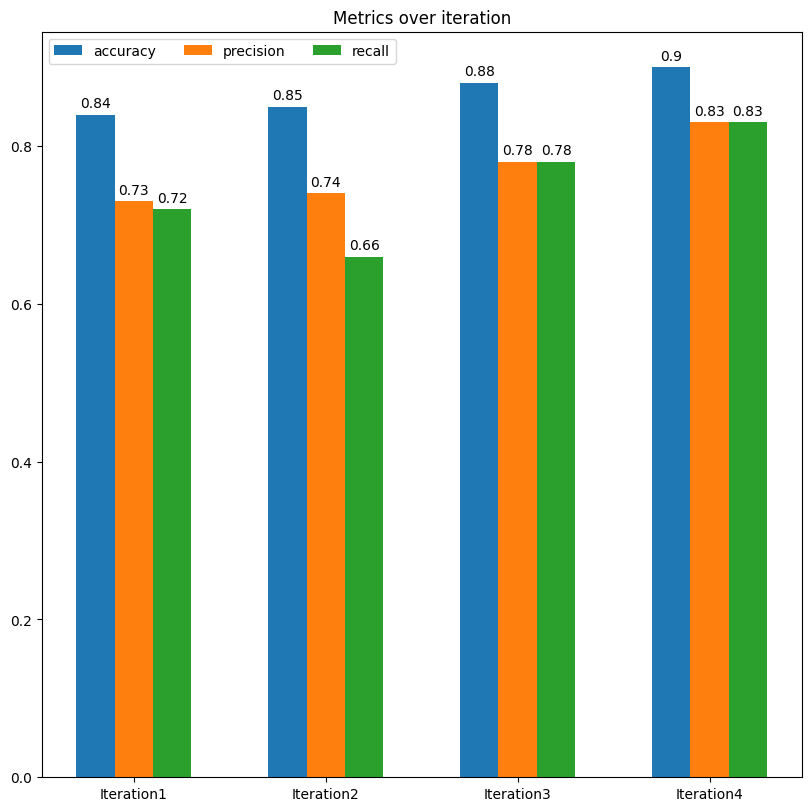

In [54]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

cls_metric_dict = defaultdict(list)
for results in cls_metrics_results:
    for k, v in results.items():
        cls_metric_dict[k].append(v)

# Plot metric results over iteration
fig, ax = plt.subplots(figsize=(8, 8), layout='constrained')

width = 0.2
x = np.arange(len(cls_metrics_results))

multiplier = 0
colors = plt.get_cmap('tab10')
for i, m in enumerate(['accuracy', 'precision', 'recall']):
    m_values = [round(v, 2) for v in cls_metric_dict[m]]
    
    offset = width * multiplier
    multiplier += 1
    rects = ax.bar(x + offset, m_values, width, color=colors(i), label=m)
    ax.bar_label(rects, padding=3)
    
ax.set_title('Metrics over iteration')
ax.legend(loc='upper left', ncols=3)
ax.set_xticks(x+width, labels=[f"Iteration{i+1}" for i in range(len(cls_metrics_results))])

# plt.show()